# Installation of required packages and libraries

In [ ]:
# The versions are important otherwise the package dependencies will likely fail
print('\nINSTALLING REQUIRED PACKAGES...')
!pip install --upgrade pip==21.1.3

!pip install --upgrade setuptools==59.5.0
# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
#!python -m pip install mitmproxy
#!pip install torch==1.10.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install torch==1.10.2 -f https://download.pytorch.org/whl/cpu/torch_stable.html

# AutoGluon(2020): This popular AutoML open-source toolkit developed by AWS helps in getting a strong predictive performance 
# in various machine learning and deep learning models on text, image, and tabular data.
!pip install autogluon

!pip install --upgrade scikit-learn==1.0.0

print('\nREQUIRED PACKAGES INSTALLED')

In [ ]:
# For visualisation of plots
!pip install seaborn

In [ ]:
# For writing/saving structural alert images to excel file
!pip install xlsxwriter

# Automated machine learning model training and evaluation

In [10]:
# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):

    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
# The function is expecting a training and test set with SMILES and Binary Activity (2 columns in total)
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    
    # Define metrics for validation here
    # If using a different metric other than accuracy, note that the preset below needs to be changed as well
    # Otherwise, the model will focus on acc
    metric = 'accuracy'
    ag_sensitivity_scorer = make_scorer(name='SE',
                             score_func=sensitivity,
                             optimum=1,
                             greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
    # Best quality improves performance but takes longer to run. Medium_quality is the default setting.
    # For more details see the AutoGluon package documentation
#     preset = 'best_quality'
    preset = 'medium_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=ag_sensitivity_scorer,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return
#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'
root_desc = 'V2.0.1 in vivo data'
root = 'C:/Users/mwhw3/Desktop/DART project/'
input_path = root + root_desc + '.csv'

total_runs = 5

overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' all Unified data external prediction' + \
str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    desc = root_desc + ' ' + str(run)
    check_path = root + 'AutoML models/' + desc + '/' + 'Data/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    # Save locations for training and test sets                              
    train_save = root + 'AutoML models/' + desc + '/' + 'Data/' + desc + ' CSV train.csv'
    test_save = root + 'AutoML models/' + desc + '/' + 'Data/' + desc + ' CSV test.csv'

    # Save location for model results
    model_name = root + 'AutoML models/' + desc + '/' + 'Models/'
    if os.path.exists(model_name)== False:
        os.makedirs(model_name)
    check_path = root + 'AutoML models/' + desc + '/' + 'Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'

    # The AutoGluon package creates a folder if one is not present
    # Otherwise it will save in the specified filepath
    save_path = root + 'AutoML models/' + desc + '/'                            
    #==============================================================================================#                             
    # Main code
    #input_csv = pd.read_csv(input_path)
    training_set,test_set = split_train_test(input_path,0.2,train_save,test_save,True)                              

    # If running AutoGluon model code                         
    AutoGluon(training_set,test_set,save_path,model_results,model_name)
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                             ALL MODELS TRAINED AND EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

#==============================================================================================#
#==============================================================================================#    
# Combine results for models across all runs    

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'
#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','SE','SP','Acc','MCC']

result_dict = {}
for run in range(1,total_runs+1):
    desc = root_desc + ' ' + str(run)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'
    results_df = pd.read_csv(model_results)
    results_df = results_df[col_ls]
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df
    
combined_df = pd.concat(result_dict.values())
#print(combined_df)
mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']
mean_df['Acc'] = 100 * mean_df['Acc']

mean_df = mean_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']
std_df['Acc'] = 100 * std_df['Acc']

std_df = std_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(std_df)

overall_df = mean_df

overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']
overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

overall_df.to_csv(overall_save)
print(overall_df)


print('\nFINISHED')


#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
                                               SMILES  Binary Activity
0                              S=P(N1CC1)(N1CC1)N1CC1                1
1            CC1(OC(=O)N(C1=O)C1=CC(Cl)=CC(Cl)=C1)C=C                1
2       SCCC(=O)OCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS                0
3                                    SC(=S)NCCNC(S)=S                1
4                                                SC#N                1
...                                               ...              ...
1678     [H]C12CC3=C4C(OC5C(O)C=CC1C45CCN2C)=C(O)C=C3                1
1679    [

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 in vivo data 1/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    1346
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22243.8 MB
	Train Data (Original)  Memory Usage: 11.03 MB (0.0% of available memory)


      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     1     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1341     0     0     0     0     0     0     0     0     0     0  ...     0   
1342     0     0     0     0     0     0     0     0     0     0  ...     0   
1343     0     1     0     0     0     0     0     0     0     0  ...     0   
1344     0     1     0     0     0     0     0     0     0     0  ...     0   
1345     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2007 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 41): ['64', '78', '141', '148', '149', '163', '183', '215', '234', '236', '268', '363', '388', '512', '513', '518', '572', '774', '793', '830', '851', '956', '986', '998', '1002', '1192', '1229', '1248', '1329', '1345', '1473', '1486', '1547', '1596', '1882', '1890', '1894', '1902', '1907', '1931', '1965']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2007 | ['0', '1', '2', '3', '4', ...]
	Ty

Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1074, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1032, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 577, in fit
    out = self._fit(**kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 153, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.p

	0.8249	 = Validation score   (SE)
	1.05s	 = Training   runtime
	0.89s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 2310.53s of the 3509.0s of remaining time.
	0.8236	 = Validation score   (SE)
	1.16s	 = Training   runtime
	0.91s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 2308.01s of the 3506.47s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=8432, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py", line 418, in save
   

Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 2259.37s of the 3457.84s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=15084, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\tabular_nn\torch\tabular_nn_torch.py", line 557, in save
    path_final = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3415.95s of remaining time.
	0.8301	 = Validation score   (SE)
	0.29s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3415.65s of the 3415.55s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=5596, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3

Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 3377.73s of the 3377.62s of remaining time.
	0.7925	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.8s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 3375.34s of the 3375.22s of remaining time.
	0.7886	 = Validation score   (SE)
	1.13s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3372.9s of the 3372.79s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-07-24 09:37:56,514	ERROR serialization.py:270 -- No module named '_catboost'
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 268, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 

Fitting model: XGBoost_BAG_L2 ... Training model for up to 3323.21s of the 3323.1s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14968, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\xgboost\xgboost_model.py", line 209, in save
    path = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\si

Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3283.24s of the 3283.14s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13128, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\common\savers\save_pkl.py", line 21, in save
    save_with_fn(validated_path, object, pickle_fn, format=format, verbose=verbose, compression_fn=compression_fn,
  


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0      WeightedEnsemble_L2    0.846154  143  35  26  133  0.846154  0.791667   
1    ExtraTreesEntr_BAG_L1    0.840237  142  35  27  133  0.840237  0.791667   
2  RandomForestGini_BAG_L1    0.840237  142  38  27  130  0.840237  0.773810   
3    ExtraTreesGini_BAG_L2    0.840237  142  32  27  136  0.840237  0.809524   
4      WeightedEnsemble_L3    0.840237  142  32  27  136  0.840237  0.809524   
5    ExtraTreesGini_BAG_L1    0.834320  141  36  28  132  0.834320  0.785714   
6  RandomForestEntr_BAG_L1    0.828402  140  38  29  130  0.828402  0.773810   
7    ExtraTreesEntr_BAG_L2    0.828402  140  30  29  138  0.828402  0.821429   
8  RandomForestGini_BAG_L2    0.828402  140  29  29  139  0.828402  0.827381   
9  RandomForestEntr_BAG_L2    0.816568  138  28  31  140  0.816568  0.833333   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 in vivo data 2/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    1346
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22288.81 MB
	Train Data (Original)  Memory Usage: 11.03 MB (0.0% of available memory)

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     1     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1341     0     0     0     0     0     0     0     0     0     0  ...     0   
1342     0     0     0     0     0     0     0     0     0     0  ...     0   
1343     0     0     0     0     0     0     0     0     0     0  ...     0   
1344     0     0     0     0     0     0     0     0     0     0  ...     0   
1345     0     1     0     0     0     0     1     1     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2006 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 42): ['64', '78', '148', '163', '183', '234', '236', '388', '509', '512', '551', '572', '663', '793', '830', '851', '912', '956', '996', '998', '1002', '1006', '1018', '1192', '1220', '1229', '1329', '1350', '1486', '1547', '1596', '1658', '1743', '1777', '1881', '1890', '1894', '1902', '1907', '1931', '1947', '1965']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2006 | ['0', '1', '2', '3', '

Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1074, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1032, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 577, in fit
    out = self._fit(**kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 153, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.p

	0.8162	 = Validation score   (SE)
	1.09s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 2333.78s of the 3532.59s of remaining time.
	0.8189	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 2331.57s of the 3530.39s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13276, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py", line 418, in save
 

Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 2286.19s of the 3485.0s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14504, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\tabular_nn\torch\tabular_nn_torch.py", line 557, in save
    path_final = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3443.6s of remaining time.
	0.8216	 = Validation score   (SE)
	0.28s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3443.3s of the 3443.19s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14920, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\

Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 3405.17s of the 3405.07s of remaining time.
	0.7976	 = Validation score   (SE)
	1.12s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 3402.81s of the 3402.7s of remaining time.
	0.7989	 = Validation score   (SE)
	1.06s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3400.46s of the 3400.36s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-07-24 09:43:12,795	ERROR serialization.py:270 -- No module named '_catboost'
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 268, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 

Fitting model: XGBoost_BAG_L2 ... Training model for up to 3351.39s of the 3351.29s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=10516, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\xgboost\xgboost_model.py", line 209, in save
    path = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\s

Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3311.33s of the 3311.23s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=11776, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\common\savers\save_pkl.py", line 21, in save
    save_with_fn(validated_path, object, pickle_fn, format=format, verbose=verbose, compression_fn=compression_fn,
  


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0  RandomForestGini_BAG_L1    0.788360  149  16  40  132  0.788360  0.891892   
1    ExtraTreesGini_BAG_L1    0.783069  148  15  41  133  0.783069  0.898649   
2  RandomForestEntr_BAG_L1    0.777778  147  16  42  132  0.777778  0.891892   
3    ExtraTreesEntr_BAG_L2    0.767196  145  14  44  134  0.767196  0.905405   
4      WeightedEnsemble_L3    0.761905  144  12  45  136  0.761905  0.918919   
5    ExtraTreesGini_BAG_L2    0.761905  144  12  45  136  0.761905  0.918919   
6  RandomForestGini_BAG_L2    0.756614  143  13  46  135  0.756614  0.912162   
7  RandomForestEntr_BAG_L2    0.751323  142  11  47  137  0.751323  0.925676   
8    ExtraTreesEntr_BAG_L1    0.746032  141  16  48  132  0.746032  0.891892   
9      WeightedEnsemble_L2    0.746032  141  16  48  132  0.746032  0.891892   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 in vivo data 3/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    1346
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22316.54 MB
	Train Data (Original)  Memory Usage: 11.03 MB (0.0% of available memory)

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     1     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     1     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1341     0     1     0     0     0     0     0     0     0     0  ...     0   
1342     0     0     0     0     0     0     0     0     0     0  ...     0   
1343     0     0     0     0     0     0     0     0     0     0  ...     0   
1344     0     0     0     0     0     0     0     0     0     0  ...     0   
1345     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2007 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 41): ['44', '64', '148', '163', '183', '223', '234', '236', '388', '512', '560', '572', '686', '704', '778', '793', '830', '920', '956', '986', '998', '1002', '1021', '1192', '1229', '1329', '1347', '1486', '1547', '1552', '1596', '1740', '1777', '1817', '1857', '1890', '1894', '1902', '1907', '1931', '1965']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2007 | ['0', '1', '2', '3', '4', ...]


Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1074, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1032, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 577, in fit
    out = self._fit(**kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 153, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.p

	0.8189	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 2331.95s of the 3530.75s of remaining time.
	0.8162	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 2329.73s of the 3528.53s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=15252, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py", line 418, in save
  

Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 2284.66s of the 3483.46s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=10236, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\tabular_nn\torch\tabular_nn_torch.py", line 557, in save
    path_final = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3441.98s of remaining time.
	0.8282	 = Validation score   (SE)
	0.28s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3441.68s of the 3441.57s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14788, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw

Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 3403.72s of the 3403.62s of remaining time.
	0.7963	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 3401.42s of the 3401.32s of remaining time.
	0.7909	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3399.14s of the 3399.03s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-07-24 09:48:29,623	ERROR serialization.py:270 -- No module named '_catboost'
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 268, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line

Fitting model: XGBoost_BAG_L2 ... Training model for up to 3349.84s of the 3349.73s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14284, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\xgboost\xgboost_model.py", line 209, in save
    path = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\s

Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3309.6s of the 3309.5s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=1376, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\common\savers\save_pkl.py", line 21, in save
    save_with_fn(validated_path, object, pickle_fn, format=format, verbose=verbose, compression_fn=compression_fn,
  Fil


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0    ExtraTreesGini_BAG_L1    0.814815  154  30  35  118  0.814815  0.797297   
1      WeightedEnsemble_L2    0.814815  154  29  35  119  0.814815  0.804054   
2    ExtraTreesEntr_BAG_L1    0.809524  153  28  36  120  0.809524  0.810811   
3  RandomForestEntr_BAG_L1    0.804233  152  31  37  117  0.804233  0.790541   
4  RandomForestGini_BAG_L1    0.798942  151  28  38  120  0.798942  0.810811   
5    ExtraTreesEntr_BAG_L2    0.793651  150  21  39  127  0.793651  0.858108   
6  RandomForestGini_BAG_L2    0.793651  150  21  39  127  0.793651  0.858108   
7    ExtraTreesGini_BAG_L2    0.788360  149  23  40  125  0.788360  0.844595   
8      WeightedEnsemble_L3    0.788360  149  21  40  127  0.788360  0.858108   
9  RandomForestEntr_BAG_L2    0.783069  148  19  41  129  0.783069  0.871622   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 in vivo data 4/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    1346
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...


      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     1     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     1     0  ...     0   
3        0     0     0     0     0     0     0     1     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1341     0     0     0     0     0     0     0     0     0     0  ...     0   
1342     0     0     0     0     0     0     0     0     0     0  ...     0   
1343     0     0     0     0     0     0     0     0     0     0  ...     0   
1344     0     0     0     0     0     0     0     0     0     0  ...     0   
1345     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Available Memory:                    22352.74 MB
	Train Data (Original)  Memory Usage: 11.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2006 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 42): ['64', '148', '163', '183', '223', '234', '236', '269', '363', '388', '512', '538', '560', '572', '583', '686', '704', '773', '793', '830', '956', '998', '1002', '1079', '1192', '1220', '1229', '1248', '1271', '1329', '1335', '1461', '1486', '1547', '1596', '1615', '1890', '1894', '1902', '1907', '1931', '1965']
		These features carry no predictive signal and should be manu

Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1074, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1032, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 577, in fit
    out = self._fit(**kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 153, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.p

	0.8159	 = Validation score   (SE)
	1.11s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 2332.61s of the 3531.41s of remaining time.
	0.8238	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 2330.4s of the 3529.2s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=6848, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py", line 418, in save
    

Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 2284.32s of the 3483.12s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=10636, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\tabular_nn\torch\tabular_nn_torch.py", line 557, in save
    path_final = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3441.87s of remaining time.
	0.8318	 = Validation score   (SE)
	0.27s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3441.57s of the 3441.47s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13056, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwh

Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 3403.84s of the 3403.73s of remaining time.
	0.8066	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 3401.55s of the 3401.45s of remaining time.
	0.8093	 = Validation score   (SE)
	1.14s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3399.18s of the 3399.08s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-07-24 09:53:47,234	ERROR serialization.py:270 -- No module named '_catboost'
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 268, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 

Fitting model: XGBoost_BAG_L2 ... Training model for up to 3349.58s of the 3349.47s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=14036, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\xgboost\xgboost_model.py", line 209, in save
    path = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\s

Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3309.63s of the 3309.53s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=3080, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\common\savers\save_pkl.py", line 21, in save
    save_with_fn(validated_path, object, pickle_fn, format=format, verbose=verbose, compression_fn=compression_fn,
  F


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0  RandomForestGini_BAG_L1    0.810811  150  26  35  126  0.810811  0.828947   
1      WeightedEnsemble_L2    0.810811  150  26  35  126  0.810811  0.828947   
2  RandomForestEntr_BAG_L1    0.805405  149  27  36  125  0.805405  0.822368   
3    ExtraTreesGini_BAG_L2    0.805405  149  26  36  126  0.805405  0.828947   
4      WeightedEnsemble_L3    0.805405  149  27  36  125  0.805405  0.822368   
5    ExtraTreesEntr_BAG_L2    0.800000  148  27  37  125  0.800000  0.822368   
6  RandomForestGini_BAG_L2    0.794595  147  25  38  127  0.794595  0.835526   
7    ExtraTreesEntr_BAG_L1    0.789189  146  27  39  125  0.789189  0.822368   
8  RandomForestEntr_BAG_L2    0.789189  146  23  39  129  0.789189  0.848684   
9    ExtraTreesGini_BAG_L1    0.778378  144  28  41  124  0.778378  0.815789   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 in vivo data 5/Models/\"
AutoGluon Version:  0.4.0
Python Version:     3.8.10
Operating System:   Windows
Train Data Rows:    1346
Train Data Columns: 2048
Label Column: Binary Activity
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22312.85 MB
	Train Data (Original)  Memory Usage: 11.03 MB (0.0% of available memory)

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     1     0     0     0     0     0     0     0     0  ...     0   
4        0     1     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1341     0     0     0     0     0     0     0     0     0     0  ...     0   
1342     0     0     0     0     0     0     0     0     0     0  ...     0   
1343     0     1     0     0     0     0     0     0     0     0  ...     0   
1344     0     0     0     0     0     0     0     0     0     0  ...     0   
1345     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2007 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 41): ['30', '64', '104', '148', '149', '163', '183', '234', '236', '268', '388', '512', '538', '572', '720', '756', '793', '830', '851', '905', '956', '998', '1002', '1018', '1192', '1229', '1329', '1334', '1335', '1439', '1486', '1547', '1596', '1658', '1890', '1894', '1902', '1907', '1931', '1944', '1965']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2007 | ['0', '1', '2', '3', '4', ...]
	

Detailed Traceback:
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1074, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1032, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, **model_fit_kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 577, in fit
    out = self._fit(**kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\stacker_ensemble_model.py", line 153, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\bagged_ensemble_model.p

	0.8075	 = Validation score   (SE)
	1.02s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 2333.42s of the 3532.24s of remaining time.
	0.8089	 = Validation score   (SE)
	1.03s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 2331.21s of the 3530.03s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13204, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py", line 418, in save
 

Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 2286.77s of the 3485.59s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13852, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\tabular_nn\torch\tabular_nn_torch.py", line 557, in save
    path_final = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 3443.73s of remaining time.
	0.817	 = Validation score   (SE)
	0.28s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 3443.42s of the 3443.32s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13672, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw

Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 3405.9s of the 3405.81s of remaining time.
	0.8062	 = Validation score   (SE)
	1.02s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 3403.62s of the 3403.51s of remaining time.
	0.7968	 = Validation score   (SE)
	1.05s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3401.33s of the 3401.22s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
2023-07-24 09:59:02,625	ERROR serialization.py:270 -- No module named '_catboost'
Traceback (most recent call last):
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line 268, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\ray\serialization.py", line

Fitting model: XGBoost_BAG_L2 ... Training model for up to 3352.33s of the 3352.22s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=7428, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\tabular\models\xgboost\xgboost_model.py", line 209, in save
    path = super().save(path=path, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\si

Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3311.79s of the 3311.69s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy
		ray::_ray_fit() (pid=13368, ip=172.26.183.135)
  File "python\ray\_raylet.pyx", line 568, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 572, in ray._raylet.execute_task
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\ensemble\fold_fitting_strategy.py", line 294, in _ray_fit
    fold_model.save()
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\core\models\abstract\abstract_model.py", line 764, in save
    save_pkl.save(path=file_path, object=self, verbose=verbose)
  File "C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\autogluon\common\savers\save_pkl.py", line 21, in save
    save_with_fn(validated_path, object, pickle_fn, format=format, verbose=verbose, compression_fn=compression_fn,
  


MODELS TRAINED

EVALUATING MODELS...
                     model  score_test   TP  FP  FN   TN        SE        SP  \
0    ExtraTreesGini_BAG_L1    0.842640  166  31  31  109  0.842640  0.778571   
1    ExtraTreesEntr_BAG_L1    0.827411  163  29  34  111  0.827411  0.792857   
2  RandomForestGini_BAG_L1    0.827411  163  32  34  108  0.827411  0.771429   
3      WeightedEnsemble_L2    0.827411  163  32  34  108  0.827411  0.771429   
4    ExtraTreesGini_BAG_L2    0.827411  163  29  34  111  0.827411  0.792857   
5      WeightedEnsemble_L3    0.822335  162  29  35  111  0.822335  0.792857   
6    ExtraTreesEntr_BAG_L2    0.822335  162  29  35  111  0.822335  0.792857   
7  RandomForestGini_BAG_L2    0.822335  162  29  35  111  0.822335  0.792857   
8  RandomForestEntr_BAG_L1    0.817259  161  29  36  111  0.817259  0.792857   
9  RandomForestEntr_BAG_L2    0.817259  161  28  36  112  0.817259  0.800000   

        Acc       MCC  score_val  pred_time_test  pred_time_val  fit_time  \
0  0

# For visualising feature space with PCA or t-SNE


#=========================================================================================#

                                      RUNNING PCA for                                       

                             V2.0.1 Stemina data                             


#=========================================================================================#


input_df no. of SMILES:
1001
1001
   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     1     0     0     0  
1     0     0     0     0     0

   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     1     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 2048 columns]

Percentage variance explained: [1.94571479 1.04980103]
PCA done! Time elapsed: 0.02100348472595215 seconds
    pca-one   pca-two
0 -0.340568 -1.343805
1  0.138937 -0.804

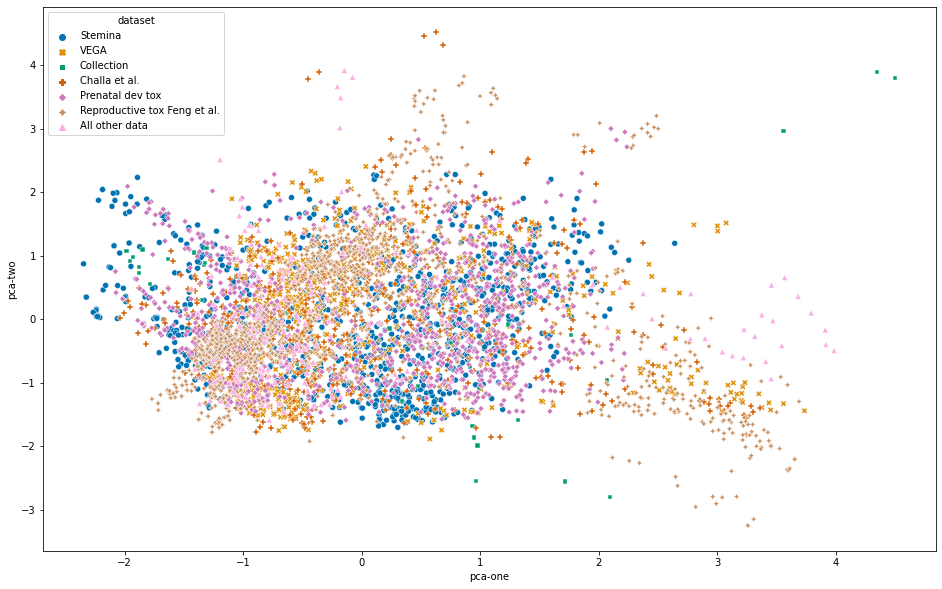

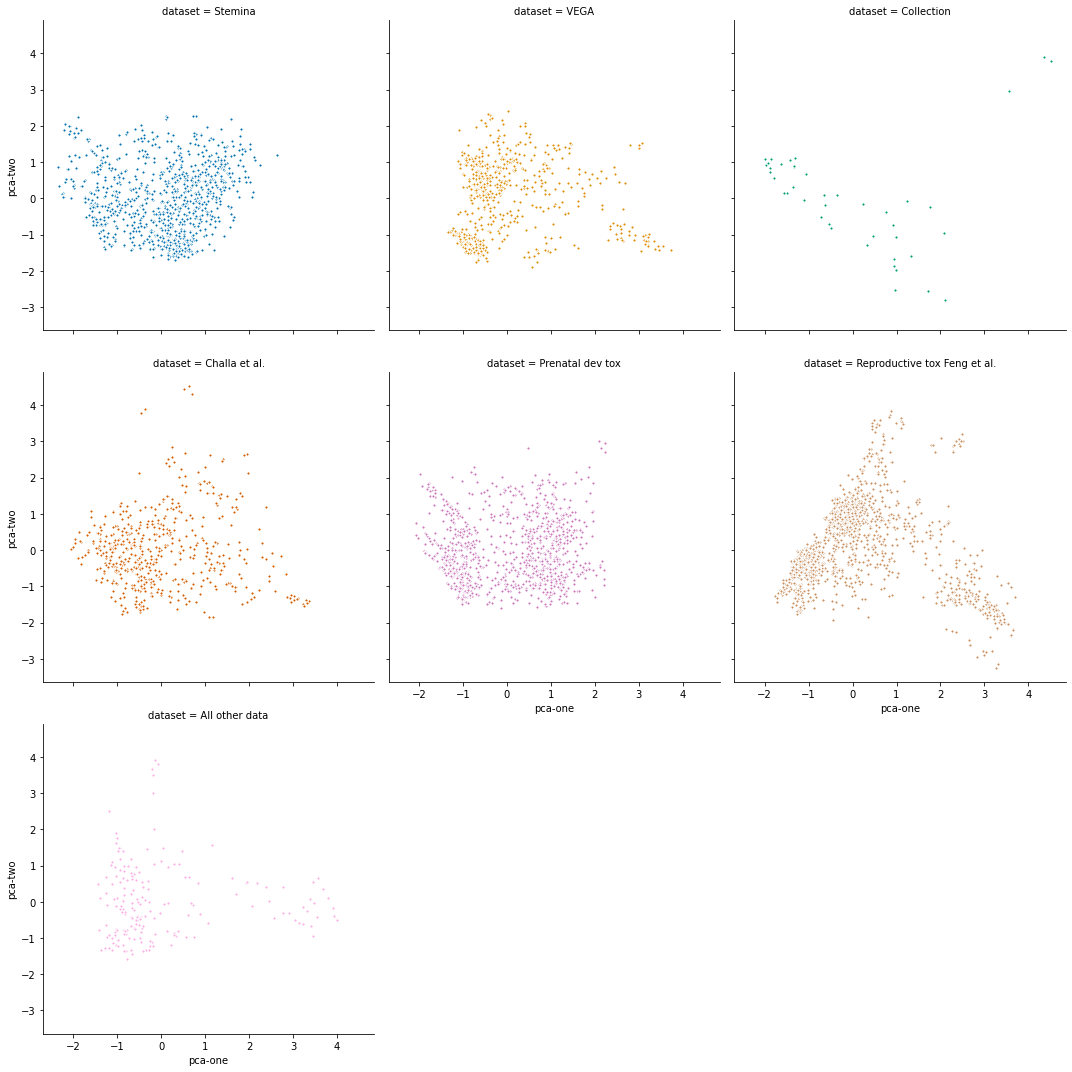


FINISHED


In [9]:
# Code for visualsiing feature space
# t-SNE is used as it known to offer a better visual representation in the 2D plot as compared to PCA

import time

import pandas as pd
import numpy as np

import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

#==============================================================================================#
#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
    input_df['SMILES'].replace('', np.nan, inplace=True)
    input_df.dropna(subset=['SMILES'], inplace=True)
    input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    print(to_concat)
    
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
    plot_data = plot_data.drop(error_idx_ls)
    to_concat = to_concat.drop(error_idx_ls)
    to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

# # PLotting the t-SNE results
# # This gives the x-axis
# plot_data['tsne-2d-one'] = tsne_results[:,0]
# # This gives the y-axis
# plot_data['tsne-2d-two'] = tsne_results[:,1]

def input_to_pca_plot(input_df,filename):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING PCA for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
    input_df['SMILES'].replace('', np.nan, inplace=True)
    input_df.dropna(subset=['SMILES'], inplace=True)
    input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)
    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
    plot_data = plot_data.drop(error_idx_ls)
    to_concat = to_concat.drop(error_idx_ls)
    to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        if filename == 'external test set 1 no outliers':
            input_path = root + 'Outliers/' + filename + '.csv'

        else:
            input_path = root + filename + '.csv'

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label by testing type for plotting later
        if filename == 'V2.0.1 in vivo data':
            new_col = 'in vivo'
        if filename == 'V2.0.1 in vitro data':
            new_col = 'in vitro'              
        
        # Assign label by toxicity endpoint for plotting later
        if filename == 'V2.0.1 Developmental non-toxicants':
            new_col = 'Developmental non-toxicants'
        if filename == 'V2.0.1 Developmental toxicants':
            new_col = 'Developmental toxicants'
        if filename == 'V2.0.1 Reproductive non-toxicants':
            new_col = 'Reproductive non-toxicants'
        if filename == 'V2.0.1 Reproductive toxicants':
            new_col = 'Reproductive toxicants'
              
        
        # Assign label by source for plotting later
        if filename == 'V2.0.1 Stemina data':
            new_col = 'Stemina'

        if filename == 'V2.0.1 Unified data no Stemina data':
            new_col = 'Unified data no Stemina' 

        if filename == 'V2.0.1 VEGA data':
            new_col = 'VEGA'

        if filename == 'V2.0.1 Collection data':
            new_col = 'Collection'
            
        if filename == 'V2.0.1 All other data':
            new_col = 'All other data'
            
        if filename == 'V2.0.1 Challa data':
            new_col = 'Challa et al.'

        if filename == 'V2.0.1 Prenatal dev tox':
            new_col = 'Prenatal dev tox'

        if filename == 'V2.0.1 ML data':
            new_col = 'Reproductive tox Feng et al.'

        if filename == 'V2.0.1 external test set':
            new_col = 'External test set'

        if filename == 'external test set no outliers':
            new_col = 'External test set (no outliers)'



        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    pca_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        if filename == 'external test set no outliers':
            input_path = root + 'Outliers/' + filename + '.csv'

        else:
            input_path = root + filename + '.csv'

        input_df = pd.read_csv(input_path, sep=',')

        pca_results,to_concat = input_to_pca_plot(input_df,filename)

        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        print(pca_df.head())

        
        # Assign label by testing type for plotting later
        if filename == 'V2.0.1 in vivo data':
            new_col = 'in vivo'
        if filename == 'V2.0.1 in vitro data':
            new_col = 'in vitro'       
        
        # Assign label by toxicity endpoint for plotting later
        if filename == 'V2.0.1 Developmental non-toxicants':
            new_col = 'Developmental non-toxicants'
        if filename == 'V2.0.1 Developmental toxicants':
            new_col = 'Developmental toxicants'
        if filename == 'V2.0.1 Reproductive non-toxicants':
            new_col = 'Reproductive non-toxicants'
        if filename == 'V2.0.1 Reproductive toxicants':
            new_col = 'Reproductive toxicants'
              
        
        # Assign label by source for plotting later
        if filename == 'V2.0.1 Stemina data':
            new_col = 'Stemina'

        if filename == 'V2.0.1 Unified data no Stemina data':
            new_col = 'Unified data no Stemina' 

        if filename == 'V2.0.1 VEGA data':
            new_col = 'VEGA'

        if filename == 'V2.0.1 Collection data':
            new_col = 'Collection'
            
        if filename == 'V2.0.1 All other data':
            new_col = 'All other data'
            
        if filename == 'V2.0.1 Challa data':
            new_col = 'Challa et al.'

        if filename == 'V2.0.1 Prenatal dev tox':
            new_col = 'Prenatal dev tox'

        if filename == 'V2.0.1 ML data':
            new_col = 'Reproductive tox Feng et al.'

        if filename == 'V2.0.1 external test set':
            new_col = 'External test set'

        if filename == 'external test set no outliers':
            new_col = 'External test set (no outliers)'



        pca_df = pca_df.assign(dataset = new_col)    

        pca_dict[new_col] = pca_df
    
    return pca_dict,to_concat


# Input test_points as a dataframe with ['tsne-2d-one'] and ['tsne-2d-two'] as columns
def outlier_detection(query_point,test_points,threshold,points_in_circle):
    
    # Test if there are a certain number of test points within the circle of radius = threshold
    # for a given query point
    # Each point will have a x-value and a y-value   
    
    count = 0
    
    for n in range(0,len(test_points)):
        
        x = test_points.iloc[n]['tsne-2d-one']
        y = test_points.iloc[n]['tsne-2d-two']
        
        x_center = query_point['tsne-2d-one']
        y_center = query_point['tsne-2d-two']
        
        check = ((x - x_center)**2) + ((y - y_center)**2)
        
        if check <= (threshold**2):
            count = count + 1
    
    # function will return true if there are <= the specified no. of points in circle within the radius/threshold
    if count <= points_in_circle:
        return True
    
    else:
        return False

def calc_tsne_outliers(value):
    print('CALCULATING OUTLIERS...')
    query_df = tsne_dict['External test set 1']
    test_df = tsne_dict['Unified data no Stemina']

    outlier_ls = []
    outlier_ls.clear()

    # The threshold specified is the radius
    # TYhe values should be a reasonable distance on the t-SNE plot
    threshold = 25
    points_in_circle = 1

    for query in range(0,len(query_df)):

        if query % 10 == 0:
            print('\nNOW FINDING OUTLIERS FOR INDEX {}'.format(query))

        query_point = query_df.iloc[query] 

        if outlier_detection(query_point,test_df,threshold,points_in_circle) == True:
            outlier_ls.append(query)


    # Get outliers in external test set as df for easy access if necessary
    index = root_desc.index(filename)
    input_path = root + root_desc[1] + '.csv'
    input_df = pd.read_csv(input_path, sep=',')

    outlier_df = input_df.iloc[outlier_ls]
    print('\n')
    print('{} OUTLIERS WERE FOUND ON THIS RUN'.format(outlier_df))

    print('\n')
    print(outlier_df.head())
    
    outlier_df.to_csv(outlier_save)

    # save external test set without outliers
    ext_no_outlier_df = input_df.drop(outlier_ls)
    print(ext_no_outlier_df)
    ext_no_outlier_df.to_csv(ext_no_outlier)        
    
#==============================================================================================#
#==============================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

root = 'C:/Users/mwhw3/Desktop/DART project/'

# root_desc = ['V2.0.1 Stemina data']
# save_desc = 'Stemina data'

root_desc = ['V2.0.1 Stemina data','V2.0.1 VEGA data','V2.0.1 Collection data','V2.0.1 Challa data',
             'V2.0.1 Prenatal dev tox', 'V2.0.1 ML data','V2.0.1 All other data']
save_desc = 'Data by source'

# root_desc = ['V2.0.1 Developmental non-toxicants','V2.0.1 Developmental toxicants',
#               'V2.0.1 Reproductive non-toxicants','V2.0.1 Reproductive toxicants']
# save_desc = 'Data by toxicity endpoint'

# root_desc = ['V2.0.1 in vivo data','V2.0.1 in vitro data']
# save_desc = 'Data by testing type'


# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'
#plot_save = root + 'SNS plots/'+ 'Compare Unified data with Stemina' + '.tiff'
#plot_save = root + 'SNS plots/'+ 'Stemina data only' + '.tiff'
#plot_save = root + 'SNS plots/'+ 'Predicting on external test set 1' + '.tiff'

# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
perplex_ls = [10,20,40,60,80]
iterations = 5000
# iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
pca_dict,to_concat = pca_main(root_desc)
pca_concatenated = pd.concat(pca_dict.values(), sort=False, ignore_index=False)  
pca_concatenated.columns= ['pca-one','pca-two','dataset']
plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_concatenated,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 3             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_concatenated, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')

# For loading trained models and predicting on external test set

In [185]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    


#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Unified data'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root_desc = 'V2.0.1 external test set'

root = 'C:/Users/mwhw3/Desktop/DART project/'
test_path = root + root_desc + '.csv'

# Set up test data
X_test,y_test = set_up_test_data(test_path)
test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
y_test = y_test['Binary Activity'].tolist()

total_runs = 5

overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + model_root_desc + ' external prediction ' + \
str(total_runs) +' runs.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    desc = root_desc + ' ' + str(run)
    model_desc = model_root_desc + ' ' + str(run)

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'AutoML models/' + desc + '/' + 'Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'
                         
    #==============================================================================================#                             

    # Load predictor   
    predictor = TabularPredictor.load(model_name)
    y_pred = predictor.predict(X_test)
    
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL MODELS EVALUATED WITH TEST SET(S)\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#==============================================================================================#
#==============================================================================================#    
# Combine results for models across all runs    

# Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'



#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','SE','SP','Acc','MCC']

result_dict = {}
result_dict.clear()
for run in range(1,total_runs+1):
    desc = root_desc + ' ' + str(run)
    model_results = root + 'AutoML models/' + desc + '/' + 'Results/' + desc + ' model results.csv'

    results_df = pd.read_csv(model_results)

    results_df = results_df[col_ls]
    #print(results_df)
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df

    
combined_df = pd.concat(result_dict.values(),ignore_index=True)


mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']
mean_df['Acc'] = 100 * mean_df['Acc']

mean_df = mean_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']
std_df['Acc'] = 100 * std_df['Acc']

std_df = std_df.round({'SE': 1,'SP': 1,'Acc': 1,'MCC': 3}).astype(str)
print(std_df)

# mean_df = mean_df.applymap(str)
# print(mean_df)
# std_df = std_df.applymap(str)
overall_df = mean_df

overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']
overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

overall_df.to_csv(overall_save)
print(overall_df)

print('\nFINISHED')    


SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
68
68

DATA SET UP FOR MODEL

#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Unified data 1/Models/
                      model  score_test  TP  FP  FN  TN        SE        SP  \
0   RandomForestGini_BAG_L1    0.794118  36   9   5  18  0.878049  0.666667   
1     ExtraTreesEntr_BAG_L1    0.779412  35   9   6  18  0.853659  0.666667   
2   RandomForestEntr_BAG_L1    0.779412  34   8   7  19  0.829268  0.703704   
3     ExtraTreesGini_BAG_L1    0.779412  34   8   7  19  0.829268  0.703704   
4       WeightedEn

                      model  score_test  TP  FP  FN  TN        SE        SP  \
0   RandomForestEntr_BAG_L1    0.838235  38   8   3  19  0.926829  0.703704   
1   RandomForestGini_BAG_L1    0.794118  36   9   5  18  0.878049  0.666667   
2     ExtraTreesEntr_BAG_L1    0.794118  36   9   5  18  0.878049  0.666667   
3     ExtraTreesGini_BAG_L1    0.779412  36  10   5  17  0.878049  0.629630   
4     ExtraTreesGini_BAG_L2    0.779412  35   9   6  18  0.853659  0.666667   
5     NeuralNetTorch_BAG_L2    0.779412  34   8   7  19  0.829268  0.703704   
6         LightGBMXT_BAG_L2    0.764706  32   7   9  20  0.780488  0.740741   
7            XGBoost_BAG_L1    0.750000  31   7  10  20  0.756098  0.740741   
8       WeightedEnsemble_L2    0.750000  33   9   8  18  0.804878  0.666667   
9           CatBoost_BAG_L2    0.735294  30   7  11  20  0.731707  0.740741   
10          LightGBM_BAG_L1    0.720588  30   8  11  19  0.731707  0.703704   
11     LightGBMLarge_BAG_L1    0.720588  31   9  10 

                      model  score_test  TP  FP  FN  TN        SE        SP  \
0      LightGBMLarge_BAG_L1    0.823529  38   9   3  18  0.926829  0.666667   
1     ExtraTreesGini_BAG_L1    0.808824  37   9   4  18  0.902439  0.666667   
2     ExtraTreesEntr_BAG_L1    0.794118  37  10   4  17  0.902439  0.629630   
3       WeightedEnsemble_L2    0.794118  35   8   6  19  0.853659  0.703704   
4     ExtraTreesEntr_BAG_L2    0.794118  35   8   6  19  0.853659  0.703704   
5     NeuralNetTorch_BAG_L2    0.794118  35   8   6  19  0.853659  0.703704   
6           CatBoost_BAG_L2    0.794118  35   8   6  19  0.853659  0.703704   
7            XGBoost_BAG_L1    0.779412  32   6   9  21  0.780488  0.777778   
8   RandomForestGini_BAG_L1    0.779412  35   9   6  18  0.853659  0.666667   
9           LightGBM_BAG_L1    0.779412  33   7   8  20  0.804878  0.740741   
10  RandomForestEntr_BAG_L1    0.779412  36  10   5  17  0.878049  0.629630   
11        LightGBMXT_BAG_L1    0.779412  33   7   8 

# For visualising SMILES structural alerts

                                                 SMILES
0                                S=P(N1CC1)(N1CC1)N1CC1
1              CC1(OC(=O)N(C1=O)C1=CC(Cl)=CC(Cl)=C1)C=C
2         SCCC(=O)OCC(COC(=O)CCS)(COC(=O)CCS)COC(=O)CCS
3                                  SC1=NC2=C(S1)C=CC=C2
4                                      SC(=S)NCCNC(S)=S
...                                                 ...
3250  [H][C@]12OC[C@H](O[N+]([O-])=O)[C@@]1([H])OC[C...
3251  [H][C@@]12C[C@H](OC(C)=O)[C@@]([H])([C@@]1(C)C...
3252  [H][C@@]1(CC[C@@]2([H])[C@]3([H])C(O)CC4CC(O)C...
3253                                       [CH]1C=CC=C1
3254                                          [C-]#[O+]

[3255 rows x 1 columns]
51
O-C1-C(-C-C-C-1)-C


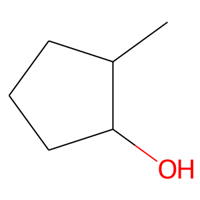

N-C-C-c1:c:c:c:c:c:1


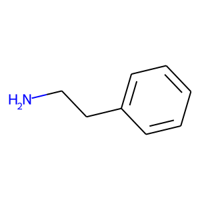

N(-C-C-N)-C-C-O


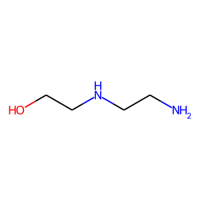

O=C1-C(-C-C-C-1)-C


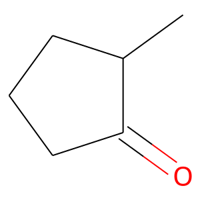

N1(-C-C-C-C-C-1)-C


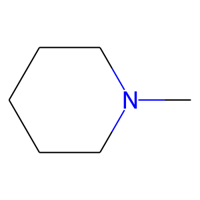

n1:c(:n:c:c:c:1)-N


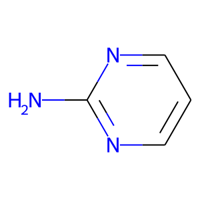

N-C1-O-C(-C-C-1)-C


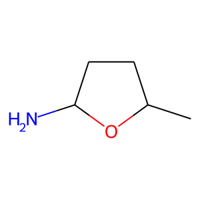

O(-c1:c(:c:c:c:c:1)-C)-C


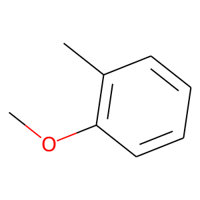

O-C1-C-C(-C-C-C-1)-O


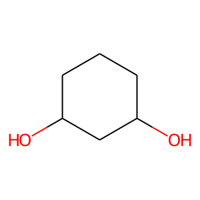

O=C-C1-C2(-C(-C-C-1)-C-C-C-C-2)-C


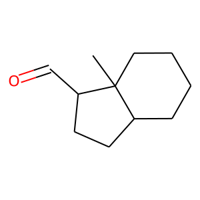

O(-C-c1:c(:c:c:c:c:1)-C)-C


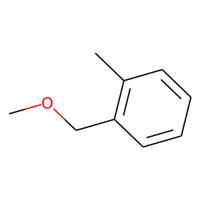

n1(:c:n:c:c:1)-C-C


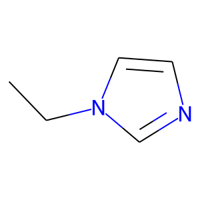

Cl-c1:c:c(:c:c:c:1)-Cl


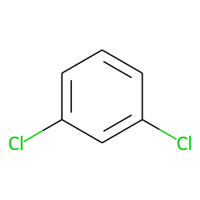

Cl-C-C-N-C-C-Cl


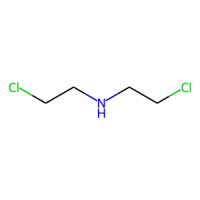

N-C-C-O-c1:c:c:c(:c:c:1)-C


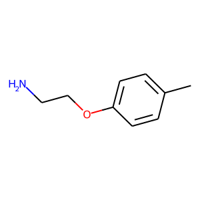

N(-N=O)(-C(-N)=O)-C


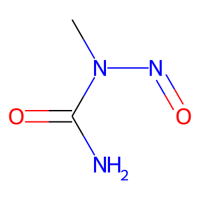

F-c1:c:c:c(:c:c:1)-C


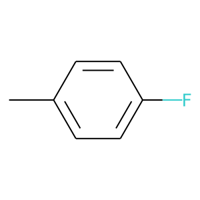

N1-C(-C-N=C(-c2:c-1:c:c:c:c:2)-c1:c:c:c:c:c:1)=O


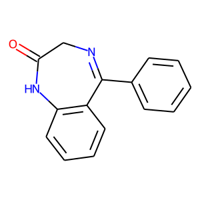

n1:c2:n:c:n:c:c:2:n:c:1


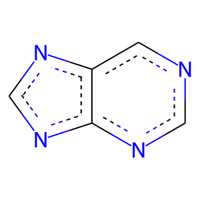

Cl-c1:c:c:c(:c:c:1)-C-c1:c:c:c:c:c:1


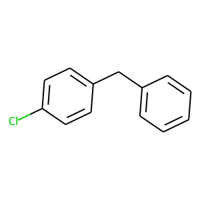

O-C-C=C-C=C-C=C(-C=C-C1-C(-C-C-C-C=1-C)(-C)-C)-C


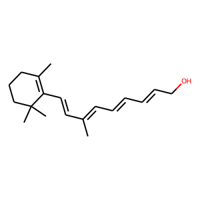

F-C(-F)(-C(-F)(-F)-C(-F)(-F)-C(-F)-C(-F)-C)-C(-F)(-F)-C(-F)-F


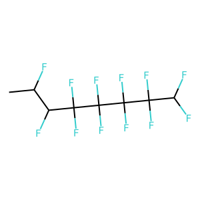

N(-C-C(-N)=O)-C-C


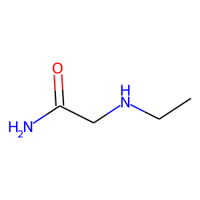

O=C-C-C-C-C-C-C-C(-C)-C


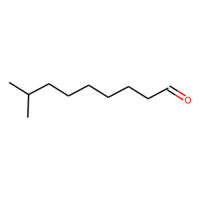

n1:c(:n:c2:c:1:c:c:c:c:2)-N-C(-O-C)=O


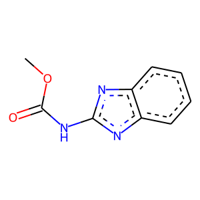

N(-O)(-c1:c(:c:c:c(:c:1)-N(-O)=O)-O)=O


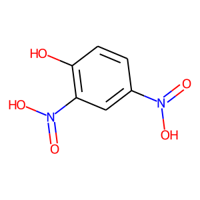

n1:c2:c(:c(:c:1)-C-C):c:c:c:c:2


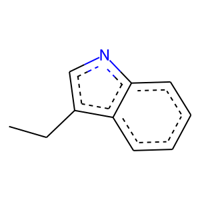

N(-C-C-C-O-c1:c:c:c:c:c:1)-C-C


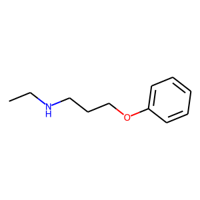

n1:c:c:c(:c:c:1)-C


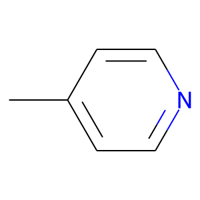

N(-C-C-C(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1)(-C)-C


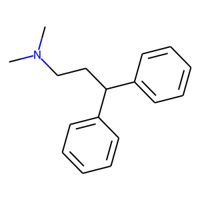

N(-C-C-C-C-C-C-C-C)(-C-C-C-C-C-C-C-C)-C


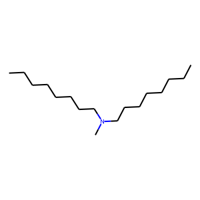

O(-C(-C(-C)=C)=O)-C-C-C-C-C-C-C-C-C-C-C-C


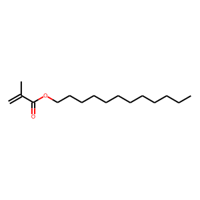

N(-c1:c(:c:c:c:c:1)-N)-C-C


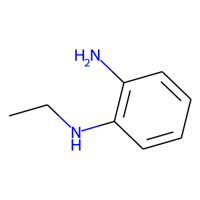

n1:c:n:c:c:c:1-O


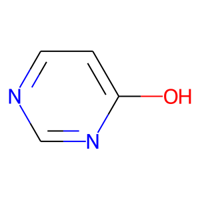

F-C(-F)(-F)-c1:c:c(:c:c:c:1)-N-C(-C(-C)-C)=O


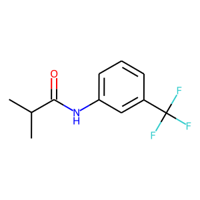

Br-c1:c:c:c(:c:c:1)-O


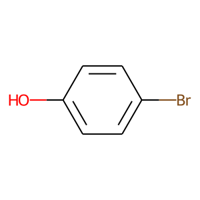

N(-C-c1:o:c:c:c:1)-C


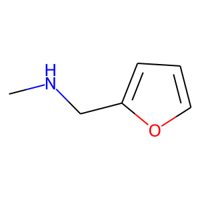

S(-N-C=O)(-C)(=O)=O


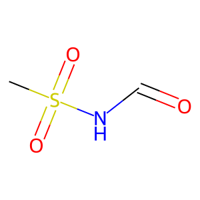

N1(-C-C-N-C-C-1)-C1-c:c-N-c2:c(-N=1):c:c:c:c:2


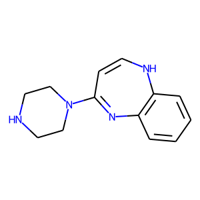

n12-c:c-C(=N-C-c:2:n:n:c:1-C)-c1:c:c:c:c:c:1


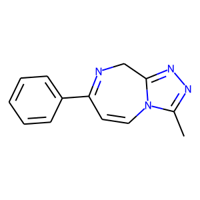

S1-c2:c(-N-c3:c-1:c:c:c:c:3):c:c:c:c:2


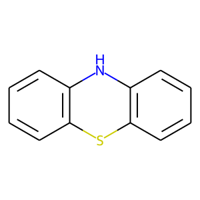

O-C1-C-C2-C(-C-C-1)(-C-C-C-C=2)-C


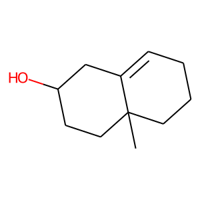

o1:c2:c(:c:c:c:1=O):c:c:c:c:2


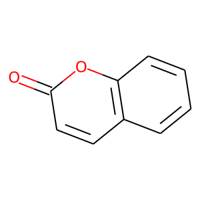

O(-c1:c:c(:c:c:c:1)-C-O-C)-C


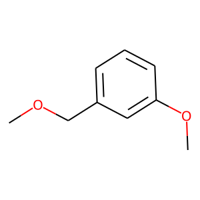

N-C(-c1:c:c:c:c:c:1)-C


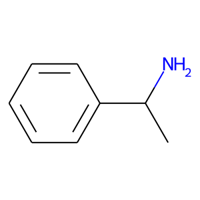

n1:c(:c:c:c:c:1)-N


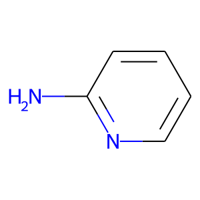

N(-C(-C-N=C)-C)=C


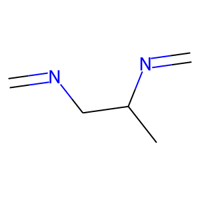

F-C(-F)(-F)-C-O-C


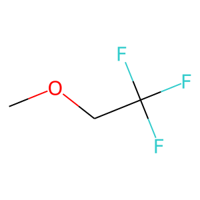

Br-c1:c:c:c:c:c:1


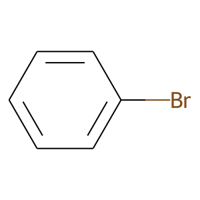

O1-C(-C-C-C-1)-C-O


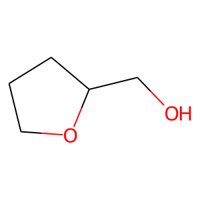

n1:c:n:c:c:c:1-C


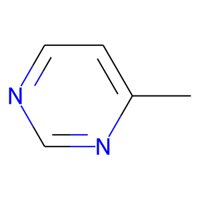


FINISHED


In [12]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

import xlsxwriter

from PIL import Image

import csv
#======================================================================================#
root = 'C:/Users/mwhw3/Desktop/DART project/KNIME data/'
root_desc = 'V2.0.1 in vivo data alerts'

input_path = root + root_desc + '.csv'
output_path = root + root_desc + ' with images.xlsx'


# Read input file containing output from Wedlake et al. KNIME workflow
input_df = pd.read_csv(input_path)


# Read input file containing entire DART database of SMILES
DART_path = 'C:/Users/mwhw3/Desktop/DART project/V2.0.1 Unified data.csv'
DART_df = pd.read_csv(DART_path)
DART_SMILES_df = DART_df[['SMILES']]
print(DART_SMILES_df)




# For each alert, go through the DART database and draw the structure of the alert
# using substructure match. This is to avoid RDKIT throwing up errors for unsanitizee fragments or
# other errors involving SMILES fragments. Also, not sanitizing the alerts preserves the information
# of the alerts

check_path = root + root_desc
if os.path.exists(check_path)== False:
    os.makedirs(check_path)

excel_path = check_path + '/' + root_desc + '.xlsx'
workbook = xlsxwriter.Workbook(excel_path)
worksheet = workbook.add_worksheet('Sheet1')
wrap = workbook.add_format({'text_wrap': True})
worksheet.set_column(0, 3, 27.5, wrap)
worksheet.set_row(1, 150, wrap)

# Copy csv values (SMILES,alert hits etc.) to excel file
csv_dict = input_df.to_dict()
#print(csv_dict.items())

col_num = 0
row_num = 1

# for k, v in csv_dict.items():
#     worksheet.write(0, col_num, k)
#     for key, value in v.items():
#         worksheet.write_row(1, row_num, value)
#         row_num += 1
#     col_num += 1
    
n = 2
with open(input_path, 'rt') as f:
    reader = csv.reader(f)
    for r, row in enumerate(reader):
        for c, col in enumerate(row):
            worksheet.write(r, c, col) # write the csv file content into it
    
    f.close()

    
print(len(input_df['Fragment']))    
for s in input_df['Fragment']:
    print(s)
    m = Chem.MolFromSmiles(s,sanitize=False)
    m.UpdatePropertyCache(strict=False)
    img = Draw.MolToImage(m,kekulize=True)
    img_desc = check_path + '/' + 'alert' + str(n-1) + '.png'
    img = img.resize((200,200))
    img.save(img_desc)
    display(img)
    insert_cell = 'D' + str(n)
    worksheet.set_row(n, 150, wrap)
    worksheet.insert_image(insert_cell, img_desc)
    n = n + 1
    
workbook.close()    


print('\nFINISHED')

# Code to run tested models for datasets

This code will load previously saved models and apply them to existing datasets to see which compounds are incorrectly predicted on the test set. The datasets are expected to be different across all runs but there should be some compounds which are consistenly predicted incorrectly.

In [ ]:
# Code for using trained models to predict on an external test set or external data

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def get_MACCS_fingerprint(smiles):
    
    
    
    return fingerprint_df


# This function is expecting a input csv with two columns 'SMILES' and 'Binary Activity'
def split_train_test(csv,test_ratio,train_save,test_save,overwrite):
    
    # Read input and shuffle randomly
    input_df = pd.read_csv(csv)
    print(input_df)
    input_df = input_df.sample(frac=1)
    input_np = input_df.to_numpy()
    
    # split df randomly according to specified ratio
    train_df, test_df = train_test_split(input_np, test_size=test_ratio)
    
    train_df = pd.DataFrame(train_df,columns=['SMILES','Binary Activity'])
    test_df = pd.DataFrame(test_df,columns=['SMILES','Binary Activity'])
    
    # Save files
    # Ovewrite existing file present in folder
#     print(isfile(train_save))
#     print(isfile(test_save))
    if overwrite == False and isfile(train_save) == True:
        train_save = train_save[:-4] + str(randrange(100)) + train_save[-4:]
        train_df.to_csv(train_save)        
    else:
        train_df.to_csv(train_save)
    
    if overwrite == False and isfile(test_save) == True:
        test_save = test_save[:-4] + str(randrange(100)) + test_save[-4:]
        test_df.to_csv(test_save)        
    else:
        test_df.to_csv(test_save)
    
    
    return train_save,test_save

def most_probable_class(column_list):
    col_val = set(column_list)
    most_prob_class_count = 0
    most_prob_class = 0
    for ele in col_val:
        class_count = column_list.count(ele)
        if class_count > most_prob_class_count:
            most_prob_class_count = class_count
            most_prob_class = ele
            
    return most_prob_class


def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    
def set_up_interpreting_results(test_path,y_pred,run):
    print('\nSETTING UP RESULTS FOR INTERPRETATION...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    interpret_df = dat_test[['SMILES']]
    interpret_df = interpret_df.join(dat_test['Binary Activity'])
    interpret_df['y_pred'] = y_pred

    # Add columns determining which are misclassified
    # False positives
    FP_ls = []
    FP_ls.clear()
    
    for x in range(0,len(interpret_df)):
        if interpret_df.iloc[x]['Binary Activity'] == 0 and interpret_df.iloc[x]['y_pred'] == 1:
            FP_ls.append("True")
        else:
            FP_ls.append("False")
            
    # False negatives
    FN_ls = []
    FN_ls.clear()
    
    for x in range(0,len(interpret_df)):
        if interpret_df.iloc[x]['Binary Activity'] == 1 and interpret_df.iloc[x]['y_pred'] == 0:
            FN_ls.append("True")
        else:
            FN_ls.append("False")    

    interpret_df['False positive'] = FP_ls
    interpret_df['False negative'] = FN_ls
    
    interpret_df['run_no'] = run
            
    print('\nRESULTS SET UP FOR INTERPRETATION')
    
    return interpret_df

def predict_new_chemicals(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
  
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test
#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root = 'C:/Users/mwhw3/Desktop/DART project/'


total_runs = 1

overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V2 interpreting predicted results.csv'
#overall_save = root + 'AutoML models combined results/' + root_desc + ' ' + str(total_runs) +' runs.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    model_desc = model_root_desc + ' ' + str(run)
    dataset_desc = model_desc +  ' CSV test.csv'

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'Urgent chemicals/' + model_desc + '/' + 'Interpreting Predicted Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
#     model_results = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' interpreting predicted results.csv'
    interpret_df_save = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
    
    #==============================================================================================#
    # Set up test data
    test_path = root + 'Urgent chemicals/' + 'DART_chemicals.csv'
    
    # If test data has 'Binary Activity'
#     X_test,y_test = set_up_test_data(test_path)

#     test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
#     y_test = y_test['Binary Activity'].tolist()
    
    # If test data does not have 'Binary Activity'
    X_test = predict_new_chemicals(test_path)
    #==============================================================================================#                             

    # Load predictor   
    predictor = TabularPredictor.load(model_name)
    
    # *** Set this manually ***
    if model_root_desc == 'V2.0.1 Developmental toxicity':
        best_model = 'WeightedEnsemble_L2'
    if model_root_desc == 'V2.0.1 Reproductive toxicity':
        best_model = 'RandomForestGini_BAG_L2'
    if model_root_desc == 'V2.0.1 Unified data':
        best_model = 'ExtraTreesEntr_BAG_L2'
    
    ###
    # If only using one model to predict
    model_i = 0  # Set index of model to use in set of models within predictor
    
    i = 0
    
#     print(all_models)
    all_models = predictor.get_model_names()
    model_i = [i for i,x in enumerate(all_models) if best_model == x]
    model_i = model_i[0]
    model_to_use = predictor.get_model_names()[model_i]
    model_pred = predictor.predict(X_test, model=model_to_use)
    print("\nPredicting using %s model" % (model_to_use))               
    
    y_pred = predictor.predict(X_test)
    
    y_pred = y_pred.tolist()
    y_pred_df = pd.DataFrame({'Result':y_pred})
    print(y_pred_df)
    
#     interpret_df = set_up_interpreting_results(test_path,y_pred,run)
    
#     add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

#     results_df = predictor.leaderboard(test_data, silent=True,
#                                        extra_metrics=add_metrics
#                                       )  
    
    #results_df.to_csv(model_results)
#     interpret_df.to_csv(interpret_df_save)
#     print(results_df)
#     print(interpret_df)


    ###
#     # If using multiple models to predict ie. check prediction of ensemble of models
#     all_models = predictor.get_model_names()
#     count = 0
#     for use_model in all_models:
#         y_pred = predictor.predict(X_test, model=use_model)
#         y_pred = y_pred.tolist()
#         if count == 0:
#             interpret_df = set_up_interpreting_results(test_path,y_pred,run)
#             combined_df = interpret_df
#             combined_df['Model'] = str(use_model)
#             count = count + 1
#             print(combined_df)
#         else:
#             interpret_df = set_up_interpreting_results(test_path,y_pred,run)
#             interpret_df['Model'] = str(use_model)
#             combined_df = combined_df.merge(interpret_df, how='inner', on='SMILES')
#             print(combined_df)
#             count = count + 1
#             if count == len(all_models):
#                 combined_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' V2 misclassified predicted results.csv'
#                 combined_df.to_csv(combined_df_save)

    print('\nMODELS EVALUATED')
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL MODELS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#==============================================================================================#  

# # Combine all misclassified results across 5 runs into a single df
# run = 1
# model_desc = model_root_desc + ' ' + str(run)
# interpret_df_load = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
# initial_df = pd.read_csv(interpret_df_load,index_col=0)
# combined_df = initial_df.loc[(initial_df['False positive'] == True) | (initial_df['False negative'] == True)]

# for run in range(2,total_runs+1):
#     model_desc = model_root_desc + ' ' + str(run)
#     interpret_df_load = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/' + model_desc + ' V2 interpreting predicted results.csv'
#     initial_df = pd.read_csv(interpret_df_load,index_col=0)
#     temp_interpret_df = initial_df.loc[(initial_df['False positive'] == True) | (initial_df['False negative'] == True)]    
#     combined_df = pd.concat([combined_df,temp_interpret_df],axis=0,ignore_index=True)
        
# print(combined_df)

# # Process combined_df into a single df with no duplicate SMILES
# # each entry will show if the compound is a FP or FN for each run
# # Each run will be recorded as a single column
# # Final df will have columns: SMILES, and 1 column per run

# ref_df = combined_df.drop_duplicates(subset=['SMILES'])
# ref_df = ref_df[['SMILES']]
# ref_df = ref_df.reset_index(drop=True)

# # Create additional columns to store values
# ref_df['run_1'] = '#NA'
# ref_df['run_2'] = '#NA'
# ref_df['run_3'] = '#NA'
# ref_df['run_4'] = '#NA'
# ref_df['run_5'] = '#NA'

# print(ref_df)

# for x in range(0,len(ref_df)):
#     if x % 25 == 0:
#         print('Now processing {} of {}'.format(x,len(ref_df)))
#     query_SMILES = ref_df.iloc[x]['SMILES']
    
#     # Get required information from combined_df
#     for y in range(0,len(combined_df)):
#         if combined_df.iloc[y]['SMILES'] == query_SMILES:
#             column_no = combined_df.iloc[y]['run_no']
#             if combined_df.iloc[y]['False positive'] == True:
#                 column_value = 'FP'
#             if combined_df.iloc[y]['False negative'] == True:
#                 column_value = 'FN'
    
#             # Update ref_df based on queried values
#             column_name = 'run_' + str(column_no)
#             ref_df.loc[x,[column_name]] = column_value
    
    
# print(ref_df)
# ref_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' misclassified predicted results.csv'
# ref_df.to_csv(ref_df_save)

print('\nFINISHED')      

# Reprotox to devtox

In [50]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Directory of test files
test_root_desc = 'V2.0.1 Developmental toxicity'
# test_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of model results save 
overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V3 interpreting predicted results.csv'

#==============================================================================================#
#==============================================================================================#    

# Set up data
test_path = model_root + test_root_desc + '.csv'

X_test,y_test = set_up_test_data(test_path)

test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
y_test = y_test['Binary Activity'].tolist()

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for run in range(1,total_runs+1):
       
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(run)                      )
    print('#=========================================================================================#')


    print('\nNOW APPLYING MODEL {}\n'.format(run))

    model_desc = model_root_desc + ' ' + str(run)

    # Load location for models
    model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

    # Save location for results
    results_save_path = model_root + 'Transfer learning/V3 results/Repro to dev/' + model_desc + ' V3 interpreting predicted results.csv'

    # Load predictor   
    predictor = TabularPredictor.load(model_name)

    # *** Set this manually ***
    if model_root_desc == 'V2.0.1 Developmental toxicity':
        best_model = 'WeightedEnsemble_L2'
    if model_root_desc == 'V2.0.1 Reproductive toxicity':
        best_model = 'RandomForestEntr_BAG_L1'

    # Use all models to predict
    model_i = 0  # Set index of model to use in set of models within predictor
    i = 0

#     print(all_models)
    all_models = predictor.get_model_names()
    model_i = [i for i,x in enumerate(all_models) if best_model == x]
    model_i = model_i[0]
    model_to_use = predictor.get_model_names()[model_i]
    model_pred = predictor.predict(X_test, model=model_to_use)
    print("\nPredicting using %s model" % (model_to_use))               

    y_pred = predictor.predict(X_test)

    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )  

#         print(results_df)
    results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(run))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2224
2224

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET 1 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

DATASET 1 EVALUATED

#=========================================================================================#

                               DATASET 2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

DATASET 2 EVALUATED

#=========================================================================================#

                               DATASET 3 BEING EVALUATED
#=========================================================================================#

In [51]:
#==============================================================================================#
#==============================================================================================#    



#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','Acc','SE','SP','MCC']

result_dict = {}
result_dict.clear()

for run in range(1,total_runs+1):
    model_results = model_root + 'Transfer learning/V3 results/Repro to dev/' + model_desc + ' V3 interpreting predicted results.csv'

    results_df = pd.read_csv(model_results)

    results_df = results_df[col_ls]
    #print(results_df)
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df


combined_df = pd.concat(result_dict.values(),ignore_index=True)


mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['Acc'] = 100 * mean_df['Acc']
mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']


mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)

print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['Acc'] = 100 * std_df['Acc']
std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']


std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
print(std_df)

# mean_df = mean_df.applymap(str)
# print(mean_df)
# std_df = std_df.applymap(str)
overall_df = mean_df

overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

combined_save_path = model_root + 'Transfer learning/V3 results/Repro to dev/Combined results/' \
+ model_desc + 'combined V3 interpreting predicted results.csv'

overall_df.to_csv(combined_save_path)
print(overall_df)   
print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          64.1  77.5  47.5  0.263
CatBoost_BAG_L2          67.5  80.0  52.1  0.337
ExtraTreesEntr_BAG_L1    67.6  82.7  49.0  0.339
ExtraTreesEntr_BAG_L2    65.7  80.7  47.3  0.299
ExtraTreesGini_BAG_L1    67.7  83.2  48.6  0.342
ExtraTreesGini_BAG_L2    66.3  80.9  48.3  0.311
LightGBMLarge_BAG_L1     66.6  83.3  46.0  0.318
LightGBMLarge_BAG_L2     66.4  81.4  47.9  0.313
LightGBMXT_BAG_L1        63.9  77.9  46.7  0.259
LightGBMXT_BAG_L2        67.0  83.1  47.0  0.326
LightGBM_BAG_L1          63.9  77.9  46.7  0.259
LightGBM_BAG_L2          66.3  81.3  47.8   0.31
NeuralNetFastAI_BAG_L1   67.6  82.5  49.3   0.34
NeuralNetFastAI_BAG_L2   

# Devtox to reprotox

In [52]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Directory of test files
# test_root_desc = 'V2.0.1 Developmental toxicity'
test_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of model results save 
overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V3 interpreting predicted results.csv'

#==============================================================================================#
#==============================================================================================#    

# Set up data
test_path = model_root + test_root_desc + '.csv'

X_test,y_test = set_up_test_data(test_path)

test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
y_test = y_test['Binary Activity'].tolist()

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for run in range(1,total_runs+1):
       
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(run)                      )
    print('#=========================================================================================#')


    print('\nNOW APPLYING MODEL {}\n'.format(run))

    model_desc = model_root_desc + ' ' + str(run)

    # Load location for models
    model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

    # Save location for results
    results_save_path = model_root + 'Transfer learning/V3 results/Dev to repro/' + model_desc + ' V3 interpreting predicted results.csv'

    # Load predictor   
    predictor = TabularPredictor.load(model_name)

    # *** Set this manually ***
    if model_root_desc == 'V2.0.1 Developmental toxicity':
        best_model = 'WeightedEnsemble_L2'
    if model_root_desc == 'V2.0.1 Reproductive toxicity':
        best_model = 'RandomForestEntr_BAG_L1'

    # Use all models to predict
    model_i = 0  # Set index of model to use in set of models within predictor
    i = 0

#     print(all_models)
    all_models = predictor.get_model_names()
    model_i = [i for i,x in enumerate(all_models) if best_model == x]
    model_i = model_i[0]
    model_to_use = predictor.get_model_names()[model_i]
    model_pred = predictor.predict(X_test, model=model_to_use)
    print("\nPredicting using %s model" % (model_to_use))               

    y_pred = predictor.predict(X_test)

    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )  

#         print(results_df)
    results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(run))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1606
1606

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET 1 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

DATASET 1 EVALUATED

#=========================================================================================#

                               DATASET 2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

DATASET 2 EVALUATED

#=========================================================================================#

                               DATASET 3 BEING EVALUATED
#=========================================================================================#

NOW AP

In [53]:
#==============================================================================================#
#==============================================================================================#    



#col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
col_ls = ['model','Acc','SE','SP','MCC']

result_dict = {}
result_dict.clear()

for run in range(1,total_runs+1):
    model_results = model_root + 'Transfer learning/V3 results/Dev to repro/' + model_desc + ' V3 interpreting predicted results.csv'

    results_df = pd.read_csv(model_results)

    results_df = results_df[col_ls]
    #print(results_df)
    results_name = str(results_df) + str(run)
    result_dict[results_name] = results_df


combined_df = pd.concat(result_dict.values(),ignore_index=True)


mean_df = combined_df.groupby(by=['model']).mean()

print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF MEANS\n'                                      )
print('#=========================================================================================#\n')

mean_df['Acc'] = 100 * mean_df['Acc']
mean_df['SE'] = 100 * mean_df['SE']
mean_df['SP'] = 100 * mean_df['SP']


mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)

print(mean_df)

std_df = combined_df.groupby(by=['model']).agg(np.std)
print('\n#=========================================================================================#')
print('\n                                 DATAFRAME OF STD\n'                                        )
print('#=========================================================================================#\n')

std_df['Acc'] = 100 * std_df['Acc']
std_df['SE'] = 100 * std_df['SE']
std_df['SP'] = 100 * std_df['SP']


std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
print(std_df)

# mean_df = mean_df.applymap(str)
# print(mean_df)
# std_df = std_df.applymap(str)
overall_df = mean_df

overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

print('\n#=========================================================================================#')
print('\n                                 OVERALL DATAFRAME\n'                                        )
print('#=========================================================================================#\n')

combined_save_path = model_root + 'Transfer learning/V3 results/Dev to repro/Combined results/' \
+ model_desc + 'combined V3 interpreting predicted results.csv'
overall_df.to_csv(combined_save_path)
print(overall_df)   
print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          78.0  83.3  72.0  0.558
CatBoost_BAG_L2          82.0  83.7  80.1  0.639
ExtraTreesEntr_BAG_L1    80.6  86.7  73.9  0.613
ExtraTreesEntr_BAG_L2    81.5  85.0  77.6  0.629
ExtraTreesGini_BAG_L1    79.9  86.2  72.8  0.598
ExtraTreesGini_BAG_L2    81.2  84.9  77.0  0.623
LightGBMLarge_BAG_L1     80.9  87.0  74.1  0.619
LightGBMLarge_BAG_L2     79.2  84.1  73.7  0.583
LightGBMXT_BAG_L1        78.3  83.0  73.0  0.564
LightGBMXT_BAG_L2        81.1  84.9  76.9  0.621
LightGBM_BAG_L1          78.3  83.0  73.0  0.564
LightGBM_BAG_L2          79.5  85.3  73.1   0.59
NeuralNetFastAI_BAG_L1   77.0  84.3  68.7  0.539
NeuralNetFastAI_BAG_L2   

# Applying models on human targets

## Combine test and training sets

In [9]:
# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#

def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df
#======================================================================================#
# Combine and save a csv file for every target in all_targets

all_targets = get_all_targets()
# all_targets = ['AChE', 'ADORA2A']

for ele in all_targets:
    
    # Read train and test files
    training_path = root + '/' + str(ele) + '/' + str(ele) + '_train.csv'
    test_path = root + '/' + str(ele) + '/' + str(ele) + '_test.csv'
    
    # Read as csv and keep SMILES and Binary Activity columns only
    
    col_list = ['SMILES','Binary Activity']
    
    training = pd.read_csv(training_path)
    training = keep_columns(training,col_list)
    
    test = pd.read_csv(test_path)
    test = keep_columns(test,col_list)
    
    # Combine both dataframes
    combined = pd.concat([training,test],axis=0)    
    combined = combined.reset_index(drop=True)
    
    # Save as csv file
    save_path = root + '/' + str(ele) + '/' + str(ele) + '_combined.csv'
    combined.to_csv(save_path)
    
print('FINISHED')    

## Running trained models on human targets

# Test datasets

### For reprotox

In [38]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'test'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#

#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1106
1106

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1487
1487

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#===================


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
770
770

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Pr


DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
510
510

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=========================================================================================#

NOW APPLYING MOD


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET HRH1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1223
1223

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR2A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET HTR2A EVALUATED



Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET MAPKAPK2 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1002
1002

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MET BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5




DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PDE4A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET PDE4A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
641
641

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PDE5A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MOD


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET RPS6KA5 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
400
400

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SIRT2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET SIRT2 EVALUATED

In [39]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'test'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Reprotox/' + str(ele) + '_' \
    + target_type + '_reprotox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          62.6  94.1  23.7  0.257
CatBoost_BAG_L2          62.8  93.7  24.8  0.261
ExtraTreesEntr_BAG_L1    62.0  94.9  21.5  0.248
ExtraTreesEntr_BAG_L2    62.3  93.9  23.3  0.249
ExtraTreesGini_BAG_L1    62.3  95.6  21.3  0.259
ExtraTreesGini_BAG_L2    62.0  94.1  22.6  0.243
LightGBMLarge_BAG_L1     61.3  93.7  21.4  0.223
LightGBMLarge_BAG_L2     62.0  92.8  24.1  0.238
LightGBMXT_BAG_L1       


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          56.0  92.6  21.4  0.199
CatBoost_BAG_L2          57.1  93.7  22.7  0.231
ExtraTreesEntr_BAG_L1    57.1  95.2  21.1  0.242
ExtraTreesEntr_BAG_L2    56.5  93.8  21.3  0.218
ExtraTreesGini_BAG_L1    56.7  95.6  20.1  0.238
ExtraTreesGini_BAG_L2    56.7  94.2  21.4  0.226
LightGBMLarge_BAG_L1     54.9  91.7  20.3   0.17
LightGBMLarge_BAG_L2     57.2  92.7  23.9  0.227
LightGBMXT_BAG_L1        55.3  91.6  21.1  0.178
LightGBMXT_BAG_L2        56.8  93.9  21.8  0.225
LightGBM_BAG_L1          55.3  91.6  21.1  0.178
LightGBM_BAG_L2          56.5  93.0  22.2  0.213
NeuralNetFastAI_BAG_L1   57.6  88.6  28.4  0.212
NeuralNetFastAI_BAG_L2   


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          79.3  98.7  32.0   0.46
CatBoost_BAG_L2          80.4  98.9  35.2  0.496
ExtraTreesEntr_BAG_L1    79.9  99.1  32.9  0.481
ExtraTreesEntr_BAG_L2    80.0  98.9  33.7  0.483
ExtraTreesGini_BAG_L1    79.8  99.0  32.8  0.476
ExtraTreesGini_BAG_L2    80.1  99.0  33.9  0.486
LightGBMLarge_BAG_L1     78.9  98.0  32.1  0.442
LightGBMLarge_BAG_L2     79.4  98.1  33.6  0.458
LightGBMXT_BAG_L1        79.1  97.6  33.9  0.448
LightGBMXT_BAG_L2        79.5  98.4  33.4  0.465
LightGBM_BAG_L1          79.1  97.6  33.9  0.448
LightGBM_BAG_L2          79.3  98.4  32.7  0.459
NeuralNetFastAI_BAG_L1   78.0  95.5  35.2  0.408
NeuralNetFastAI_BAG_L2   


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          71.7  95.1  31.0  0.359
CatBoost_BAG_L2          70.5  93.2  30.8  0.319
ExtraTreesEntr_BAG_L1    70.5  94.3  29.0  0.321
ExtraTreesEntr_BAG_L2    70.3  93.1  30.6  0.315
ExtraTreesGini_BAG_L1    70.6  95.0  28.3  0.327
ExtraTreesGini_BAG_L2    70.5  93.4  30.4  0.319
LightGBMLarge_BAG_L1     69.4  93.0  28.3  0.289
LightGBMLarge_BAG_L2     67.9  89.4  30.6  0.253
LightGBMXT_BAG_L1        68.2  89.2  31.5  0.259
LightGBMXT_BAG_L2        68.9  91.1  30.2  0.275
LightGBM_BAG_L1          68.2  89.2  31.5  0.259
LightGBM_BAG_L2          68.8  91.0  30.1  0.274
NeuralNetFastAI_BAG_L1   64.1  82.5  32.1  0.168
NeuralNetFastAI_BAG_L2   

XGBoost_BAG_L2           69.8  98.0  33.9  0.432

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  0.3  2.3   0.02
CatBoost_BAG_L2          1.2  0.2  2.8  0.022
ExtraTreesEntr_BAG_L1    1.2  0.2  3.0   0.02
ExtraTreesEntr_BAG_L2    1.2  0.2  2.8  0.022
ExtraTreesGini_BAG_L1    0.8  0.3  1.9  0.015
ExtraTreesGini_BAG_L2    1.1  0.3  2.7  0.019
LightGBMLarge_BAG_L1     1.1  0.3  2.9   0.02
LightGBMLarge_BAG_L2     0.7  0.3  1.5  0.015
LightGBMXT_BAG_L1        1.1  0.5  2.3  0.022
LightGBMXT_BAG_L2        1.1  0.6  3.3  0.017
LightGBM_BAG_L1          1.1  0.5  2.3  0.022
LightGBM_BAG_L2          1.2  0.5  2.5  0.025
NeuralNetFastAI_BAG_L1   0.7  1.1  2.1  0.017
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.6  99.7  29.2  0.373
CatBoost_BAG_L2          58.9  99.5  31.6  0.388
ExtraTreesEntr_BAG_L1    58.0  99.5  30.0  0.376
ExtraTreesEntr_BAG_L2    58.4  99.7  30.7  0.384
ExtraTreesGini_BAG_L1    57.5  99.5  29.2  0.369
ExtraTreesGini_BAG_L2    58.0  99.6  30.0  0.377
LightGBMLarge_BAG_L1     57.8  98.9  30.2  0.367
LightGBMLarge_BAG_L2     57.9  99.3  30.0  0.373
LightGBMXT_BAG_L1        58.3  99.2  30.8  0.377
LightGBMXT_BAG_L2        57.6  99.4  29.4   0.37
LightGBM_BAG_L1          58.3  99.2  30.8  0.377
LightGBM_BAG_L2          57.5  99.8  29.1  0.373
NeuralNetFastAI_BAG_L1   57.3  95.8  31.4  0.331
NeuralNetFastAI_BAG_L2   56.8  96.5  30.1   0.33
NeuralNetTorch_BAG_L1    57.9  99.0  30.2   0.37
NeuralNetTorch_BAG_L2    59.1  99.6  31.8  0.391
RandomForestEntr_BAG_L1  57.9  99.4  30.0  0.374
RandomForestEntr_BAG_L2  58.4  99.6  30.8  0.383
RandomForestGini_BAG

XGBoost_BAG_L2           65.2  98.5  44.6  0.465

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.8  0.4  1.3   0.01
CatBoost_BAG_L2          0.9  0.1  1.5  0.012
ExtraTreesEntr_BAG_L1    1.3  0.1  2.0  0.016
ExtraTreesEntr_BAG_L2    1.1  0.4  1.7  0.015
ExtraTreesGini_BAG_L1    1.1  0.0  1.7  0.013
ExtraTreesGini_BAG_L2    1.2  0.2  2.1  0.014
LightGBMLarge_BAG_L1     1.5  0.9  2.5   0.02
LightGBMLarge_BAG_L2     0.9  0.7  1.6  0.012
LightGBMXT_BAG_L1        1.2  0.4  2.0  0.016
LightGBMXT_BAG_L2        1.3  0.9  2.6  0.012
LightGBM_BAG_L1          1.2  0.4  2.0  0.016
LightGBM_BAG_L2          1.1  0.6  1.7  0.017
NeuralNetFastAI_BAG_L1   1.2  0.8  2.2  0.014
NeuralNetFastAI_BAG_L2 

                                Acc          SE          SP            MCC
model                                                                     
CatBoost_BAG_L1          58.6 ± 1.9  83.9 ± 2.7  32.9 ± 1.7  0.196 ± 0.045
CatBoost_BAG_L2          61.3 ± 1.7  88.5 ± 2.9  33.7 ± 2.2  0.267 ± 0.044
ExtraTreesEntr_BAG_L1    61.0 ± 2.2  89.1 ± 3.2  32.5 ± 2.1  0.263 ± 0.058
ExtraTreesEntr_BAG_L2    61.1 ± 1.9  88.3 ± 3.6  33.5 ± 2.3  0.262 ± 0.051
ExtraTreesGini_BAG_L1    60.5 ± 1.9  88.7 ± 2.0  31.9 ± 1.9   0.25 ± 0.047
ExtraTreesGini_BAG_L2    60.9 ± 1.8  88.0 ± 3.8  33.3 ± 2.0   0.258 ± 0.05
LightGBMLarge_BAG_L1     60.0 ± 2.6  88.1 ± 3.0  31.5 ± 2.5  0.239 ± 0.065
LightGBMLarge_BAG_L2     60.4 ± 2.8  86.2 ± 5.1  34.3 ± 1.9  0.242 ± 0.072
LightGBMXT_BAG_L1        60.5 ± 1.5  87.4 ± 2.7  33.1 ± 1.4  0.245 ± 0.038
LightGBMXT_BAG_L2        60.9 ± 2.1  89.0 ± 3.2  32.4 ± 2.7   0.26 ± 0.055
LightGBM_BAG_L1          60.5 ± 1.5  87.4 ± 2.7  33.1 ± 1.4  0.245 ± 0.038
LightGBM_BAG_L2          

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          63.6  98.7  33.1   0.41
CatBoost_BAG_L2          65.5  99.0  36.4  0.442
ExtraTreesEntr_BAG_L1    64.4  99.0  34.3  0.424
ExtraTreesEntr_BAG_L2    65.4  99.0  36.1  0.439
ExtraTreesGini_BAG_L1    64.5  99.0  34.5  0.426
ExtraTreesGini_BAG_L2    65.1  98.9  35.6  0.434
LightGBMLarge_BAG_L1     63.4  97.6  33.6  0.395
LightGBMLarge_BAG_L2     65.0  97.9  36.3  0.424
LightGBMXT_BAG_L1        63.6  96.5  34.8   0.39
LightGBMXT_BAG_L2        64.5  98.0  35.3  0.417
LightGBM_BAG_L1          63.6  96.5  34.8   0.39
LightGBM_BAG_L2          64.5  98.2  35.2  0.419
NeuralNetFastAI_BAG_L1   61.6  89.7  37.0  0.311
NeuralNetFastAI_BAG_L2   62.9  92.5  37.0  0.349
NeuralNetTorch_BAG_L1    62.6  93.5  35.6  0.352
NeuralNetTorch_BAG_L2    66.0  98.3  37.8  0.444
RandomForestEntr_BAG_L1  64.6  98.9  34.8  0.427
RandomForestEntr_BAG_L2  65.0  98.9  35.5  0.433
RandomForestGini_BAG

XGBoost_BAG_L2           51.9  94.7  33.5  0.299

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.6  1.0  2.1  0.022
CatBoost_BAG_L2          1.7  0.4  2.3  0.019
ExtraTreesEntr_BAG_L1    1.6  0.0  2.2  0.017
ExtraTreesEntr_BAG_L2    1.8  0.0  2.6  0.019
ExtraTreesGini_BAG_L1    1.6  0.4  2.2  0.018
ExtraTreesGini_BAG_L2    1.4  0.4  2.2  0.013
LightGBMLarge_BAG_L1     1.5  0.6  2.0  0.019
LightGBMLarge_BAG_L2     1.8  1.1  2.3  0.025
LightGBMXT_BAG_L1        1.1  1.0  1.3  0.018
LightGBMXT_BAG_L2        2.3  1.0  3.6  0.019
LightGBM_BAG_L1          1.1  1.0  1.3  0.018
LightGBM_BAG_L2          2.2  2.8  2.3  0.045
NeuralNetFastAI_BAG_L1   2.6  3.7  2.9  0.055
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          72.0  93.6  31.7  0.337
CatBoost_BAG_L2          69.1  88.8  32.2  0.258
ExtraTreesEntr_BAG_L1    69.4  90.0  30.8  0.263
ExtraTreesEntr_BAG_L2    69.7  90.3  31.3  0.273
ExtraTreesGini_BAG_L1    70.1  91.5  30.2  0.282
ExtraTreesGini_BAG_L2    70.0  90.7  31.3   0.28
LightGBMLarge_BAG_L1     67.7  88.2  29.3  0.221
LightGBMLarge_BAG_L2     69.4  89.0  32.8  0.267
LightGBMXT_BAG_L1        66.8  86.0  31.0  0.204
LightGBMXT_BAG_L2        69.9  90.9  30.6  0.276
LightGBM_BAG_L1          66.8  86.0  31.0  0.204
LightGBM_BAG_L2          68.9  89.1  31.2  0.253
NeuralNetFastAI_BAG_L1   63.4  79.4  33.4  0.142
NeuralNetFastAI_BAG_L2   66.1  82.7  35.0    0.2
NeuralNetTorch_BAG_L1    65.1  81.3  34.6  0.182
NeuralNetTorch_BAG_L2    69.6  89.1  33.0  0.272
RandomForestEntr_BAG_L1  69.9  90.6  31.1  0.277
RandomForestEntr_BAG_L2  69.8  90.3  31.5  0.275
RandomForestGini_BAG


                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          56.5  90.2  42.0  0.315
CatBoost_BAG_L2          58.6  89.3  45.3  0.333
ExtraTreesEntr_BAG_L1    57.3  90.6  42.9  0.327
ExtraTreesEntr_BAG_L2    57.6  89.5  43.9  0.324
ExtraTreesGini_BAG_L1    56.7  90.5  42.1   0.32
ExtraTreesGini_BAG_L2    57.4  89.4  43.6   0.32
LightGBMLarge_BAG_L1     55.3  88.5  41.1   0.29
LightGBMLarge_BAG_L2     57.0  88.8  43.2  0.312
LightGBMXT_BAG_L1        55.3  88.2  41.1  0.287
LightGBMXT_BAG_L2        56.9  89.9  42.7  0.318
LightGBM_BAG_L1          55.3  88.2  41.1  0.287
LightGBM_BAG_L2          56.7  89.7  42.5  0.314
NeuralNetFastAI_BAG_L1   54.8  85.4  41.6  0.263
NeuralNetFastAI_BAG_L2   55.8  86.7  42.5  0.284
NeuralNetTorch_BAG_L1    55.0  86.7  41.3  0.274
NeuralNetTorch_BAG_L

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.7  98.4  32.8  0.389
CatBoost_BAG_L2          61.7  98.7  34.3  0.406
ExtraTreesEntr_BAG_L1    60.6  98.7  32.4  0.391
ExtraTreesEntr_BAG_L2    60.9  98.7  32.9  0.395
ExtraTreesGini_BAG_L1    60.1  98.7  31.6  0.385
ExtraTreesGini_BAG_L2    60.8  98.7  32.7  0.394
LightGBMLarge_BAG_L1     59.4  97.7  31.0  0.364
LightGBMLarge_BAG_L2     60.4  97.3  33.1  0.375
LightGBMXT_BAG_L1        60.7  97.6  33.4  0.381
LightGBMXT_BAG_L2        60.4  98.4  32.3  0.385
LightGBM_BAG_L1          60.7  97.6  33.4  0.381
LightGBM_BAG_L2          60.0  97.6  32.1  0.371
NeuralNetFastAI_BAG_L1   57.3  89.4  33.6  0.267
NeuralNetFastAI_BAG_L2   58.9  91.0  35.2  0.304
NeuralNetTorch_BAG_L1    58.5  92.4  33.4  0.307
NeuralNetTorch_BAG_L2    61.6  98.7  34.1  0.405
RandomForestEntr_BAG_L1  61.2  98.7  33.5    0.4
RandomForestEntr_BAG_L2  61.1  98.7  33.2  0.398
RandomForestGini_BAG

XGBoost_BAG_L2           45.0  84.3  33.3  0.164

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  3.5  0.8  0.034
CatBoost_BAG_L2          1.5  2.9  1.7  0.032
ExtraTreesEntr_BAG_L1    1.9  1.0  2.3  0.025
ExtraTreesEntr_BAG_L2    1.8  1.5  2.0  0.026
ExtraTreesGini_BAG_L1    1.0  2.9  2.0  0.016
ExtraTreesGini_BAG_L2    1.3  1.8  1.5  0.022
LightGBMLarge_BAG_L1     2.3  4.8  2.4  0.054
LightGBMLarge_BAG_L2     1.0  4.0  2.3  0.024
LightGBMXT_BAG_L1        1.5  1.7  2.0  0.019
LightGBMXT_BAG_L2        1.9  4.2  2.5  0.041
LightGBM_BAG_L1          1.5  1.7  2.0  0.019
LightGBM_BAG_L2          1.1  4.1  1.9   0.03
NeuralNetFastAI_BAG_L1   1.4  6.0  2.0  0.048
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           70.0   98.7  37.2  0.465

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.4  0.4  1.1  0.006
CatBoost_BAG_L2          1.2  0.3  2.7  0.021
ExtraTreesEntr_BAG_L1    1.1  0.1  2.3  0.019
ExtraTreesEntr_BAG_L2    1.1  0.6  2.5  0.021
ExtraTreesGini_BAG_L1    0.9  0.0  1.9  0.015
ExtraTreesGini_BAG_L2    0.8  0.2  1.7  0.015
LightGBMLarge_BAG_L1     1.1  1.0  2.1  0.026
LightGBMLarge_BAG_L2     1.0  0.8  2.2   0.02
LightGBMXT_BAG_L1        0.6  0.8  0.7  0.017
LightGBMXT_BAG_L2        0.6  1.2  2.3  0.012
LightGBM_BAG_L1          0.6  0.8  0.7  0.017
LightGBM_BAG_L2          1.3  0.9  2.1  0.028
NeuralNetFastAI_BAG_L1   1.4  2.1  0.9  0.038
NeuralNetFastAI_BAG_L2

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          73.7  94.2  45.9  0.472
CatBoost_BAG_L2          73.9  92.3  48.9  0.469
ExtraTreesEntr_BAG_L1    74.3  94.1  47.3  0.484
ExtraTreesEntr_BAG_L2    72.9  91.6  47.5  0.447
ExtraTreesGini_BAG_L1    74.4  94.8  46.8   0.49
ExtraTreesGini_BAG_L2    73.4  92.4  47.7   0.46
LightGBMLarge_BAG_L1     70.7  90.6  43.7  0.398
LightGBMLarge_BAG_L2     72.2  90.7  47.0  0.429
LightGBMXT_BAG_L1        70.5  89.0  45.3  0.391
LightGBMXT_BAG_L2        72.0  91.0  46.2  0.428
LightGBM_BAG_L1          70.5  89.0  45.3  0.391
LightGBM_BAG_L2          72.3  91.8  45.7  0.434
NeuralNetFastAI_BAG_L1   68.0  85.0  45.0  0.331
NeuralNetFastAI_BAG_L2   69.3  86.4  46.1  0.361
NeuralNetTorch_BAG_L1    68.0  84.1  46.1   0.33
NeuralNetTorch_BAG_L2    73.4  91.1  49.4  0.456
RandomForestEntr_BAG_L1  74.1  94.0  47.0  0.479
RandomForestEntr_BAG_L2  73.4  92.3  47.7  0.459
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          62.5  98.4  36.1  0.415
CatBoost_BAG_L2          62.9  98.6  36.8  0.423
ExtraTreesEntr_BAG_L1    62.0  98.7  35.0  0.411
ExtraTreesEntr_BAG_L2    62.5  98.7  35.9  0.418
ExtraTreesGini_BAG_L1    61.6  98.9  34.2  0.407
ExtraTreesGini_BAG_L2    62.3  98.2  35.9  0.411
LightGBMLarge_BAG_L1     61.4  97.2  35.1  0.389
LightGBMLarge_BAG_L2     62.0  97.2  36.2  0.398
LightGBMXT_BAG_L1        61.7  97.9  35.1  0.399
LightGBMXT_BAG_L2        61.9  98.3  35.2  0.407
LightGBM_BAG_L1          61.7  97.9  35.1  0.399
LightGBM_BAG_L2          62.1  97.7  35.9  0.403
NeuralNetFastAI_BAG_L1   60.5  93.6  36.2  0.347
NeuralNetFastAI_BAG_L2   61.5  94.5  37.3  0.368
NeuralNetTorch_BAG_L1    60.0  94.5  34.8  0.349
NeuralNetTorch_BAG_L2    62.8  98.4  36.7   0.42
RandomForestEntr_BAG_L1  62.3  99.0  35.3  0.417
RandomForestEntr_BAG_L2  62.0  98.3  35.4  0.408
RandomForestGini_BAG

###  For devtox

In [40]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'test'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#
#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1106
1106

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1487
1487

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#=======================================


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
770
770

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
367
367

DATA SET UP FOR MODEL

#===================================================================================


NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
510
510

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRB EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
897
897

DATA SET UP FOR M


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET HTR2A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
381
381

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR3A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 m


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET MET EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
866
866

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MMP13 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 mod


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET PDE5A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1721
1721

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PIK3CA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET SIRT3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1181
1181

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SLC6A2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L

In [41]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'test'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Devtox/' + str(ele) \
                        + '_' + target_type + '_devtox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          59.0  75.1  39.2  0.155
CatBoost_BAG_L2          55.8  65.6  43.8  0.096
ExtraTreesEntr_BAG_L1    61.8  82.2  36.8  0.217
ExtraTreesEntr_BAG_L2    58.7  74.6  39.2  0.148
ExtraTreesGini_BAG_L1    62.5  83.4  36.7  0.231
ExtraTreesGini_BAG_L2    60.3  77.0  39.9  0.184
LightGBMLarge_BAG_L1     56.7  70.4  39.9  0.111
LightGBMLarge_BAG_L2     56.1  67.5  42.0  0.099
LightGBMXT_BAG_L1       

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.9  78.8  44.0  0.243
CatBoost_BAG_L2          63.1  73.2  53.6  0.274
ExtraTreesEntr_BAG_L1    62.7  85.6  41.2    0.3
ExtraTreesEntr_BAG_L2    63.7  80.7  47.7  0.301
ExtraTreesGini_BAG_L1    62.0  85.0  40.3  0.283
ExtraTreesGini_BAG_L2    63.7  80.7  47.6    0.3
LightGBMLarge_BAG_L1     60.9  75.7  46.9  0.238
LightGBMLarge_BAG_L2     62.8  74.2  52.1  0.271
LightGBMXT_BAG_L1        63.3  77.6  49.9  0.287
LightGBMXT_BAG_L2        62.9  77.2  49.4  0.278
LightGBM_BAG_L1          63.3  77.6  49.9  0.287
LightGBM_BAG_L2          62.7  74.2  51.9  0.268
NeuralNetFastAI_BAG_L1   59.5  70.4  49.2    0.2
NeuralNetFastAI_BAG_L2   59.9  73.4  47.3  0.214
NeuralNetTorch_BAG_L1    62.8  78.4  48.0  0.277
NeuralNetTorch_BAG_L2    63.4  75.9  51.6  0.283
RandomForestEntr_BAG_L1  63.2  86.8  41.0  0.313
RandomForestEntr_BAG_L2  63.4  76.3  51.3  0.286
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          74.0  85.4  46.3  0.339
CatBoost_BAG_L2          72.0  79.3  54.2  0.331
ExtraTreesEntr_BAG_L1    78.4  91.4  46.7  0.437
ExtraTreesEntr_BAG_L2    76.7  87.6  50.3  0.408
ExtraTreesGini_BAG_L1    78.0  90.8  46.6  0.428
ExtraTreesGini_BAG_L2    76.6  87.5  50.0  0.406
LightGBMLarge_BAG_L1     73.5  83.6  48.7  0.337
LightGBMLarge_BAG_L2     70.4  78.3  51.0   0.29
LightGBMXT_BAG_L1        71.2  81.1  47.1   0.29
LightGBMXT_BAG_L2        70.8  79.3  49.9  0.294
LightGBM_BAG_L1          71.2  81.1  47.1   0.29
LightGBM_BAG_L2          71.4  79.7  51.2   0.31
NeuralNetFastAI_BAG_L1   67.2  73.5  51.7  0.243
NeuralNetFastAI_BAG_L2   67.5  74.5  50.4  0.241
NeuralNetTorch_BAG_L1    73.5  83.5  49.1  0.339
NeuralNetTorch_BAG_L2    74.3  83.2  52.6  0.368
RandomForestEntr_BAG_L1  78.1  91.2  46.1  0.429
RandomForestEntr_BAG_L2  73.6  82.2  52.5  0.353
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          62.1  69.4  49.3  0.186
CatBoost_BAG_L2          60.2  62.5  56.1  0.181
ExtraTreesEntr_BAG_L1    70.2  81.2  50.9  0.338
ExtraTreesEntr_BAG_L2    63.8  71.0  51.3  0.223
ExtraTreesGini_BAG_L1    71.3  83.0  51.0  0.362
ExtraTreesGini_BAG_L2    64.4  71.6  51.9  0.235
LightGBMLarge_BAG_L1     61.7  67.0  52.6  0.193
LightGBMLarge_BAG_L2     58.4  60.9  54.1  0.145
LightGBMXT_BAG_L1        57.3  60.5  51.7  0.119
LightGBMXT_BAG_L2        60.3  63.8  54.0  0.175
LightGBM_BAG_L1          57.3  60.5  51.7  0.119
LightGBM_BAG_L2          58.7  60.9  54.8  0.152
NeuralNetFastAI_BAG_L1   56.3  58.0  53.5  0.111
NeuralNetFastAI_BAG_L2   56.6  59.5  51.5  0.107
NeuralNetTorch_BAG_L1    59.2  61.8  54.6   0.16
NeuralNetTorch_BAG_L2    60.8  64.6  54.3  0.185
RandomForestEntr_BAG_L1  71.2  83.2  50.4  0.359
RandomForestEntr_BAG_L2  60.8  64.2  54.8  0.185
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          63.8  71.2  54.4  0.262
CatBoost_BAG_L2          62.2  63.4  60.7   0.24
ExtraTreesEntr_BAG_L1    72.5  85.0  56.5  0.441
ExtraTreesEntr_BAG_L2    67.0  74.3  57.8  0.329
ExtraTreesGini_BAG_L1    71.8  84.3  55.9  0.427
ExtraTreesGini_BAG_L2    67.1  74.0  58.3  0.329
LightGBMLarge_BAG_L1     65.1  72.1  56.1   0.29
LightGBMLarge_BAG_L2     61.9  65.7  57.2  0.229
LightGBMXT_BAG_L1        64.0  71.7  54.2  0.264
LightGBMXT_BAG_L2        63.0  67.6  57.2  0.249
LightGBM_BAG_L1          64.0  71.7  54.2  0.264
LightGBM_BAG_L2          60.1  61.8  58.0  0.197
NeuralNetFastAI_BAG_L1   56.9  55.8  58.4  0.141
NeuralNetFastAI_BAG_L2   57.0  57.7  56.2  0.138
NeuralNetTorch_BAG_L1    62.3  65.1  58.8  0.239
NeuralNetTorch_BAG_L2    62.8  66.3  58.3  0.248
RandomForestEntr_BAG_L1  71.6  83.9  56.0  0.423
RandomForestEntr_BAG_L2  64.1  68.0  59.2  0.273
RandomForestGini_BAG

                          Acc    SE    SP     MCC
model                                            
CatBoost_BAG_L1          59.5  68.1  53.6   0.215
CatBoost_BAG_L2          58.0  56.2  59.2   0.151
ExtraTreesEntr_BAG_L1    62.9  80.7  51.0    0.32
ExtraTreesEntr_BAG_L2    60.1  68.8  54.3   0.228
ExtraTreesGini_BAG_L1    63.0  80.4  51.3    0.32
ExtraTreesGini_BAG_L2    59.8  68.5  54.0   0.222
LightGBMLarge_BAG_L1     61.4  72.8  53.8   0.263
LightGBMLarge_BAG_L2     55.0  53.8  55.9   0.094
LightGBMXT_BAG_L1        58.5  67.1  52.7   0.196
LightGBMXT_BAG_L2        56.6  57.9  55.8   0.134
LightGBM_BAG_L1          58.5  67.1  52.7   0.196
LightGBM_BAG_L2          54.8  53.0  56.1   0.089
NeuralNetFastAI_BAG_L1   50.3  44.1  54.5  -0.014
NeuralNetFastAI_BAG_L2   51.9  50.7  52.7   0.033
NeuralNetTorch_BAG_L1    57.7  61.1  55.5   0.162
NeuralNetTorch_BAG_L2    56.0  57.0  55.3    0.12
RandomForestEntr_BAG_L1  62.9  81.9  50.2   0.327
RandomForestEntr_BAG_L2  58.5  60.9  56.9   0.175


                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.5  70.2  54.5  0.242
CatBoost_BAG_L2          62.3  61.1  63.1  0.235
ExtraTreesEntr_BAG_L1    66.1  81.1  56.8  0.374
ExtraTreesEntr_BAG_L2    63.8  71.7  58.8  0.298
ExtraTreesGini_BAG_L1    66.0  80.7  56.9  0.371
ExtraTreesGini_BAG_L2    63.6  72.4  58.2  0.298
LightGBMLarge_BAG_L1     63.9  74.9  57.1  0.313
LightGBMLarge_BAG_L2     60.2  63.6  58.0   0.21
LightGBMXT_BAG_L1        60.1  67.6  55.5  0.225
LightGBMXT_BAG_L2        60.8  66.2  57.4   0.23
LightGBM_BAG_L1          60.1  67.6  55.5  0.225
LightGBM_BAG_L2          59.6  62.5  57.9  0.198
NeuralNetFastAI_BAG_L1   56.3  57.7  55.5  0.129
NeuralNetFastAI_BAG_L2   57.9  64.2  53.9  0.177
NeuralNetTorch_BAG_L1    58.4  65.6  54.0  0.191
NeuralNetTorch_BAG_L2    60.8  62.6  59.8  0.217
RandomForestEntr_BAG_L1  65.9  80.5  56.9  0.369
RandomForestEntr_BAG_L2  62.3  65.8  60.2  0.253
RandomForestGini_BAG


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          63.5  80.3  45.1  0.273
CatBoost_BAG_L2          63.8  75.7  50.6  0.274
ExtraTreesEntr_BAG_L1    70.1  90.4  47.6  0.427
ExtraTreesEntr_BAG_L2    65.4  82.4  46.7  0.316
ExtraTreesGini_BAG_L1    70.7  91.9  47.3  0.443
ExtraTreesGini_BAG_L2    65.8  82.5  47.3  0.323
LightGBMLarge_BAG_L1     63.1  77.6  47.2  0.263
LightGBMLarge_BAG_L2     61.8  73.9  48.5  0.233
LightGBMXT_BAG_L1        62.5  76.4  47.2  0.249
LightGBMXT_BAG_L2        63.5  78.8  46.5  0.271
LightGBM_BAG_L1          62.5  76.4  47.2  0.249
LightGBM_BAG_L2          62.3  74.2  49.2  0.244
NeuralNetFastAI_BAG_L1   57.6  66.1  48.2  0.146
NeuralNetFastAI_BAG_L2   


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          61.9  79.7  34.2  0.156
CatBoost_BAG_L2          60.4  72.4  42.0  0.149
ExtraTreesEntr_BAG_L1    64.9  88.8  27.9  0.215
ExtraTreesEntr_BAG_L2    63.5  82.3  34.4  0.193
ExtraTreesGini_BAG_L1    65.2  89.0  28.3  0.223
ExtraTreesGini_BAG_L2    63.7  82.9  34.0  0.195
LightGBMLarge_BAG_L1     61.2  77.6  35.9  0.148
LightGBMLarge_BAG_L2     59.6  71.0  41.9  0.134
LightGBMXT_BAG_L1        61.4  75.5  39.5   0.16
LightGBMXT_BAG_L2        61.3  75.1  39.8  0.158
LightGBM_BAG_L1          61.4  75.5  39.5   0.16
LightGBM_BAG_L2          59.8  71.0  42.5   0.14
NeuralNetFastAI_BAG_L1   56.6  64.9  43.6  0.086
NeuralNetFastAI_BAG_L2   

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          50.9  76.4  36.8  0.136
CatBoost_BAG_L2          56.4  67.4  50.3  0.171
ExtraTreesEntr_BAG_L1    49.6  83.5  30.8  0.157
ExtraTreesEntr_BAG_L2    53.1  75.3  40.8  0.163
ExtraTreesGini_BAG_L1    49.2  84.0  29.9  0.155
ExtraTreesGini_BAG_L2    52.8  75.5  40.2  0.159
LightGBMLarge_BAG_L1     52.3  74.1  40.2  0.145
LightGBMLarge_BAG_L2     55.2  66.9  48.6  0.151
LightGBMXT_BAG_L1        53.9  72.4  43.7  0.158
LightGBMXT_BAG_L2        54.7  70.3  46.0   0.16
LightGBM_BAG_L1          53.9  72.4  43.7  0.158
LightGBM_BAG_L2          55.1  67.5  48.2  0.153
NeuralNetFastAI_BAG_L1   53.4  63.5  47.8   0.11
NeuralNetFastAI_BAG_L2   51.7  66.1  43.7  0.097
NeuralNetTorch_BAG_L1    54.8  72.2  45.2  0.171
NeuralNetTorch_BAG_L2    55.4  70.4  47.2  0.172
RandomForestEntr_BAG_L1  49.3  83.6  30.4  0.154
RandomForestEntr_BAG_L2  55.4  69.7  47.4  0.167
RandomForestGini_BAG

XGBoost_BAG_L2           59.9  63.6  53.3  0.163

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.4  2.6  2.2  0.024
CatBoost_BAG_L2          2.3  3.2  3.1  0.042
ExtraTreesEntr_BAG_L1    1.9  3.0  2.5   0.04
ExtraTreesEntr_BAG_L2    2.4  4.1  2.1  0.041
ExtraTreesGini_BAG_L1    1.4  3.5  3.3  0.025
ExtraTreesGini_BAG_L2    1.6  3.5  2.2  0.024
LightGBMLarge_BAG_L1     3.0  4.1  2.9  0.057
LightGBMLarge_BAG_L2     1.8  2.7  2.0  0.033
LightGBMXT_BAG_L1        2.7  4.6  2.9  0.043
LightGBMXT_BAG_L2        3.2  5.5  1.3  0.051
LightGBM_BAG_L1          2.7  4.6  2.9  0.043
LightGBM_BAG_L2          1.6  2.8  1.8  0.024
NeuralNetFastAI_BAG_L1   1.6  3.3  2.6  0.024
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           64.1  68.7  52.7   0.21

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          5.0   6.6  1.1  0.086
CatBoost_BAG_L2          7.0  10.2  1.4  0.102
ExtraTreesEntr_BAG_L1    4.2   6.8  2.1  0.075
ExtraTreesEntr_BAG_L2    7.4  10.9  1.4  0.131
ExtraTreesGini_BAG_L1    5.4   8.3  2.1  0.097
ExtraTreesGini_BAG_L2    8.2  12.1  1.4  0.143
LightGBMLarge_BAG_L1     6.5   9.6  1.2  0.097
LightGBMLarge_BAG_L2     8.3  12.4  2.8  0.123
LightGBMXT_BAG_L1        6.4   9.7  2.0  0.089
LightGBMXT_BAG_L2        7.3  10.7  1.5  0.117
LightGBM_BAG_L1          6.4   9.7  2.0  0.089
LightGBM_BAG_L2          7.5  11.1  1.8  0.106
NeuralNetFastAI_BAG_L1   4.2   6.1  2.4  0.057
NeuralNe

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.5  3.6  2.2  0.051
CatBoost_BAG_L2          1.5  2.5  1.7  0.028
ExtraTreesEntr_BAG_L1    3.0  5.3  2.3  0.059
ExtraTreesEntr_BAG_L2    3.0  5.8  2.2  0.056
ExtraTreesGini_BAG_L1    2.0  4.1  2.7   0.04
ExtraTreesGini_BAG_L2    3.1  5.8  2.1  0.059
LightGBMLarge_BAG_L1     5.5  9.1  1.9  0.107
LightGBMLarge_BAG_L2     2.7  6.3  3.6  0.048
LightGBMXT_BAG_L1        2.6  5.5  1.6  0.046
LightGBMXT_BAG_L2        2.7  5.1  2.4   0.05
LightGBM_BAG_L1          2.6  5.5  1.6  0.046
LightGBM_BAG_L2          2.3  5.5  3.6  0.042
NeuralNetFastAI_BAG_L1   2.0  3.2  2.1  0.039
NeuralNetFastAI_BAG_L2   3.7  5.9  1.8  0.069
NeuralNetTorch_BAG_L1    2.2  4.5  2.3  0.039
NeuralNetTorch_BAG_L2    3.5  4.8  2.8  0.068
RandomForestEntr_BAG_L1  2.6  4.7  3.1  0.054
RandomForestEntr_BAG_L2  3.2  5.1  2.3  0.061
RandomForestGini_BAG_L1  3.4  5.5  3.0  0.069
RandomForestGini_BAG_L2  2.4  3.9 

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  3.9  1.4  0.028
CatBoost_BAG_L2          0.9  3.3  1.0  0.027
ExtraTreesEntr_BAG_L1    2.2  3.8  2.7  0.036
ExtraTreesEntr_BAG_L2    1.2  4.7  1.4  0.037
ExtraTreesGini_BAG_L1    2.0  5.4  2.7  0.041
ExtraTreesGini_BAG_L2    1.3  7.5  2.4  0.049
LightGBMLarge_BAG_L1     1.3  4.3  1.8  0.032
LightGBMLarge_BAG_L2     1.4  4.3  1.7  0.035
LightGBMXT_BAG_L1        1.3  5.4  1.4  0.042
LightGBMXT_BAG_L2        1.8  6.5  1.6  0.055
LightGBM_BAG_L1          1.3  5.4  1.4  0.042
LightGBM_BAG_L2          1.7  5.7  2.1  0.045
NeuralNetFastAI_BAG_L1   2.1  3.6  2.1  0.041
NeuralNetFastAI_BAG_L2   2.2  8.2  1.1  0.071
NeuralNetTorch_BAG_L1    1.7  6.0  1.1  0.052
NeuralNetTorch_BAG_L2    2.1  5.7  3.0  0.041
RandomForestEntr_BAG_L1  2.0  7.9  3.6   0.05
RandomForestEntr_BAG_L2  1.2  7.6  1.2  0.056
RandomForestGini_BAG_L1  2.4  8.6  2.9  0.068
RandomForestGini_BAG_L2  0.7  5.3 

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          2.3   6.1  1.6  0.057
CatBoost_BAG_L2          1.6   7.7  1.2  0.059
ExtraTreesEntr_BAG_L1    2.0  11.6  2.3  0.081
ExtraTreesEntr_BAG_L2    1.5  10.0  1.5  0.071
ExtraTreesGini_BAG_L1    1.5   8.3  2.8  0.049
ExtraTreesGini_BAG_L2    1.5   9.8  1.7  0.068
LightGBMLarge_BAG_L1     1.1   8.7  0.7  0.062
LightGBMLarge_BAG_L2     1.0   5.9  2.2  0.031
LightGBMXT_BAG_L1        2.4  11.1  2.5  0.082
LightGBMXT_BAG_L2        1.2   9.4  2.4  0.058
LightGBM_BAG_L1          2.4  11.1  2.5  0.082
LightGBM_BAG_L2          1.2  11.6  2.4  0.074
NeuralNetFastAI_BAG_L1   1.3   6.4  1.9  0.042
NeuralNetFastAI_BAG_L2   1.7   7.5  1.8  0.056
NeuralNetTorch_BAG_L1    1.0   6.1  1.6  0.039
NeuralNetTorch_BAG_L2    3.6   9.4  4.2  0.076
RandomForestEntr_BAG_L1  1.4  10.0  2.2  0.067
RandomForestEntr_BAG_L2  0.9   8.0  0.8  0.056
RandomForestGini_BAG_L1  1.2   8.2  1.9  0.054
RandomForestG

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.3  3.1  2.7  0.048
CatBoost_BAG_L2          4.0  5.2  1.4  0.065
ExtraTreesEntr_BAG_L1    1.6  2.2  2.3  0.043
ExtraTreesEntr_BAG_L2    2.4  3.5  1.9  0.044
ExtraTreesGini_BAG_L1    1.4  2.0  2.4  0.036
ExtraTreesGini_BAG_L2    3.0  4.2  2.8  0.059
LightGBMLarge_BAG_L1     2.9  4.1  1.9  0.052
LightGBMLarge_BAG_L2     3.6  4.8  2.8  0.054
LightGBMXT_BAG_L1        2.9  4.3  2.9  0.049
LightGBMXT_BAG_L2        3.7  5.1  2.4  0.061
LightGBM_BAG_L1          2.9  4.3  2.9  0.049
LightGBM_BAG_L2          4.0  5.3  3.0  0.063
NeuralNetFastAI_BAG_L1   2.5  3.2  2.5  0.034
NeuralNetFastAI_BAG_L2   2.9  4.1  3.2  0.036
NeuralNetTorch_BAG_L1    4.7  5.9  2.2  0.067
NeuralNetTorch_BAG_L2    4.7  6.0  1.5  0.078
RandomForestEntr_BAG_L1  1.3  1.8  2.3  0.034
RandomForestEntr_BAG_L2  3.4  4.6  3.0   0.06
RandomForestGini_BAG_L1  1.9  2.6  2.5  0.049
RandomForestGini_BAG_L2  2.8  4.0 

# Train datasets

### For reprotox

In [42]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'train'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#

#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3471
3471

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4539
4539

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#===================


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2235
2235

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5





DATASET DRD2 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1821
1821

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1535
1535

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=================


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET HRH1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3568
3568

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR2A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


P

1488

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MAPKAPK2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET MAPKAPK2 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3014
3014

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MET BEING EVALUATED
#=========================================================================================#

NOW A


NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET PAK4 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1263
1263

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PDE4A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

D


DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET RPS6KA5 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET RPS6KA5 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1249
1249

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SIRT2 BEING EVALUATED
#=========================================================================================#

NOW APPLYI

In [43]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'train'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Reprotox/' + str(ele) + '_' \
    + target_type + '_reprotox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          64.8  94.1  24.8   0.27
CatBoost_BAG_L2          64.7  92.9  26.0  0.262
ExtraTreesEntr_BAG_L1    64.6  94.3  24.1  0.266
ExtraTreesEntr_BAG_L2    64.7  93.4  25.5  0.264
ExtraTreesGini_BAG_L1    64.7  94.8  23.5  0.269
ExtraTreesGini_BAG_L2    64.6  93.5  25.2  0.263
LightGBMLarge_BAG_L1     63.4  92.3  23.9  0.227
LightGBMLarge_BAG_L2     64.0  92.0  25.6  0.243
LightGBMXT_BAG_L1       


#=========================================================================================#

                                 OVERALL DATAFRAME

#=========================================================================================#

                                Acc          SE          SP            MCC
model                                                                     
CatBoost_BAG_L1          67.2 ± 0.9  95.6 ± 0.7  33.3 ± 1.3  0.378 ± 0.022
CatBoost_BAG_L2          68.6 ± 0.8  97.0 ± 0.5  34.9 ± 1.7  0.417 ± 0.017
ExtraTreesEntr_BAG_L1    68.1 ± 0.8  97.6 ± 0.4  32.9 ± 2.0  0.411 ± 0.015
ExtraTreesEntr_BAG_L2    68.4 ± 0.9  97.1 ± 0.3  34.2 ± 2.1  0.414 ± 0.017
ExtraTreesGini_BAG_L1    67.9 ± 0.7  97.9 ± 0.3  32.2 ± 1.6   0.41 ± 0.015
ExtraTreesGini_BAG_L2    68.5 ± 0.9  97.3 ± 0.5  34.1 ± 2.0  0.417 ± 0.017
LightGBMLarge_BAG_L1     65.9 ± 1.5  94.9 ± 1.6  31.3 ± 2.6  0.347 ± 0.039
LightGBMLarge_BAG_L2     67.7 ± 1.1  96.0 ± 1.2  34.0 ± 2.3  0.393 ± 0.026
LightGBMXT_

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.7  0.4  1.3  0.007
CatBoost_BAG_L2          1.0  0.2  1.6  0.013
ExtraTreesEntr_BAG_L1    1.1  0.3  1.8  0.012
ExtraTreesEntr_BAG_L2    1.0  0.3  1.6  0.013
ExtraTreesGini_BAG_L1    0.8  0.4  1.4  0.009
ExtraTreesGini_BAG_L2    1.0  0.8  1.7  0.014
LightGBMLarge_BAG_L1     1.6  1.0  2.5  0.023
LightGBMLarge_BAG_L2     1.4  2.9  1.8  0.038
LightGBMXT_BAG_L1        1.3  1.6  1.3  0.029
LightGBMXT_BAG_L2        1.1  1.5  2.5  0.009
LightGBM_BAG_L1          1.3  1.6  1.3  0.029
LightGBM_BAG_L2          1.3  2.0  1.8   0.03
NeuralNetFastAI_BAG_L1   1.8  2.9  1.9  0.043
NeuralNetFastAI_BAG_L2   2.1  4.0  1.5  0.056
NeuralNetTorch_BAG_L1    1.8  2.2  3.2  0.028
NeuralNetTorch_BAG_L2    1.8  0.6  3.0  0.019
RandomForestEntr_BAG_L1  1.1  0.4  1.7  0.013
RandomForestEntr_BAG_L2  1.1  0.5  1.7  0.015
RandomForestGini_BAG_L1  0.8  0.4  1.3  0.009
RandomForestGini_BAG_L2  1.0  0.6 

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          0.8   2.0  1.3  0.016
CatBoost_BAG_L2          1.6   0.8  2.0  0.019
ExtraTreesEntr_BAG_L1    1.6   0.5  1.9  0.017
ExtraTreesEntr_BAG_L2    1.7   0.6  2.0  0.019
ExtraTreesGini_BAG_L1    1.4   0.6  1.7  0.016
ExtraTreesGini_BAG_L2    1.4   0.9  1.6  0.018
LightGBMLarge_BAG_L1     2.3   3.0  2.3  0.043
LightGBMLarge_BAG_L2     1.5   3.5  1.4  0.038
LightGBMXT_BAG_L1        1.0   1.2  1.5  0.009
LightGBMXT_BAG_L2        1.9   1.0  2.5  0.018
LightGBM_BAG_L1          1.0   1.2  1.5  0.009
LightGBM_BAG_L2          1.1   2.9  1.4  0.028
NeuralNetFastAI_BAG_L1   3.3  12.3  1.0  0.117
NeuralNetFastAI_BAG_L2   2.9   7.3  1.9   0.08
NeuralNetTorch_BAG_L1    2.9   5.7  3.0  0.064
NeuralNetTorch_BAG_L2    2.1   1.1  2.8  0.019
RandomForestEntr_BAG_L1  1.6   1.1  2.1  0.019
RandomForestEntr_BAG_L2  1.5   1.0  1.9  0.019
RandomForestGini_BAG_L1  1.0   0.6  1.4  0.006
RandomForestG


#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.1  0.9  1.5  0.012
CatBoost_BAG_L2          1.4  0.6  1.9  0.011
ExtraTreesEntr_BAG_L1    1.5  0.6  2.0  0.012
ExtraTreesEntr_BAG_L2    1.6  0.5  2.1  0.013
ExtraTreesGini_BAG_L1    1.2  0.6  1.7  0.009
ExtraTreesGini_BAG_L2    1.4  0.5  2.0  0.009
LightGBMLarge_BAG_L1     1.8  1.3  2.2  0.021
LightGBMLarge_BAG_L2     1.7  1.7  2.2  0.019
LightGBMXT_BAG_L1        1.0  1.1  1.4  0.008
LightGBMXT_BAG_L2        1.9  1.1  2.7  0.011
LightGBM_BAG_L1          1.0  1.1  1.4  0.008
LightGBM_BAG_L2          1.5  1.9  1.9  0.023
NeuralNetFastAI_BAG_L1   1.5  1.9  1.5  0.029
NeuralNetFastAI_BAG_L2   2.0  4.1  1.6  0.047
NeuralNetTorch_BAG_L1    2

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          68.2  98.9  33.7  0.439
CatBoost_BAG_L2          68.0  97.6  34.8  0.425
ExtraTreesEntr_BAG_L1    67.6  98.1  33.3  0.421
ExtraTreesEntr_BAG_L2    67.9  98.0  34.2  0.427
ExtraTreesGini_BAG_L1    67.1  98.1  32.5  0.413
ExtraTreesGini_BAG_L2    68.0  98.3  34.1  0.431
LightGBMLarge_BAG_L1     65.8  96.0  32.0  0.372
LightGBMLarge_BAG_L2     67.8  97.7  34.3  0.421
LightGBMXT_BAG_L1        67.6  97.5  34.2  0.418
LightGBMXT_BAG_L2        67.6  98.4  33.2  0.424
LightGBM_BAG_L1          67.6  97.5  34.2  0.418
LightGBM_BAG_L2          67.5  98.0  33.3  0.419
NeuralNetFastAI_BAG_L1   66.2  94.5  34.5  0.367
NeuralNetFastAI_BAG_L2   67.3  96.0  35.2    0.4
NeuralNetTorch_BAG_L1    66.9  96.4  33.7  0.394
NeuralNetTorch_BAG_L2    68.4  97.8  35.6  0.435
RandomForestEntr_BAG_L1  67.6  98.3  33.3  0.424
RandomForestEntr_BAG_L2  68.0  98.2  34.2   0.43
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          50.1  96.9  34.1  0.307
CatBoost_BAG_L2          51.6  98.0  35.8  0.331
ExtraTreesEntr_BAG_L1    50.2  99.0  33.6  0.326
ExtraTreesEntr_BAG_L2    51.2  97.9  35.2  0.326
ExtraTreesGini_BAG_L1    50.0  99.6  33.0   0.33
ExtraTreesGini_BAG_L2    51.4  98.6  35.3  0.334
LightGBMLarge_BAG_L1     49.4  97.9  32.9  0.309
LightGBMLarge_BAG_L2     50.9  97.2  35.1  0.317
LightGBMXT_BAG_L1        50.9  97.9  34.9  0.323
LightGBMXT_BAG_L2        50.4  97.6  34.3  0.316
LightGBM_BAG_L1          50.9  97.9  34.9  0.323
LightGBM_BAG_L2          50.3  97.1  34.3  0.311
NeuralNetFastAI_BAG_L1   48.6  84.6  36.2  0.197
NeuralNetFastAI_BAG_L2   50.5  90.0  37.0  0.257
NeuralNetTorch_BAG_L1    50.8  91.5  36.9  0.271
NeuralNetTorch_BAG_L2    52.4  97.3  37.0  0.332
RandomForestEntr_BAG_L1  50.6  99.4  34.0  0.333
RandomForestEntr_BAG_L2  51.2  97.9  35.3  0.327
RandomForestGini_BAG


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.5  84.6  33.4  0.207
CatBoost_BAG_L2          60.3  88.9  34.6  0.278
ExtraTreesEntr_BAG_L1    59.5  89.4  32.7  0.266
ExtraTreesEntr_BAG_L2    59.9  88.9  33.9   0.27
ExtraTreesGini_BAG_L1    59.2  89.2  32.4  0.259
ExtraTreesGini_BAG_L2    59.3  87.8  33.8  0.254
LightGBMLarge_BAG_L1     58.1  88.0  31.3  0.233
LightGBMLarge_BAG_L2     58.8  87.2  33.5  0.245
LightGBMXT_BAG_L1        58.9  87.0  33.8  0.243
LightGBMXT_BAG_L2        59.7  90.0  32.7  0.273
LightGBM_BAG_L1          58.9  87.0  33.8  0.243
LightGBM_BAG_L2          59.1  88.8  32.6  0.257
NeuralNetFastAI_BAG_L1   60.6  90.2  34.1   0.29
NeuralNetFastAI_BAG_L2   

XGBoost_BAG_L2           61.9  96.9  34.0  0.383

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.7  0.4  1.5   0.01
CatBoost_BAG_L2          1.0  0.3  2.1  0.013
ExtraTreesEntr_BAG_L1    1.1  0.4  2.2  0.013
ExtraTreesEntr_BAG_L2    1.2  0.4  2.3  0.015
ExtraTreesGini_BAG_L1    0.8  0.4  1.6  0.009
ExtraTreesGini_BAG_L2    1.1  0.3  2.2  0.014
LightGBMLarge_BAG_L1     1.4  0.5  2.4  0.023
LightGBMLarge_BAG_L2     1.4  1.7  1.9  0.033
LightGBMXT_BAG_L1        0.9  0.5  1.5  0.014
LightGBMXT_BAG_L2        1.0  1.0  2.6  0.008
LightGBM_BAG_L1          0.9  0.5  1.5  0.014
LightGBM_BAG_L2          1.5  1.8  1.8  0.037
NeuralNetFastAI_BAG_L1   1.1  2.6  1.6  0.031
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           54.4  96.8  36.1  0.344

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.1  0.2  1.7   0.01
CatBoost_BAG_L2          1.3  0.3  1.8  0.014
ExtraTreesEntr_BAG_L1    1.4  0.2  2.0  0.013
ExtraTreesEntr_BAG_L2    1.4  0.5  2.0  0.016
ExtraTreesGini_BAG_L1    0.9  0.4  1.4  0.008
ExtraTreesGini_BAG_L2    1.4  0.3  1.9  0.015
LightGBMLarge_BAG_L1     2.0  0.9  2.7  0.026
LightGBMLarge_BAG_L2     1.1  1.9  1.3  0.024
LightGBMXT_BAG_L1        1.4  0.4  1.9  0.017
LightGBMXT_BAG_L2        1.6  1.1  2.4  0.016
LightGBM_BAG_L1          1.4  0.4  1.9  0.017
LightGBM_BAG_L2          1.2  2.3  1.2   0.03
NeuralNetFastAI_BAG_L1   1.9  4.7  1.6  0.055
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          74.6  92.6  34.2  0.341
CatBoost_BAG_L2          72.6  88.6  36.4  0.294
ExtraTreesEntr_BAG_L1    72.5  89.6  34.1  0.287
ExtraTreesEntr_BAG_L2    73.3  90.1  35.5   0.31
ExtraTreesGini_BAG_L1    73.7  91.5  33.7  0.315
ExtraTreesGini_BAG_L2    74.0  91.2  35.3  0.326
LightGBMLarge_BAG_L1     70.4  87.1  32.9  0.238
LightGBMLarge_BAG_L2     72.9  89.8  35.0  0.299
LightGBMXT_BAG_L1        70.0  85.5  35.2  0.235
LightGBMXT_BAG_L2        73.4  90.8  34.1  0.308
LightGBM_BAG_L1          70.0  85.5  35.2  0.235
LightGBM_BAG_L2          72.9  89.9  34.4  0.296
NeuralNetFastAI_BAG_L1   68.3  82.9  35.4  0.202
NeuralNetFastAI_BAG_L2   69.8  85.0  35.8  0.235
NeuralNetTorch_BAG_L1    69.2  84.4  34.9  0.221
NeuralNetTorch_BAG_L2    73.6  89.8  37.1  0.321
RandomForestEntr_BAG_L1  73.4  90.7  34.4  0.309
RandomForestEntr_BAG_L2  73.5  90.4  35.5  0.315
RandomForestGini_BAG

XGBoost_BAG_L2           1.1  1.0  1.9   0.01

#=========================================================================================#

                                 OVERALL DATAFRAME

#=========================================================================================#

                                Acc          SE          SP            MCC
model                                                                     
CatBoost_BAG_L1          55.7 ± 0.5  88.5 ± 0.7  41.5 ± 0.9  0.294 ± 0.004
CatBoost_BAG_L2          57.5 ± 1.0  86.7 ± 0.9  44.9 ± 1.7  0.303 ± 0.007
ExtraTreesEntr_BAG_L1    56.4 ± 0.9  88.1 ± 0.8  42.7 ± 1.6    0.3 ± 0.005
ExtraTreesEntr_BAG_L2    56.6 ± 0.9  87.3 ± 0.6  43.3 ± 1.4   0.297 ± 0.01
ExtraTreesGini_BAG_L1    55.9 ± 0.8  88.3 ± 0.7  41.9 ± 1.4  0.295 ± 0.006
ExtraTreesGini_BAG_L2    56.6 ± 0.9  87.5 ± 0.7  43.2 ± 1.6  0.297 ± 0.009
LightGBMLarge_BAG_L1     54.2 ± 1.0  86.5 ± 1.2  40.2 ± 1.5  0.262 ± 0.016
LightGBMLarge_BAG_L2     56.3 ± 1.0  87.

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  0.6  1.7  0.013
CatBoost_BAG_L2          1.3  0.3  2.1  0.018
ExtraTreesEntr_BAG_L1    1.3  0.3  2.0  0.017
ExtraTreesEntr_BAG_L2    1.4  0.4  2.2  0.019
ExtraTreesGini_BAG_L1    1.2  0.3  1.9  0.016
ExtraTreesGini_BAG_L2    1.4  0.3  2.2  0.018
LightGBMLarge_BAG_L1     1.6  1.0  2.4  0.025
LightGBMLarge_BAG_L2     1.4  1.6  2.2  0.025
LightGBMXT_BAG_L1        1.1  1.5  1.7  0.022
LightGBMXT_BAG_L2        1.8  0.7  3.0  0.023
LightGBM_BAG_L1          1.1  1.5  1.7  0.022
LightGBM_BAG_L2          1.3  1.7  1.8  0.027
NeuralNetFastAI_BAG_L1   1.5  2.4  1.8  0.033
NeuralNetFastAI_BAG_L2   0.6  1.4  1.4  0.012
NeuralNetTorch_BAG_L1    2.0  2.7  3.2  0.039
NeuralNetTorch_BAG_L2    1.7  0.7  3.0  0.019
RandomForestEntr_BAG_L1  1.4  0.3  2.1  0.019
RandomForestEntr_BAG_L2  1.4  0.4  2.2   0.02
RandomForestGini_BAG_L1  0.9  0.1  1.5  0.012
RandomForestGini_BAG_L2  1.5  0.5 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          44.0  84.6  32.2  0.155
CatBoost_BAG_L2          45.3  85.6  33.5  0.176
ExtraTreesEntr_BAG_L1    44.2  88.3  31.4  0.185
ExtraTreesEntr_BAG_L2    45.1  86.6  33.0  0.181
ExtraTreesGini_BAG_L1    43.7  89.0  30.5  0.186
ExtraTreesGini_BAG_L2    45.0  87.1  32.7  0.184
LightGBMLarge_BAG_L1     43.4  86.6  30.8  0.164
LightGBMLarge_BAG_L2     44.6  84.3  33.0  0.159
LightGBMXT_BAG_L1        45.0  86.3  33.0  0.179
LightGBMXT_BAG_L2        44.1  86.4  31.9  0.171
LightGBM_BAG_L1          45.0  86.3  33.0  0.179
LightGBM_BAG_L2          43.7  83.7  32.1  0.146
NeuralNetFastAI_BAG_L1   42.4  73.8  33.3  0.064
NeuralNetFastAI_BAG_L2   43.3  76.0  33.8  0.089
NeuralNetTorch_BAG_L1    42.4  72.9  33.6  0.059
NeuralNetTorch_BAG_L2    45.2  82.6  34.4  0.155
RandomForestEntr_BAG_L1  44.6  89.4  31.5  0.197
RandomForestEntr_BAG_L2  45.0  86.1  33.0  0.177
RandomForestGini_BAG

XGBoost_BAG_L2           68.0  98.2  32.8  0.422

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.7  0.2  1.6  0.011
CatBoost_BAG_L2          0.8  0.2  1.6  0.016
ExtraTreesEntr_BAG_L1    0.8  0.1  1.9  0.014
ExtraTreesEntr_BAG_L2    1.0  0.5  2.0  0.021
ExtraTreesGini_BAG_L1    0.7  0.2  1.5  0.011
ExtraTreesGini_BAG_L2    1.0  0.3  2.0  0.018
LightGBMLarge_BAG_L1     1.2  0.5  2.3  0.024
LightGBMLarge_BAG_L2     1.0  1.2  1.5  0.026
LightGBMXT_BAG_L1        0.8  0.5  1.8  0.016
LightGBMXT_BAG_L2        0.9  1.0  2.9   0.01
LightGBM_BAG_L1          0.8  0.5  1.8  0.016
LightGBM_BAG_L2          1.0  1.3  1.3   0.03
NeuralNetFastAI_BAG_L1   1.6  1.6  1.8  0.041
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          73.1  95.7  43.8  0.477
CatBoost_BAG_L2          73.1  94.0  46.0  0.469
ExtraTreesEntr_BAG_L1    72.8  95.3  43.8  0.469
ExtraTreesEntr_BAG_L2    72.2  93.4  44.7  0.448
ExtraTreesGini_BAG_L1    72.8  95.9  42.9  0.472
ExtraTreesGini_BAG_L2    72.3  93.9  44.5  0.453
LightGBMLarge_BAG_L1     70.5  92.8  41.6  0.411
LightGBMLarge_BAG_L2     71.1  92.0  44.0   0.42
LightGBMXT_BAG_L1        70.0  90.6  43.4  0.394
LightGBMXT_BAG_L2        71.2  92.8  43.3  0.428
LightGBM_BAG_L1          70.0  90.6  43.4  0.394
LightGBM_BAG_L2          71.2  93.0  42.9  0.425
NeuralNetFastAI_BAG_L1   67.4  86.4  42.9   0.33
NeuralNetFastAI_BAG_L2   68.6  87.4  44.3  0.357
NeuralNetTorch_BAG_L1    66.8  85.4  42.7  0.315
NeuralNetTorch_BAG_L2    72.7  93.1  46.4  0.459
RandomForestEntr_BAG_L1  72.7  95.0  43.8  0.465
RandomForestEntr_BAG_L2  72.3  93.5  44.8   0.45
RandomForestGini_BAG

XGBoost_BAG_L2           59.6  97.9  33.5   0.38

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.7  0.7  1.5  0.009
CatBoost_BAG_L2          0.9  0.8  1.9   0.01
ExtraTreesEntr_BAG_L1    0.7  0.9  1.7  0.005
ExtraTreesEntr_BAG_L2    1.0  0.7  1.9   0.01
ExtraTreesGini_BAG_L1    0.7  0.4  1.3  0.007
ExtraTreesGini_BAG_L2    0.7  0.9  1.7  0.006
LightGBMLarge_BAG_L1     1.7  1.9  2.4  0.038
LightGBMLarge_BAG_L2     0.9  1.2  1.6  0.018
LightGBMXT_BAG_L1        1.0  0.9  1.7  0.018
LightGBMXT_BAG_L2        0.8  2.0  2.6  0.011
LightGBM_BAG_L1          1.0  0.9  1.7  0.018
LightGBM_BAG_L2          0.8  0.8  1.4  0.014
NeuralNetFastAI_BAG_L1   1.8  2.7  1.4  0.047
NeuralNetFastAI_BAG_L2 

###  For devtox

In [44]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'train'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#
#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3471
3471

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4539
4539

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#=======================================


NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2235
2235

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1095
1095

DATA SET UP FOR MODEL

#========================================================


NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1535
1535

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRB EVALUATED

SETTING UP 


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET HTR2A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1126
1126

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR3A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET MET EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2634
2634

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MMP13 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 m


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET PDE5A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
5089
5089

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PIK3CA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET SIRT3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3672
3672

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SLC6A2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L

In [45]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'train'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Devtox/' + str(ele) \
                        + '_' + target_type + '_devtox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.6  74.5  41.7  0.172
CatBoost_BAG_L2          57.6  65.1  47.4  0.126
ExtraTreesEntr_BAG_L1    62.8  80.2  39.0  0.213
ExtraTreesEntr_BAG_L2    60.4  73.4  42.5  0.168
ExtraTreesGini_BAG_L1    63.5  81.8  38.4  0.227
ExtraTreesGini_BAG_L2    61.4  75.4  42.2  0.188
LightGBMLarge_BAG_L1     58.3  69.9  42.5  0.132
LightGBMLarge_BAG_L2     57.8  67.1  45.1  0.125
LightGBMXT_BAG_L1       

XGBoost_BAG_L2           61.8  71.8  52.0  0.243

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.4  3.7  1.1  0.033
CatBoost_BAG_L2          1.4  4.1  1.6  0.031
ExtraTreesEntr_BAG_L1    1.4  5.2  2.8  0.039
ExtraTreesEntr_BAG_L2    0.9  3.9  2.2  0.025
ExtraTreesGini_BAG_L1    1.1  5.3  3.1  0.035
ExtraTreesGini_BAG_L2    1.1  4.4  2.5   0.03
LightGBMLarge_BAG_L1     1.0  4.5  2.8  0.026
LightGBMLarge_BAG_L2     1.0  4.5  3.2  0.024
LightGBMXT_BAG_L1        1.5  5.4  2.8  0.036
LightGBMXT_BAG_L2        1.4  3.5  3.1  0.031
LightGBM_BAG_L1          1.5  5.4  2.8  0.036
LightGBM_BAG_L2          1.1  4.1  3.1  0.024
NeuralNetFastAI_BAG_L1   1.8  3.8  1.3  0.039
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          73.1  85.2  45.6  0.332
CatBoost_BAG_L2          71.1  78.7  53.9  0.325
ExtraTreesEntr_BAG_L1    77.6  91.7  45.4  0.432
ExtraTreesEntr_BAG_L2    75.6  87.7  48.3  0.394
ExtraTreesGini_BAG_L1    76.9  91.0  45.1  0.419
ExtraTreesGini_BAG_L2    75.3  87.4  48.0  0.388
LightGBMLarge_BAG_L1     72.9  84.0  47.9  0.338
LightGBMLarge_BAG_L2     69.7  78.2  50.4  0.287
LightGBMXT_BAG_L1        70.9  81.0  47.9  0.299
LightGBMXT_BAG_L2        69.6  78.8  48.9  0.281
LightGBM_BAG_L1          70.9  81.0  47.9  0.299
LightGBM_BAG_L2          70.4  79.3  50.1  0.299
NeuralNetFastAI_BAG_L1   66.0  72.7  50.7  0.228
NeuralNetFastAI_BAG_L2   66.6  74.4  48.9   0.23
NeuralNetTorch_BAG_L1    72.2  82.7  48.2  0.323
NeuralNetTorch_BAG_L2    72.8  82.5  50.9  0.347
RandomForestEntr_BAG_L1  77.6  91.9  45.3  0.434
RandomForestEntr_BAG_L2  72.7  82.1  51.2  0.344
RandomForestGini_BAG


#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.4  2.6  1.5  0.024
CatBoost_BAG_L2          1.6  3.3  1.3  0.023
ExtraTreesEntr_BAG_L1    1.9  4.1  2.0  0.039
ExtraTreesEntr_BAG_L2    3.2  6.4  2.2  0.052
ExtraTreesGini_BAG_L1    1.5  3.8  2.1   0.03
ExtraTreesGini_BAG_L2    3.6  7.3  2.8  0.061
LightGBMLarge_BAG_L1     2.4  5.2  2.7  0.037
LightGBMLarge_BAG_L2     1.8  4.2  3.7  0.029
LightGBMXT_BAG_L1        2.1  5.4  3.1  0.024
LightGBMXT_BAG_L2        2.3  4.4  3.2  0.039
LightGBM_BAG_L1          2.1  5.4  3.1  0.024
LightGBM_BAG_L2          1.2  3.5  2.8  0.012
NeuralNetFastAI_BAG_L1   0.9  1.3  2.0  0.019
NeuralNetFastAI_BAG_L2   2.4  4.9  1.9  0.034
NeuralNetTorch_BAG_L1    1

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          65.6  74.4  54.6  0.297
CatBoost_BAG_L2          63.4  66.6  59.4  0.261
ExtraTreesEntr_BAG_L1    73.4  87.1  56.0  0.462
ExtraTreesEntr_BAG_L2    68.7  78.1  56.8  0.361
ExtraTreesGini_BAG_L1    72.9  86.2  56.0  0.451
ExtraTreesGini_BAG_L2    68.3  77.3  56.9  0.353
LightGBMLarge_BAG_L1     67.6  76.5  56.4   0.34
LightGBMLarge_BAG_L2     62.8  67.8  56.5  0.246
LightGBMXT_BAG_L1        65.8  74.2  55.1  0.302
LightGBMXT_BAG_L2        63.7  69.6  56.1   0.26
LightGBM_BAG_L1          65.8  74.2  55.1  0.302
LightGBM_BAG_L2          61.5  64.8  57.4  0.222
NeuralNetFastAI_BAG_L1   57.3  57.4  57.2  0.145
NeuralNetFastAI_BAG_L2   58.6  60.5  56.2  0.167
NeuralNetTorch_BAG_L1    63.6  68.3  57.5   0.26
NeuralNetTorch_BAG_L2    63.9  68.2  58.5  0.271
RandomForestEntr_BAG_L1  72.9  86.4  55.8  0.451
RandomForestEntr_BAG_L2  65.5  71.0  58.5  0.298
RandomForestGini_BAG

                          Acc    SE    SP     MCC
model                                            
CatBoost_BAG_L1          60.1  66.5  56.0   0.221
CatBoost_BAG_L2          58.0  52.2  61.8   0.137
ExtraTreesEntr_BAG_L1    63.9  79.2  53.9    0.33
ExtraTreesEntr_BAG_L2    61.7  66.8  58.3   0.246
ExtraTreesGini_BAG_L1    64.1  78.8  54.6   0.331
ExtraTreesGini_BAG_L2    60.9  65.6  57.9    0.23
LightGBMLarge_BAG_L1     61.5  68.5  57.0    0.25
LightGBMLarge_BAG_L2     55.0  49.8  58.3    0.08
LightGBMXT_BAG_L1        57.9  60.9  56.0   0.165
LightGBMXT_BAG_L2        57.4  55.4  58.7   0.138
LightGBM_BAG_L1          57.9  60.9  56.0   0.165
LightGBM_BAG_L2          55.4  49.2  59.4   0.084
NeuralNetFastAI_BAG_L1   51.2  41.0  57.7  -0.013
NeuralNetFastAI_BAG_L2   52.2  48.8  54.4   0.032
NeuralNetTorch_BAG_L1    57.6  56.8  58.1   0.145
NeuralNetTorch_BAG_L2    58.1  54.9  60.2   0.148
RandomForestEntr_BAG_L1  64.6  80.7  54.2   0.347
RandomForestEntr_BAG_L2  59.4  57.3  60.8   0.178


                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.8  68.8  52.4  0.201
CatBoost_BAG_L2          59.5  57.8  60.3  0.171
ExtraTreesEntr_BAG_L1    63.2  80.7  54.6  0.336
ExtraTreesEntr_BAG_L2    61.3  70.8  56.7  0.259
ExtraTreesGini_BAG_L1    62.6  79.6  54.2  0.322
ExtraTreesGini_BAG_L2    61.2  69.9  56.9  0.253
LightGBMLarge_BAG_L1     60.5  73.0  54.3  0.259
LightGBMLarge_BAG_L2     58.5  62.7  56.5  0.181
LightGBMXT_BAG_L1        58.9  68.7  54.1  0.216
LightGBMXT_BAG_L2        58.8  64.9  55.7  0.195
LightGBM_BAG_L1          58.9  68.7  54.1  0.216
LightGBM_BAG_L2          58.1  60.9  56.7  0.166
NeuralNetFastAI_BAG_L1   55.4  56.9  54.6  0.109
NeuralNetFastAI_BAG_L2   56.4  61.7  53.8  0.146
NeuralNetTorch_BAG_L1    57.6  64.1  54.4  0.174
NeuralNetTorch_BAG_L2    59.2  60.6  58.5  0.179
RandomForestEntr_BAG_L1  62.9  80.4  54.2   0.33
RandomForestEntr_BAG_L2  60.3  63.4  58.8  0.209
RandomForestGini_BAG

XGBoost_BAG_L2           50.5  42.3  57.9   0.002

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          4.2   8.6  1.7  0.088
CatBoost_BAG_L2          2.1   4.1  0.7  0.045
ExtraTreesEntr_BAG_L1    2.2   5.7  1.6  0.049
ExtraTreesEntr_BAG_L2    2.6   6.4  1.5  0.057
ExtraTreesGini_BAG_L1    3.1   7.5  1.5  0.069
ExtraTreesGini_BAG_L2    3.7   8.9  1.7  0.079
LightGBMLarge_BAG_L1     4.6  10.7  1.0  0.103
LightGBMLarge_BAG_L2     2.0   6.0  3.1  0.043
LightGBMXT_BAG_L1        1.9   2.3  2.4  0.039
LightGBMXT_BAG_L2        1.9   3.6  2.2  0.039
LightGBM_BAG_L1          1.9   2.3  2.4  0.039
LightGBM_BAG_L2          3.2   8.4  2.3  0.069
NeuralNetFastAI_BAG_L1   2.3   5.0  1.5  0.049
NeuralN


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          56.9  62.9  52.3  0.151
CatBoost_BAG_L2          56.6  55.3  57.6  0.129
ExtraTreesEntr_BAG_L1    65.0  79.1  53.9  0.337
ExtraTreesEntr_BAG_L2    60.7  68.1  54.8  0.229
ExtraTreesGini_BAG_L1    63.4  75.3  53.9  0.297
ExtraTreesGini_BAG_L2    60.9  68.3  55.1  0.235
LightGBMLarge_BAG_L1     60.5  68.5  54.1  0.227
LightGBMLarge_BAG_L2     56.4  58.8  54.5  0.133
LightGBMXT_BAG_L1        56.0  59.9  53.0  0.128
LightGBMXT_BAG_L2        55.5  57.5  54.0  0.114
LightGBM_BAG_L1          56.0  59.9  53.0  0.128
LightGBM_BAG_L2          56.3  57.7  55.3  0.129
NeuralNetFastAI_BAG_L1   53.7  51.4  55.5  0.069
NeuralNetFastAI_BAG_L2   

XGBoost_BAG_L2           58.9  57.2  59.6  0.155

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          3.7  11.4  1.4  0.107
CatBoost_BAG_L2          2.4   8.9  0.6  0.078
ExtraTreesEntr_BAG_L1    1.7   8.3  1.5  0.066
ExtraTreesEntr_BAG_L2    3.1  13.0  1.7  0.108
ExtraTreesGini_BAG_L1    1.7   7.6  1.4  0.062
ExtraTreesGini_BAG_L2    3.1  13.1  1.6  0.109
LightGBMLarge_BAG_L1     2.8  11.2  1.0  0.096
LightGBMLarge_BAG_L2     1.4  11.1  3.3  0.073
LightGBMXT_BAG_L1        2.7  10.6  2.2  0.089
LightGBMXT_BAG_L2        1.5   9.9  2.5   0.07
LightGBM_BAG_L1          2.7  10.6  2.2  0.089
LightGBM_BAG_L2          1.9  10.8  2.3  0.079
NeuralNetFastAI_BAG_L1   1.3   4.4  1.7  0.035
NeuralNe

XGBoost_BAG_L2           54.9  54.0  56.9  0.101

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          4.0  5.9  2.0  0.056
CatBoost_BAG_L2          2.8  4.1  0.9  0.038
ExtraTreesEntr_BAG_L1    3.1  5.0  1.8  0.048
ExtraTreesEntr_BAG_L2    2.2  3.7  1.4  0.026
ExtraTreesGini_BAG_L1    3.5  5.7  1.6  0.053
ExtraTreesGini_BAG_L2    2.2  3.7  1.3  0.026
LightGBMLarge_BAG_L1     2.1  3.6  1.3  0.026
LightGBMLarge_BAG_L2     1.0  2.2  2.8  0.017
LightGBMXT_BAG_L1        2.9  4.9  2.3  0.034
LightGBMXT_BAG_L2        2.2  3.5  1.8  0.027
LightGBM_BAG_L1          2.9  4.9  2.3  0.034
LightGBM_BAG_L2          1.4  2.2  1.4  0.019
NeuralNetFastAI_BAG_L1   3.8  5.5  1.9  0.053
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           54.4  62.3  50.9  0.122

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.1  3.0  2.8  0.037
CatBoost_BAG_L2          1.2  4.6  1.6  0.036
ExtraTreesEntr_BAG_L1    0.7  3.5  1.6  0.025
ExtraTreesEntr_BAG_L2    2.1  5.2  2.2  0.051
ExtraTreesGini_BAG_L1    0.7  4.4  1.6  0.032
ExtraTreesGini_BAG_L2    1.8  6.2  2.0  0.053
LightGBMLarge_BAG_L1     1.5  4.9  1.9  0.041
LightGBMLarge_BAG_L2     1.0  6.9  2.0  0.048
LightGBMXT_BAG_L1        1.2  7.1  2.6  0.049
LightGBMXT_BAG_L2        2.0  6.7  2.7  0.055
LightGBM_BAG_L1          1.2  7.1  2.6  0.049
LightGBM_BAG_L2          0.6  5.4  2.3  0.031
NeuralNetFastAI_BAG_L1   1.1  2.7  1.4  0.025
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.9  71.5  54.3  0.252
CatBoost_BAG_L2          56.0  49.9  59.7  0.094
ExtraTreesEntr_BAG_L1    63.3  75.0  56.1  0.304
ExtraTreesEntr_BAG_L2    59.7  64.1  56.9  0.204
ExtraTreesGini_BAG_L1    63.6  76.2  55.9  0.315
ExtraTreesGini_BAG_L2    59.9  64.2  57.3  0.209
LightGBMLarge_BAG_L1     59.1  64.1  56.0  0.195
LightGBMLarge_BAG_L2     55.7  53.9  56.8  0.104
LightGBMXT_BAG_L1        55.7  57.5  54.6  0.117
LightGBMXT_BAG_L2        55.6  54.5  56.2  0.105
LightGBM_BAG_L1          55.7  57.5  54.6  0.117
LightGBM_BAG_L2          55.5  52.2  57.5  0.094
NeuralNetFastAI_BAG_L1   55.2  52.0  57.1  0.089
NeuralNetFastAI_BAG_L2   55.6  55.2  55.9  0.108
NeuralNetTorch_BAG_L1    56.8  55.8  57.5  0.129
NeuralNetTorch_BAG_L2    56.7  53.8  58.5   0.12
RandomForestEntr_BAG_L1  63.3  75.7  55.7  0.307
RandomForestEntr_BAG_L2  57.9  57.2  58.4  0.151
RandomForestGini_BAG

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.8  5.5  1.4  0.038
CatBoost_BAG_L2          0.5  4.7  1.0  0.033
ExtraTreesEntr_BAG_L1    1.1  6.9  1.7   0.05
ExtraTreesEntr_BAG_L2    1.3  8.6  1.6  0.062
ExtraTreesGini_BAG_L1    0.9  7.0  1.7  0.049
ExtraTreesGini_BAG_L2    1.1  8.8  1.8  0.061
LightGBMLarge_BAG_L1     0.7  6.0  1.0  0.043
LightGBMLarge_BAG_L2     1.6  6.9  2.9  0.044
LightGBMXT_BAG_L1        1.3  6.2  2.8  0.036
LightGBMXT_BAG_L2        2.0  8.0  2.5  0.061
LightGBM_BAG_L1          1.3  6.2  2.8  0.036
LightGBM_BAG_L2          1.3  8.3  2.1  0.058
NeuralNetFastAI_BAG_L1   0.7  4.0  1.3  0.026
NeuralNetFastAI_BAG_L2   1.0  7.1  1.2  0.052
NeuralNetTorch_BAG_L1    1.2  4.5  1.3  0.036
NeuralNetTorch_BAG_L2    1.5  7.2  2.3   0.05
RandomForestEntr_BAG_L1  1.1  7.1  1.9   0.05
RandomForestEntr_BAG_L2  1.4  8.0  1.3  0.061
RandomForestGini_BAG_L1  1.3  8.6  1.8  0.062
RandomForestGini_BAG_L2  1.2  6.3 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          65.8  77.1  52.6  0.308
CatBoost_BAG_L2          62.7  66.0  58.8  0.249
ExtraTreesEntr_BAG_L1    71.5  86.1  54.5  0.432
ExtraTreesEntr_BAG_L2    66.7  76.2  55.7  0.329
ExtraTreesGini_BAG_L1    70.8  84.8  54.5  0.417
ExtraTreesGini_BAG_L2    66.5  75.5  56.1  0.325
LightGBMLarge_BAG_L1     66.2  76.3  54.4  0.317
LightGBMLarge_BAG_L2     61.2  65.9  55.8  0.218
LightGBMXT_BAG_L1        65.1  75.3  53.3  0.295
LightGBMXT_BAG_L2        64.5  72.2  55.6  0.283
LightGBM_BAG_L1          65.1  75.3  53.3  0.295
LightGBM_BAG_L2          62.2  67.2  56.4  0.238
NeuralNetFastAI_BAG_L1   60.3  64.0  56.0    0.2
NeuralNetFastAI_BAG_L2   61.2  66.8  54.6  0.216
NeuralNetTorch_BAG_L1    63.4  69.4  56.4  0.261
NeuralNetTorch_BAG_L2    63.3  68.6  57.0  0.259
RandomForestEntr_BAG_L1  71.3  85.9  54.3  0.428
RandomForestEntr_BAG_L2  63.7  69.1  57.4  0.268
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          70.6  85.3  51.4  0.397
CatBoost_BAG_L2          73.2  82.7  60.9  0.452
ExtraTreesEntr_BAG_L1    75.2  91.2  54.6  0.502
ExtraTreesEntr_BAG_L2    74.3  87.4  57.3  0.476
ExtraTreesGini_BAG_L1    75.0  91.5  53.7  0.498
ExtraTreesGini_BAG_L2    74.2  87.5  57.0  0.474
LightGBMLarge_BAG_L1     72.8  87.0  54.4  0.445
LightGBMLarge_BAG_L2     70.2  80.8  56.5  0.389
LightGBMXT_BAG_L1        70.6  83.0  54.6  0.397
LightGBMXT_BAG_L2        72.1  84.9  55.6  0.429
LightGBM_BAG_L1          70.6  83.0  54.6  0.397
LightGBM_BAG_L2          69.8  80.2  56.3  0.379
NeuralNetFastAI_BAG_L1   61.1  66.2  54.4  0.207
NeuralNetFastAI_BAG_L2   61.4  67.5  53.5  0.212
NeuralNetTorch_BAG_L1    65.5  74.2  54.3  0.292
NeuralNetTorch_BAG_L2    70.3  79.3  58.5   0.39
RandomForestEntr_BAG_L1  75.0  91.0  54.4  0.497
RandomForestEntr_BAG_L2  72.7  83.4  58.9  0.441
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.2  61.9  54.0  0.156
CatBoost_BAG_L2          56.1  52.5  58.5  0.109
ExtraTreesEntr_BAG_L1    61.6  71.5  54.8  0.261
ExtraTreesEntr_BAG_L2    58.7  62.4  56.2  0.182
ExtraTreesGini_BAG_L1    61.6  71.8  54.7  0.262
ExtraTreesGini_BAG_L2    59.1  63.2  56.3  0.192
LightGBMLarge_BAG_L1     57.0  60.3  54.8  0.148
LightGBMLarge_BAG_L2     54.7  52.9  56.0  0.087
LightGBMXT_BAG_L1        58.3  64.9  53.9  0.185
LightGBMXT_BAG_L2        55.5  55.4  55.5  0.107
LightGBM_BAG_L1          58.3  64.9  53.9  0.185
LightGBM_BAG_L2          55.8  54.7  56.5   0.11
NeuralNetFastAI_BAG_L1   54.7  52.4  56.3  0.086
NeuralNetFastAI_BAG_L2   55.3  55.1  55.4  0.104
NeuralNetTorch_BAG_L1    58.2  60.8  56.4  0.169
NeuralNetTorch_BAG_L2    57.4  56.2  58.2  0.141
RandomForestEntr_BAG_L1  61.9  72.5  54.6  0.269
RandomForestEntr_BAG_L2  57.3  56.6  57.8  0.142
RandomForestGini_BAG

# Combined datasets

### For reprotox

In [46]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
# model_root_desc = 'V2.0.1 Developmental toxicity'
model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'combined'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#

#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4577
4577

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
6026
6026

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#===================


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3005
3005

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5





DATASET DRD2 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2437
2437

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2045
2045

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=================


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET HRH1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4791
4791

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR2A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


P

1988

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MAPKAPK2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET MAPKAPK2 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4016
4016

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MET BEING EVALUATED
#=========================================================================================#

NOW A


NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET PAK4 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1670
1670

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PDE4A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

D


DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET RPS6KA5 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 2


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 3


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 4


Predicting using RandomForestEntr_BAG_L1 model

NOW APPLYING MODEL 5


Predicting using RandomForestEntr_BAG_L1 model

DATASET RPS6KA5 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1649
1649

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SIRT2 BEING EVALUATED
#=========================================================================================#

NOW APPLYI

In [47]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'combined'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_reprotox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Reprotox/' + str(ele) + '_' \
    + target_type + '_reprotox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          64.2  94.1  24.5  0.266
CatBoost_BAG_L2          64.2  93.1  25.7  0.262
ExtraTreesEntr_BAG_L1    64.0  94.4  23.4  0.261
ExtraTreesEntr_BAG_L2    64.1  93.5  25.0   0.26
ExtraTreesGini_BAG_L1    64.1  95.0  23.0  0.266
ExtraTreesGini_BAG_L2    64.0  93.6  24.6  0.258
LightGBMLarge_BAG_L1     62.9  92.7  23.2  0.225
LightGBMLarge_BAG_L2     63.5  92.2  25.3  0.241
LightGBMXT_BAG_L1       

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.6  93.6  22.8  0.231
CatBoost_BAG_L2          58.2  94.4  23.1  0.249
ExtraTreesEntr_BAG_L1    57.7  95.7  21.0   0.25
ExtraTreesEntr_BAG_L2    57.8  94.6  22.2  0.242
ExtraTreesGini_BAG_L1    57.7  96.0  20.7  0.251
ExtraTreesGini_BAG_L2    57.9  94.9  22.1  0.247
LightGBMLarge_BAG_L1     56.5  92.8  21.5  0.204
LightGBMLarge_BAG_L2     57.9  93.3  23.8  0.237
LightGBMXT_BAG_L1        56.8  92.9  21.9  0.211
LightGBMXT_BAG_L2        57.8  94.7  22.1  0.244
LightGBM_BAG_L1          56.8  92.9  21.9  0.211
LightGBM_BAG_L2          57.4  93.6  22.5  0.228
NeuralNetFastAI_BAG_L1   57.4  89.1  26.8  0.202
NeuralNetFastAI_BAG_L2   57.5  89.9  26.3   0.21
NeuralNetTorch_BAG_L1    56.9  90.2  24.8  0.199
NeuralNetTorch_BAG_L2    58.0  93.4  23.8  0.241
RandomForestEntr_BAG_L1  57.9  95.6  21.5  0.254
RandomForestEntr_BAG_L2  58.0  94.5  22.7  0.246
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          79.2  98.6  34.6  0.479
CatBoost_BAG_L2          80.0  98.8  36.6  0.502
ExtraTreesEntr_BAG_L1    79.6  99.0  34.8  0.492
ExtraTreesEntr_BAG_L2    79.8  98.9  35.6  0.497
ExtraTreesGini_BAG_L1    79.4  99.0  34.1  0.487
ExtraTreesGini_BAG_L2    79.7  98.9  35.5  0.495
LightGBMLarge_BAG_L1     78.5  97.9  33.8  0.453
LightGBMLarge_BAG_L2     79.2  98.2  35.4  0.475
LightGBMXT_BAG_L1        78.7  97.6  35.1  0.458
LightGBMXT_BAG_L2        79.1  98.3  34.9  0.474
LightGBM_BAG_L1          78.7  97.6  35.1  0.458
LightGBM_BAG_L2          79.1  98.4  34.3  0.473
NeuralNetFastAI_BAG_L1   77.3  95.1  36.1   0.41
NeuralNetFastAI_BAG_L2   78.1  96.0  36.8  0.435
NeuralNetTorch_BAG_L1    78.8  97.7  35.0  0.461
NeuralNetTorch_BAG_L2    80.1  98.8  37.1  0.506
RandomForestEntr_BAG_L1  79.6  99.0  34.8  0.492
RandomForestEntr_BAG_L2  79.7  98.8  35.6  0.494
RandomForestGini_BAG

XGBoost_BAG_L2           70.0  92.4  33.7  0.334

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.5  0.3  1.1  0.012
CatBoost_BAG_L2          0.8  0.7  1.9  0.021
ExtraTreesEntr_BAG_L1    0.7  0.3  2.0  0.017
ExtraTreesEntr_BAG_L2    0.8  0.8  1.9  0.022
ExtraTreesGini_BAG_L1    0.6  0.4  1.7  0.014
ExtraTreesGini_BAG_L2    0.6  0.7  1.9  0.016
LightGBMLarge_BAG_L1     0.9  0.4  2.5  0.023
LightGBMLarge_BAG_L2     1.6  2.5  1.5  0.044
LightGBMXT_BAG_L1        1.2  1.8  1.3  0.033
LightGBMXT_BAG_L2        0.9  2.5  2.9  0.026
LightGBM_BAG_L1          1.2  1.8  1.3  0.033
LightGBM_BAG_L2          1.6  2.1  1.2  0.044
NeuralNetFastAI_BAG_L1   1.5  2.3  1.6  0.033
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           70.3  98.0  35.3  0.444

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.6  0.2  1.5  0.012
CatBoost_BAG_L2          0.9  0.1  1.9  0.017
ExtraTreesEntr_BAG_L1    0.8  0.1  2.0  0.015
ExtraTreesEntr_BAG_L2    1.0  0.2  2.1  0.019
ExtraTreesGini_BAG_L1    0.7  0.1  1.6  0.013
ExtraTreesGini_BAG_L2    0.9  0.1  2.0  0.017
LightGBMLarge_BAG_L1     1.0  0.1  2.4   0.02
LightGBMLarge_BAG_L2     0.9  0.6  1.7  0.021
LightGBMXT_BAG_L1        0.7  0.2  1.6  0.014
LightGBMXT_BAG_L2        1.1  0.4  2.8  0.018
LightGBM_BAG_L1          0.7  0.2  1.6  0.014
LightGBM_BAG_L2          1.1  0.9  1.6  0.028
NeuralNetFastAI_BAG_L1   0.4  1.1  1.5   0.01
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.8  99.8  30.3  0.379
CatBoost_BAG_L2          58.8  99.7  32.1  0.392
ExtraTreesEntr_BAG_L1    57.7  99.7  30.3  0.378
ExtraTreesEntr_BAG_L2    58.3  99.7  31.2  0.386
ExtraTreesGini_BAG_L1    57.5  99.7  29.9  0.376
ExtraTreesGini_BAG_L2    58.2  99.8  31.1  0.385
LightGBMLarge_BAG_L1     56.9  98.7  29.6  0.357
LightGBMLarge_BAG_L2     58.2  99.3  31.3  0.379
LightGBMXT_BAG_L1        57.8  99.4  30.7  0.376
LightGBMXT_BAG_L2        57.6  99.6  30.1  0.375
LightGBM_BAG_L1          57.8  99.4  30.7  0.376
LightGBM_BAG_L2          57.8  99.6  30.4  0.377
NeuralNetFastAI_BAG_L1   57.1  95.8  31.7  0.332
NeuralNetFastAI_BAG_L2   57.3  96.6  31.5  0.342
NeuralNetTorch_BAG_L1    58.0  98.7  31.3  0.371
NeuralNetTorch_BAG_L2    59.1  99.5  32.6  0.393
RandomForestEntr_BAG_L1  57.7  99.6  30.3  0.377
RandomForestEntr_BAG_L2  58.4  99.8  31.3  0.387
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          62.1  98.7  43.0  0.438
CatBoost_BAG_L2          63.9  98.9  45.6   0.46
ExtraTreesEntr_BAG_L1    62.6  99.0  43.5  0.446
ExtraTreesEntr_BAG_L2    63.0  98.8  44.3  0.448
ExtraTreesGini_BAG_L1    62.1  99.1  42.8  0.441
ExtraTreesGini_BAG_L2    62.9  98.8  44.1  0.447
LightGBMLarge_BAG_L1     61.1  98.6  41.5  0.425
LightGBMLarge_BAG_L2     62.4  98.0  43.7  0.435
LightGBMXT_BAG_L1        61.7  98.4  42.6  0.431
LightGBMXT_BAG_L2        62.1  98.5  43.1  0.436
LightGBM_BAG_L1          61.7  98.4  42.6  0.431
LightGBM_BAG_L2          61.8  98.3  42.6  0.431
NeuralNetFastAI_BAG_L1   60.3  94.2  42.6  0.381
NeuralNetFastAI_BAG_L2   61.5  95.1  44.0  0.403
NeuralNetTorch_BAG_L1    60.8  95.9  42.4    0.4
NeuralNetTorch_BAG_L2    64.0  98.5  46.0  0.458
RandomForestEntr_BAG_L1  62.6  99.1  43.5  0.446
RandomForestEntr_BAG_L2  63.1  98.9  44.4  0.451
RandomForestGini_BAG

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.6  2.6  1.5  0.039
CatBoost_BAG_L2          1.2  2.7  1.9  0.034
ExtraTreesEntr_BAG_L1    1.7  2.5  2.0  0.043
ExtraTreesEntr_BAG_L2    1.5  2.8  2.0  0.038
ExtraTreesGini_BAG_L1    1.5  1.6  1.5  0.036
ExtraTreesGini_BAG_L2    1.5  2.9  1.8   0.04
LightGBMLarge_BAG_L1     2.0  2.9  2.1   0.05
LightGBMLarge_BAG_L2     2.9  5.5  1.2  0.078
LightGBMXT_BAG_L1        1.5  2.8  1.5  0.039
LightGBMXT_BAG_L2        2.0  2.9  2.4  0.051
LightGBM_BAG_L1          1.5  2.8  1.5  0.039
LightGBM_BAG_L2          2.5  4.2  1.1  0.067
NeuralNetFastAI_BAG_L1   0.8  1.5  1.6   0.02
NeuralNetFastAI_BAG_L2   0.6  1.7  2.0  0.013
NeuralNetTorch_BAG_L1    1.1  2.1  3.2  0.023
NeuralNetTorch_BAG_L2    1.6  4.5  3.2  0.047
RandomForestEntr_BAG_L1  1.4  2.3  1.9  0.034
RandomForestEntr_BAG_L2  1.6  2.0  1.7  0.038
RandomForestGini_BAG_L1  0.9  1.2  1.3  0.021
RandomForestGini_BAG_L2  1.3  1.9 

XGBoost_BAG_L2           62.6  97.0  34.6  0.391

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.7  0.5  1.4  0.011
CatBoost_BAG_L2          0.9  0.3  1.8  0.012
ExtraTreesEntr_BAG_L1    1.0  0.3  1.9  0.012
ExtraTreesEntr_BAG_L2    1.1  0.4  2.1  0.014
ExtraTreesGini_BAG_L1    0.7  0.4  1.6  0.007
ExtraTreesGini_BAG_L2    0.9  0.3  1.9  0.012
LightGBMLarge_BAG_L1     1.3  0.3  2.4  0.021
LightGBMLarge_BAG_L2     1.2  1.7  1.6  0.031
LightGBMXT_BAG_L1        0.9  0.7  1.6  0.016
LightGBMXT_BAG_L2        1.0  1.1  2.6  0.009
LightGBM_BAG_L1          0.9  0.7  1.6  0.016
LightGBM_BAG_L2          1.3  1.6  1.5  0.033
NeuralNetFastAI_BAG_L1   1.1  2.4  1.6  0.031
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           53.8  96.3  35.4  0.333

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  0.4  1.5  0.009
CatBoost_BAG_L2          1.3  0.3  1.9  0.014
ExtraTreesEntr_BAG_L1    1.4  0.2  2.0  0.013
ExtraTreesEntr_BAG_L2    1.5  0.4  2.1  0.016
ExtraTreesGini_BAG_L1    1.1  0.3  1.6   0.01
ExtraTreesGini_BAG_L2    1.4  0.3  2.0  0.015
LightGBMLarge_BAG_L1     1.8  0.8  2.4  0.023
LightGBMLarge_BAG_L2     1.2  1.6  1.6  0.023
LightGBMXT_BAG_L1        1.3  0.4  1.7  0.017
LightGBMXT_BAG_L2        1.7  1.0  2.7  0.016
LightGBM_BAG_L1          1.3  0.4  1.7  0.017
LightGBM_BAG_L2          1.4  2.4  1.4  0.033
NeuralNetFastAI_BAG_L1   2.0  4.4  1.6  0.053
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           71.9  89.4  34.3  0.286

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.2  1.5  1.4  0.033
CatBoost_BAG_L2          0.8  1.0  2.0  0.022
ExtraTreesEntr_BAG_L1    1.1  0.9  1.8  0.029
ExtraTreesEntr_BAG_L2    1.4  1.6  2.1  0.039
ExtraTreesGini_BAG_L1    1.4  1.5  1.6  0.041
ExtraTreesGini_BAG_L2    1.3  1.4  1.9  0.036
LightGBMLarge_BAG_L1     2.9  3.8  2.1  0.067
LightGBMLarge_BAG_L2     1.0  1.2  1.4  0.026
LightGBMXT_BAG_L1        0.8  1.8  1.6  0.014
LightGBMXT_BAG_L2        1.3  1.5  2.4  0.037
LightGBM_BAG_L1          0.8  1.8  1.6  0.014
LightGBM_BAG_L2          1.2  1.6  1.4  0.031
NeuralNetFastAI_BAG_L1   1.1  1.8  1.5  0.022
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           56.4  87.6  42.9  0.297

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.5  0.7  1.0  0.004
CatBoost_BAG_L2          1.0  0.9  1.7  0.008
ExtraTreesEntr_BAG_L1    0.8  0.8  1.5  0.004
ExtraTreesEntr_BAG_L2    0.8  0.6  1.3  0.008
ExtraTreesGini_BAG_L1    0.8  0.7  1.4  0.007
ExtraTreesGini_BAG_L2    0.9  0.8  1.6  0.009
LightGBMLarge_BAG_L1     1.0  1.2  1.5  0.016
LightGBMLarge_BAG_L2     1.2  0.4  1.7  0.014
LightGBMXT_BAG_L1        0.7  1.3  1.4  0.009
LightGBMXT_BAG_L2        1.4  1.1  2.4  0.012
LightGBM_BAG_L1          0.7  1.3  1.4  0.009
LightGBM_BAG_L2          1.2  0.2  1.6  0.014
NeuralNetFastAI_BAG_L1   1.7  0.9  2.5  0.022
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.5  98.3  36.2  0.402
CatBoost_BAG_L2          61.4  98.7  37.4  0.417
ExtraTreesEntr_BAG_L1    60.2  98.9  35.4  0.404
ExtraTreesEntr_BAG_L2    60.9  98.7  36.7  0.411
ExtraTreesGini_BAG_L1    60.0  98.9  35.0    0.4
ExtraTreesGini_BAG_L2    60.8  98.7  36.5  0.409
LightGBMLarge_BAG_L1     58.6  97.4  33.7  0.369
LightGBMLarge_BAG_L2     60.3  97.2  36.7   0.39
LightGBMXT_BAG_L1        60.0  97.2  36.1  0.386
LightGBMXT_BAG_L2        60.1  98.4  35.5  0.397
LightGBM_BAG_L1          60.0  97.2  36.1  0.386
LightGBM_BAG_L2          59.9  97.6  35.7  0.388
NeuralNetFastAI_BAG_L1   57.3  89.5  36.7   0.29
NeuralNetFastAI_BAG_L2   58.4  91.4  37.2  0.318
NeuralNetTorch_BAG_L1    58.5  92.8  36.4   0.33
NeuralNetTorch_BAG_L2    61.7  98.3  38.2  0.418
RandomForestEntr_BAG_L1  60.3  98.8  35.6  0.404
RandomForestEntr_BAG_L2  61.0  98.7  36.8  0.412
RandomForestGini_BAG

XGBoost_BAG_L2           44.2  83.6  32.7  0.151

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  2.2  1.5  0.017
CatBoost_BAG_L2          1.5  2.0  1.9  0.023
ExtraTreesEntr_BAG_L1    1.4  0.4  1.9  0.012
ExtraTreesEntr_BAG_L2    1.6  0.4  2.1  0.014
ExtraTreesGini_BAG_L1    1.0  1.1  1.6  0.003
ExtraTreesGini_BAG_L2    1.4  0.4  1.9  0.013
LightGBMLarge_BAG_L1     1.7  2.6  2.6  0.022
LightGBMLarge_BAG_L2     1.1  2.3  1.4  0.024
LightGBMXT_BAG_L1        1.4  1.0  1.9  0.013
LightGBMXT_BAG_L2        1.8  2.4  2.7  0.016
LightGBM_BAG_L1          1.4  1.0  1.9  0.013
LightGBM_BAG_L2          1.3  3.3  1.3  0.034
NeuralNetFastAI_BAG_L1   1.0  3.6  1.7  0.026
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           68.5  98.3  33.9  0.433

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.6  0.2  1.4   0.01
CatBoost_BAG_L2          0.9  0.1  1.8  0.017
ExtraTreesEntr_BAG_L1    0.9  0.1  2.0  0.015
ExtraTreesEntr_BAG_L2    1.0  0.4  2.1  0.021
ExtraTreesGini_BAG_L1    0.7  0.1  1.6  0.012
ExtraTreesGini_BAG_L2    0.9  0.2  1.9  0.017
LightGBMLarge_BAG_L1     1.1  0.6  2.3  0.024
LightGBMLarge_BAG_L2     0.9  1.1  1.6  0.024
LightGBMXT_BAG_L1        0.7  0.5  1.5  0.015
LightGBMXT_BAG_L2        0.8  1.1  2.7   0.01
LightGBM_BAG_L1          0.7  0.5  1.5  0.015
LightGBM_BAG_L2          1.0  1.2  1.5  0.028
NeuralNetFastAI_BAG_L1   1.5  1.7  1.4  0.038
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          73.2  95.3  44.3  0.475
CatBoost_BAG_L2          73.3  93.6  46.8  0.469
ExtraTreesEntr_BAG_L1    73.2  95.0  44.6  0.473
ExtraTreesEntr_BAG_L2    72.4  93.0  45.4  0.447
ExtraTreesGini_BAG_L1    73.2  95.6  43.8  0.476
ExtraTreesGini_BAG_L2    72.6  93.5  45.3  0.454
LightGBMLarge_BAG_L1     70.5  92.3  42.1  0.407
LightGBMLarge_BAG_L2     71.3  91.6  44.8  0.422
LightGBMXT_BAG_L1        70.1  90.2  43.9  0.393
LightGBMXT_BAG_L2        71.4  92.4  44.0  0.428
LightGBM_BAG_L1          70.1  90.2  43.9  0.393
LightGBM_BAG_L2          71.4  92.7  43.6  0.427
NeuralNetFastAI_BAG_L1   67.6  86.0  43.4   0.33
NeuralNetFastAI_BAG_L2   68.8  87.1  44.8  0.358
NeuralNetTorch_BAG_L1    67.1  85.0  43.5  0.318
NeuralNetTorch_BAG_L2    72.9  92.6  47.1  0.458
RandomForestEntr_BAG_L1  73.0  94.7  44.6  0.468
RandomForestEntr_BAG_L2  72.6  93.2  45.5  0.452
RandomForestGini_BAG

XGBoost_BAG_L2           60.4  97.9  34.2  0.388

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          0.6  0.7  1.3  0.007
CatBoost_BAG_L2          0.9  0.7  1.8  0.009
ExtraTreesEntr_BAG_L1    0.8  0.9  2.0  0.006
ExtraTreesEntr_BAG_L2    1.0  0.5  2.0  0.011
ExtraTreesGini_BAG_L1    0.8  0.3  1.5  0.009
ExtraTreesGini_BAG_L2    0.8  1.0  1.8  0.008
LightGBMLarge_BAG_L1     1.6  1.8  2.2  0.036
LightGBMLarge_BAG_L2     0.9  1.2  1.6  0.018
LightGBMXT_BAG_L1        1.0  0.8  1.5  0.017
LightGBMXT_BAG_L2        0.9  1.8  2.7  0.009
LightGBM_BAG_L1          1.0  0.8  1.5  0.017
LightGBM_BAG_L2          0.8  0.8  1.4  0.013
NeuralNetFastAI_BAG_L1   2.0  2.8  1.5  0.051
NeuralNetFastAI_BAG_L2 

###  For devtox

In [48]:
# Code for using trained models to predict on human targets

# Author: Marcus Wei How Wang
# 29 May 2023

#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

def keep_columns(df,col_list):
    
    df = df[col_list]
    
    return df

def make_target_folders(target_ls):
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Results/'
    
    for ele in target_ls:
        check_path = root + str(ele) + '/' 
        if os.path.exists(check_path)== False:
            os.makedirs(check_path)

    print('Target folders set up')
    
    return

# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls

def calc_baseline_acc(df_column_list):
    
    # Baseline accuracy is the accuracy when all the predicted classes are the most probable class
    baseline_class = most_probable_class(df_column_list)
    baseline_acc = df_column_list.count(baseline_class) / len(df_column_list) * 100
    
    print('Baseline accuracy:')
    print(baseline_acc)
    
    return baseline_acc

def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Needs the - sign since predictor.leaderboard flips the sign
    return -fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  


def create_AutoGluon_extra_metrics(y_test,y_pred):
    from autogluon.core.metrics import make_scorer
    # Score functions need to have the definition:
    # score_func(y, y_pred, **kwargs)
    # Otherwise the calculations of the metrics will fail
    
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    MCC = matthews_corrcoef(y_test, y_pred)
    
      
    # Define custom scoring functions to pass to predictor.leaderboard()
    ag_accuracy_scorer = make_scorer(name='Acc',
                                 score_func=acc,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_mcc_scorer = make_scorer(name='MCC',
                                 score_func=matthews_corrcoef,
                                 optimum=1,
                                 greater_is_better=True)
    
    ag_sensitivity_scorer = make_scorer(name='SE',
                                 score_func=sensitivity,
                                 optimum=1,
                                 greater_is_better=True)

    ag_specificity_scorer = make_scorer(name='SP',
                                 score_func=specificity,
                                 optimum=1,
                                 greater_is_better=True)
    
  
    tn_scorer = make_scorer(name='TN',score_func=tn_func,greater_is_better=True)

    
      
    fp_scorer = make_scorer(name='FP',score_func=fp_func,greater_is_better=False)

    
      
    fn_scorer = make_scorer(name='FN',score_func=fn_func,greater_is_better=False)

    

    tp_scorer = make_scorer(name='TP',score_func=tp_func,greater_is_better=True)

    
    # Append all metrics to list
    metrics_ls.append(tp_scorer)
    metrics_ls.extend((fp_scorer, fn_scorer, tn_scorer, ag_sensitivity_scorer,
                      ag_specificity_scorer, ag_accuracy_scorer, ag_mcc_scorer))
#     print(metrics_ls)
    return metrics_ls
#======================================================================================#
def AutoGluon(training_set,test_set,save_path,model_results,model_name):
    print('\nSETTING UP DATA FOR MODEL...')
    dat_train = pd.read_csv(training_set, sep=',')
    dat_train_smi = dat_train['SMILES'].tolist()
    print('\ndat_train no. of SMILES:')
    print(len(dat_train_smi))

    y_train = dat_train[['Binary Activity']]
    X_train,error_idx_ls = get_Morgan_fingerprint(dat_train_smi,2048,2)

    y_train = y_train.drop(error_idx_ls)
    X_train = X_train.drop(error_idx_ls)

    dat_test = pd.read_csv(test_set, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    X_test = X_test.drop(error_idx_ls)

    print(X_train)
    print(y_train)

    print('\nDATA SET UP FOR MODEL')
    
    print('\nPREPARING AND TRAINING MODELS...')
    # The dataframes need to be converted to the object used byu the AutoGluon package
    label = 'Binary Activity'
    train_data = TabularDataset(pd.concat([X_train,y_train],axis=1))
    
    # This the maximum time limit in seconds for each set of models
    # Essentially, this means the models will take an estimated (13 * time_limit * (num_stack_levels +1)) 
    # amount of seconds to train. Note training time is also affected by the preset quality
    time_limit = 60 * 60
    metric = 'accuracy'
    
    # Best quality focuses on acc but takes longer to run. For more details see the package documentation
    preset = 'best_quality'
    
    # add hyperparameter_tune_kwargs if necessary
#     num_trials = 25  # try at most n different hyperparameter configurations for each type of model
#     search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

#     hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
#         'num_trials': num_trials,
#         'scheduler' : 'local',
#         'searcher': search_strategy,
#     }
    
    
    # Model ensembling with stacking/bagging
    # According to the documentation, "beyond hyperparameter-tuning with a correctly-specified evaluation metric,
    # two other methods to boost predictive performance are bagging and stack-ensembling. 
    # You’ll often see performance improve if you specify num_bag_folds = 5-10, 
    # num_stack_levels = 1-3 in the call to fit(), but this will increase training times and memory/disk usage."
    # By default no hyperparameter optimisation is done ie. when hyperparameter_tune_kwargs is not specified
    predictor = TabularPredictor(label, eval_metric=metric,path=model_name).fit(train_data,num_bag_folds=5, 
                                                                num_bag_sets=1, num_stack_levels=1, 
                                                                time_limit=time_limit,
                                                                presets=preset
#                                                                ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                                                               )
                                                               
    print('\nMODELS TRAINED')
    
    print('\nEVALUATING MODELS...')
    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = test_data[label]  # values to predict
    X_test = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
    X_test.head()
    
    y_pred = predictor.predict(X_test)
    #print("Predictions:  \n", y_pred)
    #perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    #print("TRUE VALUES:  \n", y_test)
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    
    add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

    results_df = predictor.leaderboard(test_data, silent=True,
                                       extra_metrics=add_metrics
                                      )
    results_df.to_csv(model_results)
    print(results_df)
    print('\nMODELS EVALUATED')   
    
    return

def set_up_test_data(test_path):
    print('\nSETTING UP DATA FOR MODEL...')

    dat_test = pd.read_csv(test_path, sep=',')
    dat_test_smi = dat_test['SMILES'].tolist()
    print('\ndat_test no. of SMILES:')
    print(len(dat_test_smi))

    y_test = dat_test[['Binary Activity']]
    X_test,error_idx_ls = get_Morgan_fingerprint(dat_test_smi,2048,2)

    # Drop rows with errors
    y_test = y_test.drop(error_idx_ls)
    
    X_test = X_test.drop(error_idx_ls)

    print('\nDATA SET UP FOR MODEL')
    
    return X_test,y_test
    

#==============================================================================================#
#==============================================================================================#
# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Root filepath of model 
model_root = 'C:/Users/mwhw3/Desktop/DART project/'

# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'combined'          # Set to 'train', 'test', or 'combined'

#==============================================================================================#
#==============================================================================================#    


all_targets = get_all_targets()
make_target_folders(all_targets)

# For testing and debugging
# all_targets = ['AChE', 'ADORA2A']

# For every dataset/human target, use models of all 5 runs to predict on a dataset
total_runs = 5
for ele in all_targets:
    
    # Set up data
    test_path = target_root + 'Input data/' + str(ele) + '/' + str(ele) + '_' + target_type + '.csv'

    X_test,y_test = set_up_test_data(test_path)

    test_data = TabularDataset(pd.concat([X_test,y_test],axis=1))
    y_test = y_test['Binary Activity'].tolist()
    
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')

    for run in range(1,total_runs+1):
        print('\nNOW APPLYING MODEL {}\n'.format(run))

        model_desc = model_root_desc + ' ' + str(run)

        # Load location for models
        model_name = model_root + 'AutoML models/' + model_desc + '/' + 'Models/'

        # Save location for results
        results_save_path = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'

        # Load predictor   
        predictor = TabularPredictor.load(model_name)

        # *** Set this manually ***
        if model_root_desc == 'V2.0.1 Developmental toxicity':
            best_model = 'WeightedEnsemble_L2'
        if model_root_desc == 'V2.0.1 Reproductive toxicity':
            best_model = 'RandomForestEntr_BAG_L1'

        # Use all models to predict
        model_i = 0  # Set index of model to use in set of models within predictor
        i = 0

    #     print(all_models)
        all_models = predictor.get_model_names()
        model_i = [i for i,x in enumerate(all_models) if best_model == x]
        model_i = model_i[0]
        model_to_use = predictor.get_model_names()[model_i]
        model_pred = predictor.predict(X_test, model=model_to_use)
        print("\nPredicting using %s model" % (model_to_use))               

        y_pred = predictor.predict(X_test)

        add_metrics = create_AutoGluon_extra_metrics(y_test,y_pred)

        results_df = predictor.leaderboard(test_data, silent=True,
                                           extra_metrics=add_metrics
                                          )  

#         print(results_df)
        results_df.to_csv(results_save_path)


    print('\nDATASET {} EVALUATED'.format(ele))
    
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')

Target folders set up

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4577
4577

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET AChE EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
6026
6026

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET ADORA2A BEING EVALUATED
#=======================================


NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP1 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3005
3005

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET CASP3 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET CASP3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1462
1462

DATA SET UP FOR MODEL

#========================================================


NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRA EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
2045
2045

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET EDNRB BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET EDNRB EVALUATED

SETTING UP 


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET HTR2A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
1507
1507

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET HTR3A BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET MET EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
3500
3500

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET MMP13 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 m


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET PDE5A EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
6810
6810

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET PIK3CA BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L2 model

DATASET SIRT3 EVALUATED

SETTING UP DATA FOR MODEL...

dat_test no. of SMILES:
4853
4853

DATA SET UP FOR MODEL

#=========================================================================================#

                               DATASET SLC6A2 BEING EVALUATED
#=========================================================================================#

NOW APPLYING MODEL 1


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 2


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 3


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 4


Predicting using WeightedEnsemble_L2 model

NOW APPLYING MODEL 5


Predicting using WeightedEnsemble_L

In [49]:
#==============================================================================================#
#==============================================================================================#    

def set_target_type_dir(target_type):
    if target_type == 'train':
        target_type_dir = 'Train'
    if target_type == 'test':
        target_type_dir = 'Test'
    if target_type == 'combined':
        target_type_dir = 'Combined'
    
    return target_type_dir

# Combine results for models across all runs
# Root filepath of human target data
target_root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/'
target_type = 'combined'          # Set to 'train', 'test', or 'combined'
target_type_dir = set_target_type_dir(target_type)

for ele in all_targets:
    print('\n#=========================================================================================#')
    print('\n                               DATASET {} BEING EVALUATED'.format(ele)                      )
    print('#=========================================================================================#')
    # Filepath of csv containing two columsn 'SMILES' and 'Binary Activity'

    #col_ls = ['TP','FP','FN','TN','SE','SP','Acc','MCC']
    col_ls = ['model','Acc','SE','SP','MCC']

    result_dict = {}
    result_dict.clear()
    for run in range(1,total_runs+1):
        model_results = target_root + 'Results/' + str(ele) + '/' + str(ele) + '_' + target_type + '_devtox_results_model_' + str(run) + '.csv'
        results_df = pd.read_csv(model_results)

        results_df = results_df[col_ls]
        #print(results_df)
        results_name = str(results_df) + str(run)
        result_dict[results_name] = results_df


    combined_df = pd.concat(result_dict.values(),ignore_index=True)


    mean_df = combined_df.groupby(by=['model']).mean()

    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF MEANS\n'                                      )
    print('#=========================================================================================#\n')

    mean_df['Acc'] = 100 * mean_df['Acc']
    mean_df['SE'] = 100 * mean_df['SE']
    mean_df['SP'] = 100 * mean_df['SP']
    

    mean_df = mean_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    
    print(mean_df)

    std_df = combined_df.groupby(by=['model']).agg(np.std)
    print('\n#=========================================================================================#')
    print('\n                                 DATAFRAME OF STD\n'                                        )
    print('#=========================================================================================#\n')

    std_df['Acc'] = 100 * std_df['Acc']
    std_df['SE'] = 100 * std_df['SE']
    std_df['SP'] = 100 * std_df['SP']
    

    std_df = std_df.round({'Acc': 1,'SE': 1,'SP': 1,'MCC': 3}).astype(str)
    print(std_df)

    # mean_df = mean_df.applymap(str)
    # print(mean_df)
    # std_df = std_df.applymap(str)
    overall_df = mean_df

    overall_df['Acc'] = mean_df['Acc'] + ' '+ str(u"\u00B1") + ' ' + std_df['Acc']
    overall_df['SE'] = mean_df['SE'] + ' '+ str(u"\u00B1") + ' ' + std_df['SE']
    overall_df['SP'] = mean_df['SP'] + ' '+ str(u"\u00B1") + ' ' + std_df['SP']    
    overall_df['MCC'] = mean_df['MCC'] + ' '+ str(u"\u00B1") + ' ' + std_df['MCC']

    print('\n#=========================================================================================#')
    print('\n                                 OVERALL DATAFRAME\n'                                        )
    print('#=========================================================================================#\n')
    
    combined_save_path = target_root + 'Combined results/' + target_type_dir + '/Devtox/' + str(ele) \
                        + '_' + target_type + '_devtox_combined_results_model_' + str(run) + '.csv'
    overall_df.to_csv(combined_save_path)
    print(overall_df)   
    print('\nDATASET {} EVALUATED'.format(ele))
    
print('\n#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('\n                         ALL DATASETS EVALUATED\n'                          )
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')
print('#=========================================================================================#')


#=========================================================================================#

                               DATASET AChE BEING EVALUATED
#=========================================================================================#

#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          60.2  74.6  41.1  0.167
CatBoost_BAG_L2          57.2  65.2  46.5  0.119
ExtraTreesEntr_BAG_L1    62.5  80.7  38.4  0.213
ExtraTreesEntr_BAG_L2    60.0  73.7  41.7  0.163
ExtraTreesGini_BAG_L1    63.2  82.2  38.0  0.228
ExtraTreesGini_BAG_L2    61.1  75.8  41.6  0.187
LightGBMLarge_BAG_L1     57.9  70.0  41.8  0.127
LightGBMLarge_BAG_L2     57.4  67.2  44.3  0.119
LightGBMXT_BAG_L1       

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          3.0  5.6  1.3  0.064
CatBoost_BAG_L2          2.7  6.2  1.6  0.058
ExtraTreesEntr_BAG_L1    3.3  7.4  2.0   0.08
ExtraTreesEntr_BAG_L2    2.4  5.4  1.4  0.059
ExtraTreesGini_BAG_L1    3.6  7.9  1.7  0.087
ExtraTreesGini_BAG_L2    2.3  5.2  1.7  0.057
LightGBMLarge_BAG_L1     2.4  5.9  2.2  0.052
LightGBMLarge_BAG_L2     2.5  7.1  3.2  0.056
LightGBMXT_BAG_L1        2.9  6.9  2.4  0.067
LightGBMXT_BAG_L2        2.2  5.0  2.5  0.052
LightGBM_BAG_L1          2.9  6.9  2.4  0.067
LightGBM_BAG_L2          2.6  6.2  2.4  0.056
NeuralNetFastAI_BAG_L1   2.6  4.5  1.3  0.053
NeuralNetFastAI_BAG_L2   0.8  2.5  1.3  0.017
NeuralNetTorch_BAG_L1    2.0  4.2  1.4  0.046
NeuralNetTorch_BAG_L2    3.6  7.3  2.1  0.077
RandomForestEntr_BAG_L1  1.6  3.7  1.7  0.041
RandomForestEntr_BAG_L2  2.6  5.6  1.8  0.059
RandomForestGini_BAG_L1  2.4  5.4  1.4  0.062
RandomForestGini_BAG_L2  2.9  6.2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          61.9  74.4  54.6  0.283
CatBoost_BAG_L2          58.8  57.1  59.8  0.163
ExtraTreesEntr_BAG_L1    66.3  83.7  56.1   0.39
ExtraTreesEntr_BAG_L2    62.1  71.2  56.8  0.272
ExtraTreesGini_BAG_L1    65.2  80.9  56.0  0.361
ExtraTreesGini_BAG_L2    62.3  71.1  57.1  0.274
LightGBMLarge_BAG_L1     60.4  67.3  56.3  0.228
LightGBMLarge_BAG_L2     56.2  55.2  56.7  0.115
LightGBMXT_BAG_L1        57.2  61.2  54.9  0.156
LightGBMXT_BAG_L2        57.0  57.7  56.6  0.138
LightGBM_BAG_L1          57.2  61.2  54.9  0.156
LightGBM_BAG_L2          56.9  56.1  57.4   0.13
NeuralNetFastAI_BAG_L1   57.1  57.0  57.2  0.137
NeuralNetFastAI_BAG_L2   57.4  59.9  56.0  0.153
NeuralNetTorch_BAG_L1    59.7  63.2  57.6  0.201
NeuralNetTorch_BAG_L2    60.6  64.3  58.4  0.219
RandomForestEntr_BAG_L1  66.8  85.8  55.8  0.409
RandomForestEntr_BAG_L2  59.5  61.2  58.6  0.191
RandomForestGini_BAG

XGBoost_BAG_L2           53.2  38.1  57.6  -0.037

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          3.7  12.3  1.5  0.114
CatBoost_BAG_L2          2.4  13.1  0.8  0.105
ExtraTreesEntr_BAG_L1    1.9  11.8  1.3   0.09
ExtraTreesEntr_BAG_L2    2.0  11.4  1.2  0.087
ExtraTreesGini_BAG_L1    2.1  12.7  1.4  0.098
ExtraTreesGini_BAG_L2    2.0  12.2  1.4  0.093
LightGBMLarge_BAG_L1     2.2  13.0  1.1  0.102
LightGBMLarge_BAG_L2     1.1  11.2  2.8  0.075
LightGBMXT_BAG_L1        2.0   8.1  2.1  0.065
LightGBMXT_BAG_L2        1.2   8.0  2.3  0.053
LightGBM_BAG_L1          2.0   8.1  2.1  0.065
LightGBM_BAG_L2          0.9   8.7  1.8  0.062
NeuralNetFastAI_BAG_L1   2.2  12.1  1.6  0.095
NeuralN

XGBoost_BAG_L2           62.5  76.9  58.3  0.296

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          2.0   5.8  1.5  0.055
CatBoost_BAG_L2          0.8   4.7  0.8  0.035
ExtraTreesEntr_BAG_L1    0.9   3.4  1.5  0.023
ExtraTreesEntr_BAG_L2    0.7   4.3  1.3  0.028
ExtraTreesGini_BAG_L1    0.8   2.5  1.6  0.014
ExtraTreesGini_BAG_L2    0.5   4.7  1.5  0.029
LightGBMLarge_BAG_L1     2.0  11.6  1.1   0.09
LightGBMLarge_BAG_L2     1.0   7.9  3.0  0.045
LightGBMXT_BAG_L1        1.7   4.2  2.6   0.03
LightGBMXT_BAG_L2        1.7   4.1  2.4  0.032
LightGBM_BAG_L1          1.7   4.2  2.6   0.03
LightGBM_BAG_L2          0.8   7.4  2.0  0.048
NeuralNetFastAI_BAG_L1   1.3   6.2  1.3  0.048
NeuralNe

XGBoost_BAG_L2           53.1  49.6  57.0  0.067

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.9  4.4  1.8  0.037
CatBoost_BAG_L2          2.4  4.8  0.7  0.045
ExtraTreesEntr_BAG_L1    1.8  4.3  1.6  0.039
ExtraTreesEntr_BAG_L2    1.9  3.7  1.4  0.038
ExtraTreesGini_BAG_L1    1.7  3.3  1.7  0.035
ExtraTreesGini_BAG_L2    2.4  5.0  1.6  0.046
LightGBMLarge_BAG_L1     2.0  3.8  0.7  0.038
LightGBMLarge_BAG_L2     1.8  4.0  2.6  0.034
LightGBMXT_BAG_L1        3.1  5.5  2.0   0.06
LightGBMXT_BAG_L2        3.4  6.1  2.1  0.066
LightGBM_BAG_L1          3.1  5.5  2.0   0.06
LightGBM_BAG_L2          2.0  4.2  1.4  0.038
NeuralNetFastAI_BAG_L1   1.8  3.5  1.1  0.033
NeuralNetFastAI_BAG_L2 


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          61.5  86.7  52.6   0.35
CatBoost_BAG_L2          62.3  75.9  57.5  0.294
ExtraTreesEntr_BAG_L1    63.4  94.4  52.5  0.419
ExtraTreesEntr_BAG_L2    62.9  87.3  54.3  0.369
ExtraTreesGini_BAG_L1    63.1  94.9  52.0   0.42
ExtraTreesGini_BAG_L2    63.6  89.0  54.7  0.387
LightGBMLarge_BAG_L1     61.7  84.4  53.8  0.338
LightGBMLarge_BAG_L2     60.5  77.7  54.4  0.283
LightGBMXT_BAG_L1        58.8  78.0  52.1  0.267
LightGBMXT_BAG_L2        61.6  83.1  54.1  0.329
LightGBM_BAG_L1          58.8  78.0  52.1  0.267
LightGBM_BAG_L2          60.9  76.9  55.2  0.283
NeuralNetFastAI_BAG_L1   55.9  56.4  55.8  0.107
NeuralNetFastAI_BAG_L2   

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          66.1  74.5  49.2  0.238
CatBoost_BAG_L2          60.6  63.0  55.7  0.178
ExtraTreesEntr_BAG_L1    71.3  82.1  49.5  0.333
ExtraTreesEntr_BAG_L2    65.8  72.8  51.8  0.243
ExtraTreesGini_BAG_L1    71.8  82.9  49.5  0.342
ExtraTreesGini_BAG_L2    65.9  72.9  51.7  0.244
LightGBMLarge_BAG_L1     65.4  72.2  51.6  0.237
LightGBMLarge_BAG_L2     59.8  63.3  52.8  0.154
LightGBMXT_BAG_L1        63.3  70.1  49.7  0.195
LightGBMXT_BAG_L2        62.8  68.3  51.6  0.193
LightGBM_BAG_L1          63.3  70.1  49.7  0.195
LightGBM_BAG_L2          59.9  63.2  53.3  0.158
NeuralNetFastAI_BAG_L1   57.4  59.1  54.2  0.125
NeuralNetFastAI_BAG_L2   58.9  61.7  53.2  0.142
NeuralNetTorch_BAG_L1    61.7  65.8  53.4  0.184
NeuralNetTorch_BAG_L2    62.3  66.3  54.1  0.198
RandomForestEntr_BAG_L1  71.3  82.1  49.4  0.333
RandomForestEntr_BAG_L2  61.8  65.7  53.8  0.188
RandomForestGini_BAG


#=========================================================================================#

                                 DATAFRAME OF MEANS

#=========================================================================================#

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          68.0  83.3  50.4   0.36
CatBoost_BAG_L2          68.0  79.1  55.2  0.356
ExtraTreesEntr_BAG_L1    73.1  91.5  51.9  0.481
ExtraTreesEntr_BAG_L2    70.3  85.8  52.4  0.411
ExtraTreesGini_BAG_L1    73.8  92.8  51.8  0.497
ExtraTreesGini_BAG_L2    70.5  86.0  52.7  0.416
LightGBMLarge_BAG_L1     67.7  81.2  52.1  0.351
LightGBMLarge_BAG_L2     65.3  76.6  52.2    0.3
LightGBMXT_BAG_L1        67.1  81.3  50.7  0.341
LightGBMXT_BAG_L2        68.2  82.6  51.6  0.364
LightGBM_BAG_L1          67.1  81.3  50.7  0.341
LightGBM_BAG_L2          66.1  77.5  52.9  0.316
NeuralNetFastAI_BAG_L1   60.9  67.1  53.7  0.211
NeuralNetFastAI_BAG_L2   

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          72.0  80.7  53.2  0.347
CatBoost_BAG_L2          69.6  74.6  58.7  0.323
ExtraTreesEntr_BAG_L1    79.6  91.0  54.6  0.505
ExtraTreesEntr_BAG_L2    75.3  84.3  55.8  0.416
ExtraTreesGini_BAG_L1    77.6  88.2  54.2  0.462
ExtraTreesGini_BAG_L2    75.6  84.5  56.1  0.422
LightGBMLarge_BAG_L1     73.7  82.0  55.4  0.384
LightGBMLarge_BAG_L2     69.4  75.6  55.8  0.311
LightGBMXT_BAG_L1        70.7  78.3  54.0  0.323
LightGBMXT_BAG_L2        70.7  77.7  55.2  0.327
LightGBM_BAG_L1          70.7  78.3  54.0  0.323
LightGBM_BAG_L2          68.8  74.6  56.1  0.302
NeuralNetFastAI_BAG_L1   64.5  68.3  56.2  0.233
NeuralNetFastAI_BAG_L2   66.3  71.4  55.1  0.256
NeuralNetTorch_BAG_L1    70.8  77.5  56.3  0.335
NeuralNetTorch_BAG_L2    71.3  77.6  57.5   0.35
RandomForestEntr_BAG_L1  78.9  90.2  54.2  0.487
RandomForestEntr_BAG_L2  72.9  79.9  57.4  0.375
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          61.9  79.9  34.8  0.165
CatBoost_BAG_L2          60.4  72.2  42.8  0.155
ExtraTreesEntr_BAG_L1    65.0  88.6  29.3  0.227
ExtraTreesEntr_BAG_L2    63.5  82.1  35.5  0.202
ExtraTreesGini_BAG_L1    65.1  88.7  29.6  0.232
ExtraTreesGini_BAG_L2    63.5  82.4  34.9  0.199
LightGBMLarge_BAG_L1     61.5  77.5  37.3  0.162
LightGBMLarge_BAG_L2     59.4  70.8  42.1  0.133
LightGBMXT_BAG_L1        60.6  74.8  39.2  0.149
LightGBMXT_BAG_L2        61.0  74.7  40.4   0.16
LightGBM_BAG_L1          60.6  74.8  39.2  0.149
LightGBM_BAG_L2          60.0  71.4  42.9  0.147
NeuralNetFastAI_BAG_L1   57.3  65.4  45.1  0.106
NeuralNetFastAI_BAG_L2   57.6  67.6  42.4  0.103
NeuralNetTorch_BAG_L1    60.3  73.5  40.4  0.146
NeuralNetTorch_BAG_L2    61.1  75.0  40.3  0.164
RandomForestEntr_BAG_L1  65.2  89.1  29.1  0.232
RandomForestEntr_BAG_L2  61.5  75.7  40.0  0.168
RandomForestGini_BAG

XGBoost_BAG_L2           54.1  41.4  58.4  -0.003

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          2.2   5.8  1.5  0.057
CatBoost_BAG_L2          1.3   6.0  0.7   0.05
ExtraTreesEntr_BAG_L1    1.6   8.1  1.3  0.064
ExtraTreesEntr_BAG_L2    1.7   9.0  1.1  0.071
ExtraTreesGini_BAG_L1    1.5   7.7  1.4   0.06
ExtraTreesGini_BAG_L2    1.9   7.7  1.4  0.064
LightGBMLarge_BAG_L1     1.3   5.1  0.8  0.044
LightGBMLarge_BAG_L2     1.5   8.7  2.8  0.059
LightGBMXT_BAG_L1        2.0   7.7  2.2  0.062
LightGBMXT_BAG_L2        1.9   7.6  2.4   0.06
LightGBM_BAG_L1          2.0   7.7  2.2  0.062
LightGBM_BAG_L2          2.9  14.8  1.8  0.118
NeuralNetFastAI_BAG_L1   2.0   5.0  1.6  0.051
NeuralN

XGBoost_BAG_L2           55.1  65.4  49.3  0.142

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.0  3.5  2.7  0.022
CatBoost_BAG_L2          0.7  3.2  2.8  0.008
ExtraTreesEntr_BAG_L1    1.4  3.9  4.3  0.008
ExtraTreesEntr_BAG_L2    1.3  4.6  4.4  0.015
ExtraTreesGini_BAG_L1    1.3  4.1  4.3  0.007
ExtraTreesGini_BAG_L2    1.3  5.0  4.6  0.011
LightGBMLarge_BAG_L1     1.4  4.3  4.4  0.008
LightGBMLarge_BAG_L2     0.8  4.7  3.5  0.017
LightGBMXT_BAG_L1        1.4  3.5  3.9  0.014
LightGBMXT_BAG_L2        1.1  4.1  3.5  0.019
LightGBM_BAG_L1          1.4  3.5  3.9  0.014
LightGBM_BAG_L2          0.9  4.8  3.4  0.023
NeuralNetFastAI_BAG_L1   0.7  4.0  1.6  0.027
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          70.9  78.3  52.2  0.302
CatBoost_BAG_L2          63.8  66.2  57.9  0.223
ExtraTreesEntr_BAG_L1    75.6  84.4  53.7  0.395
ExtraTreesEntr_BAG_L2    71.3  77.8  55.1  0.322
ExtraTreesGini_BAG_L1    74.9  83.3  53.7  0.382
ExtraTreesGini_BAG_L2    71.4  77.8  55.4  0.327
LightGBMLarge_BAG_L1     69.6  75.7  54.1   0.29
LightGBMLarge_BAG_L2     63.6  66.9  55.3  0.207
LightGBMXT_BAG_L1        63.5  67.6  53.3  0.196
LightGBMXT_BAG_L2        64.0  67.7  54.9  0.209
LightGBM_BAG_L1          63.5  67.6  53.3  0.196
LightGBM_BAG_L2          63.7  66.9  55.9  0.211
NeuralNetFastAI_BAG_L1   65.8  69.6  56.3  0.242
NeuralNetFastAI_BAG_L2   67.9  73.1  54.8  0.265
NeuralNetTorch_BAG_L1    70.0  75.5  56.1  0.303
NeuralNetTorch_BAG_L2    67.4  71.5  56.9   0.27
RandomForestEntr_BAG_L1  75.6  84.4  53.5  0.396
RandomForestEntr_BAG_L2  66.9  70.9  56.8  0.261
RandomForestGini_BAG

XGBoost_BAG_L2           59.8  64.9  50.9  0.154

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.9  2.7  1.9  0.036
CatBoost_BAG_L2          2.2  3.3  2.7  0.041
ExtraTreesEntr_BAG_L1    1.4  2.9  2.6  0.029
ExtraTreesEntr_BAG_L2    1.7  4.1  3.2  0.027
ExtraTreesGini_BAG_L1    1.3  3.7  3.4  0.023
ExtraTreesGini_BAG_L2    1.3  3.8  3.2  0.015
LightGBMLarge_BAG_L1     2.8  4.0  2.3  0.052
LightGBMLarge_BAG_L2     0.8  2.1  3.1  0.018
LightGBMXT_BAG_L1        2.4  4.7  3.4  0.037
LightGBMXT_BAG_L2        2.4  5.0  3.2  0.035
LightGBM_BAG_L1          2.4  4.7  3.4  0.037
LightGBM_BAG_L2          1.1  2.6  1.8  0.014
NeuralNetFastAI_BAG_L1   1.6  3.5  2.8  0.022
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          57.2  67.1  54.5  0.179
CatBoost_BAG_L2          59.1  58.4  59.3  0.147
ExtraTreesEntr_BAG_L1    61.3  80.3  55.9    0.3
ExtraTreesEntr_BAG_L2    59.1  68.3  56.5  0.205
ExtraTreesGini_BAG_L1    61.2  80.2  55.9  0.299
ExtraTreesGini_BAG_L2    59.3  68.2  56.8  0.207
LightGBMLarge_BAG_L1     58.6  68.1  55.9  0.198
LightGBMLarge_BAG_L2     57.3  60.3  56.4  0.139
LightGBMXT_BAG_L1        58.2  70.9  54.7  0.212
LightGBMXT_BAG_L2        58.3  65.8  56.2  0.182
LightGBM_BAG_L1          58.2  70.9  54.7  0.212
LightGBM_BAG_L2          57.1  57.4  57.1   0.12
NeuralNetFastAI_BAG_L1   57.8  59.9  57.2  0.141
NeuralNetFastAI_BAG_L2   57.8  64.9  55.9  0.172
NeuralNetTorch_BAG_L1    59.1  64.3  57.6  0.181
NeuralNetTorch_BAG_L2    59.3  63.0  58.3  0.177
RandomForestEntr_BAG_L1  61.1  80.5  55.7  0.301
RandomForestEntr_BAG_L2  58.4  59.5  58.1  0.146
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          68.9  77.2  48.4  0.256
CatBoost_BAG_L2          66.3  71.2  54.1  0.245
ExtraTreesEntr_BAG_L1    74.9  85.4  49.1   0.37
ExtraTreesEntr_BAG_L2    74.4  84.0  50.6  0.372
ExtraTreesGini_BAG_L1    74.6  85.1  48.6  0.365
ExtraTreesGini_BAG_L2    74.3  83.9  50.5  0.373
LightGBMLarge_BAG_L1     67.4  74.4  50.1  0.243
LightGBMLarge_BAG_L2     65.6  71.3  51.7  0.228
LightGBMXT_BAG_L1        67.0  74.1  49.6  0.236
LightGBMXT_BAG_L2        70.1  77.9  50.7  0.292
LightGBM_BAG_L1          67.0  74.1  49.6  0.236
LightGBM_BAG_L2          65.5  70.9  52.1  0.227
NeuralNetFastAI_BAG_L1   58.2  59.8  54.2   0.13
NeuralNetFastAI_BAG_L2   57.3  59.0  53.0  0.112
NeuralNetTorch_BAG_L1    64.3  68.8  53.2  0.211
NeuralNetTorch_BAG_L2    67.8  73.8  52.9  0.266
RandomForestEntr_BAG_L1  75.3  86.2  48.4  0.375
RandomForestEntr_BAG_L2  70.1  77.2  52.6  0.304
RandomForestGini_BAG

XGBoost_BAG_L2           59.6  64.5  57.9  0.196

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.6  8.4  1.3  0.079
CatBoost_BAG_L2          1.6  7.0  0.6  0.058
ExtraTreesEntr_BAG_L1    1.3  6.8  1.5  0.053
ExtraTreesEntr_BAG_L2    1.1  6.6  1.2  0.049
ExtraTreesGini_BAG_L1    1.0  7.5  1.6  0.055
ExtraTreesGini_BAG_L2    0.4  4.4  1.5  0.027
LightGBMLarge_BAG_L1     1.6  8.0  0.8  0.064
LightGBMLarge_BAG_L2     1.0  9.5  2.8  0.062
LightGBMXT_BAG_L1        2.1  6.1  2.4  0.053
LightGBMXT_BAG_L2        1.1  4.5  2.3  0.028
LightGBM_BAG_L1          2.1  6.1  2.4  0.053
LightGBM_BAG_L2          1.3  9.1  1.8  0.065
NeuralNetFastAI_BAG_L1   2.0  4.8  1.4  0.051
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           52.2  48.9  56.7  0.055

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.9  4.2  2.0  0.057
CatBoost_BAG_L2          1.2  2.5  1.3   0.02
ExtraTreesEntr_BAG_L1    2.5  4.7  1.3  0.047
ExtraTreesEntr_BAG_L2    2.5  4.8  1.4  0.043
ExtraTreesGini_BAG_L1    1.3  3.1  1.6  0.024
ExtraTreesGini_BAG_L2    2.6  5.1  1.2  0.047
LightGBMLarge_BAG_L1     3.9  7.0  1.2  0.072
LightGBMLarge_BAG_L2     2.5  6.2  3.1  0.038
LightGBMXT_BAG_L1        2.5  5.8  3.0  0.043
LightGBMXT_BAG_L2        2.7  5.3  2.5  0.047
LightGBM_BAG_L1          2.5  5.8  3.0  0.043
LightGBM_BAG_L2          2.7  5.9  2.2  0.044
NeuralNetFastAI_BAG_L1   1.6  2.9  1.2  0.029
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           54.9  55.6  54.4  0.099

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.5  4.1  1.8  0.036
CatBoost_BAG_L2          1.4  5.8  1.9  0.042
ExtraTreesEntr_BAG_L1    1.2  6.8  3.6  0.044
ExtraTreesEntr_BAG_L2    1.2  7.5  3.6  0.045
ExtraTreesGini_BAG_L1    1.1  6.9  3.5  0.045
ExtraTreesGini_BAG_L2    0.9  8.0  4.4  0.042
LightGBMLarge_BAG_L1     1.5  7.1  3.2  0.047
LightGBMLarge_BAG_L2     2.2  4.6  3.9  0.043
LightGBMXT_BAG_L1        1.6  6.1  3.1  0.041
LightGBMXT_BAG_L2        2.0  4.6  2.7  0.043
LightGBM_BAG_L1          1.6  6.1  3.1  0.041
LightGBM_BAG_L2          1.4  4.9  3.4  0.032
NeuralNetFastAI_BAG_L1   1.4  5.2  2.8  0.037
NeuralNetFastAI_BAG_L2 

XGBoost_BAG_L2           56.2  51.3  57.5  0.073

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          1.4  5.0  1.2  0.042
CatBoost_BAG_L2          0.8  4.8  1.0  0.035
ExtraTreesEntr_BAG_L1    0.9  6.7  2.0  0.043
ExtraTreesEntr_BAG_L2    0.7  6.9  2.0  0.042
ExtraTreesGini_BAG_L1    0.8  6.2  2.1  0.038
ExtraTreesGini_BAG_L2    0.8  8.7  2.2  0.056
LightGBMLarge_BAG_L1     0.8  5.6  1.4  0.038
LightGBMLarge_BAG_L2     1.8  3.4  2.7  0.025
LightGBMXT_BAG_L1        1.8  5.8  2.7  0.041
LightGBMXT_BAG_L2        1.7  5.6  1.5  0.048
LightGBM_BAG_L1          1.8  5.8  2.7  0.041
LightGBM_BAG_L2          1.2  2.7  2.1  0.013
NeuralNetFastAI_BAG_L1   1.0  2.0  1.6   0.01
NeuralNetFastAI_BAG_L2 

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          55.7  73.6  54.1  0.152
CatBoost_BAG_L2          63.9  68.6  63.4   0.18
ExtraTreesEntr_BAG_L1    58.8  77.2  57.2  0.189
ExtraTreesEntr_BAG_L2    61.0  71.0  60.1  0.172
ExtraTreesGini_BAG_L1    58.2  77.0  56.5  0.185
ExtraTreesGini_BAG_L2    61.0  74.3  59.9  0.189
LightGBMLarge_BAG_L1     58.1  76.0  56.6  0.179
LightGBMLarge_BAG_L2     59.2  69.6  58.2  0.154
LightGBMXT_BAG_L1        56.8  67.9  55.8   0.13
LightGBMXT_BAG_L2        59.4  71.5  58.3  0.165
LightGBM_BAG_L1          56.8  67.9  55.8   0.13
LightGBM_BAG_L2          59.2  70.7  58.2  0.159
NeuralNetFastAI_BAG_L1   56.4  66.6  55.5  0.121
NeuralNetFastAI_BAG_L2   55.0  67.7  53.9  0.119
NeuralNetTorch_BAG_L1    56.1  64.8  55.3   0.11
NeuralNetTorch_BAG_L2    61.4  65.8  61.0   0.15
RandomForestEntr_BAG_L1  58.7  75.8  57.2  0.181
RandomForestEntr_BAG_L2  62.1  70.3  61.4  0.177
RandomForestGini_BAG

                         Acc    SE   SP    MCC
model                                         
CatBoost_BAG_L1          2.0   6.4  1.5  0.055
CatBoost_BAG_L2          0.8   6.1  0.7  0.043
ExtraTreesEntr_BAG_L1    1.2   9.4  1.3  0.065
ExtraTreesEntr_BAG_L2    1.4  10.1  1.2  0.071
ExtraTreesGini_BAG_L1    1.2   8.8  1.4  0.061
ExtraTreesGini_BAG_L2    1.0   8.8  1.4  0.059
LightGBMLarge_BAG_L1     1.2   9.7  0.7  0.069
LightGBMLarge_BAG_L2     1.4   7.4  2.7  0.041
LightGBMXT_BAG_L1        2.0  10.4  2.4  0.073
LightGBMXT_BAG_L2        1.1   8.7  2.4  0.052
LightGBM_BAG_L1          2.0  10.4  2.4  0.073
LightGBM_BAG_L2          0.5   7.3  1.8  0.043
NeuralNetFastAI_BAG_L1   1.6   7.1  1.5  0.054
NeuralNetFastAI_BAG_L2   0.5   5.2  1.0  0.033
NeuralNetTorch_BAG_L1    0.8   5.5  1.3  0.035
NeuralNetTorch_BAG_L2    1.6   9.4  2.0  0.065
RandomForestEntr_BAG_L1  1.2  10.4  1.4  0.072
RandomForestEntr_BAG_L2  1.6   7.4  1.5  0.056
RandomForestGini_BAG_L1  0.8   8.6  1.2  0.058
RandomForestG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          71.3  83.8  52.6  0.387
CatBoost_BAG_L2          72.7  80.4  61.1  0.425
ExtraTreesEntr_BAG_L1    76.4  90.5  55.1  0.501
ExtraTreesEntr_BAG_L2    74.5  85.8  57.5  0.459
ExtraTreesGini_BAG_L1    76.6  91.3  54.6  0.507
ExtraTreesGini_BAG_L2    74.6  86.1  57.4  0.461
LightGBMLarge_BAG_L1     72.2  83.9  54.7  0.408
LightGBMLarge_BAG_L2     69.8  78.6  56.7  0.364
LightGBMXT_BAG_L1        71.2  82.5  54.4  0.388
LightGBMXT_BAG_L2        72.5  83.6  55.9  0.417
LightGBM_BAG_L1          71.2  82.5  54.4  0.388
LightGBM_BAG_L2          69.6  78.2  56.5  0.358
NeuralNetFastAI_BAG_L1   59.5  63.1  54.2  0.171
NeuralNetFastAI_BAG_L2   60.4  65.1  53.3  0.183
NeuralNetTorch_BAG_L1    64.7  71.8  54.1  0.262
NeuralNetTorch_BAG_L2    69.6  76.6  59.0  0.363
RandomForestEntr_BAG_L1  76.3  90.5  55.0  0.498
RandomForestEntr_BAG_L2  72.7  81.7  59.1  0.422
RandomForestGini_BAG

                          Acc    SE    SP    MCC
model                                           
CatBoost_BAG_L1          79.8  87.5  52.3  0.406
CatBoost_BAG_L2          78.3  84.0  58.2  0.405
ExtraTreesEntr_BAG_L1    85.1  93.9  53.6  0.533
ExtraTreesEntr_BAG_L2    82.0  89.6  55.3  0.466
ExtraTreesGini_BAG_L1    85.2  94.3  52.8  0.534
ExtraTreesGini_BAG_L2    82.1  89.7  55.3  0.468
LightGBMLarge_BAG_L1     79.7  86.8  54.5  0.415
LightGBMLarge_BAG_L2     75.8  81.6  55.2  0.348
LightGBMXT_BAG_L1        78.9  85.8  54.4    0.4
LightGBMXT_BAG_L2        79.7  86.9  54.0  0.413
LightGBM_BAG_L1          78.9  85.8  54.4    0.4
LightGBM_BAG_L2          75.8  81.5  55.6  0.351
NeuralNetFastAI_BAG_L1   62.7  64.8  55.3  0.171
NeuralNetFastAI_BAG_L2   64.3  67.1  54.6  0.186
NeuralNetTorch_BAG_L1    71.3  75.9  55.2  0.281
NeuralNetTorch_BAG_L2    75.1  80.1  57.3   0.35
RandomForestEntr_BAG_L1  84.9  93.8  53.1  0.525
RandomForestEntr_BAG_L2  79.0  85.3  56.8  0.411
RandomForestGini_BAG

XGBoost_BAG_L2           59.4  61.0  58.5  0.186

#=========================================================================================#

                                 DATAFRAME OF STD

#=========================================================================================#

                         Acc   SE   SP    MCC
model                                        
CatBoost_BAG_L1          2.2  4.2  1.8   0.05
CatBoost_BAG_L2          1.8  5.6  0.8  0.051
ExtraTreesEntr_BAG_L1    1.7  5.6  1.1   0.05
ExtraTreesEntr_BAG_L2    2.2  6.2  1.2   0.06
ExtraTreesGini_BAG_L1    1.6  5.2  1.3  0.046
ExtraTreesGini_BAG_L2    2.3  6.9  1.3  0.064
LightGBMLarge_BAG_L1     1.6  5.2  0.7  0.047
LightGBMLarge_BAG_L2     2.0  8.6  2.2  0.066
LightGBMXT_BAG_L1        1.6  6.9  2.3  0.051
LightGBMXT_BAG_L2        3.2  8.7  2.3  0.083
LightGBM_BAG_L1          1.6  6.9  2.3  0.051
LightGBM_BAG_L2          0.9  5.0  2.0  0.032
NeuralNetFastAI_BAG_L1   1.3  5.2  1.1  0.042
NeuralNetFastAI_BAG_L2 

In [57]:
import os
import pandas as pd

def get_all_targets():
    # Read and get list of folder/target names
    root = 'C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/Input data'
    os.chdir(root)
    all_targets = [name for name in os.listdir('.') if os.path.isdir(name)]
#     print(all_targets)
    
    return all_targets

all_targets = get_all_targets()
target_df = pd.DataFrame(all_targets,columns=['Target'])
print(target_df)
target_df.to_csv('C:/Users/mwhw3/Desktop/DART project/Transfer learning/Human targets/target_list.csv')

     Target
0      AChE
1   ADORA2A
2    ADRA2A
3     ADRB1
4     ADRB2
..      ...
74   SLC6A4
75      SRC
76    TACR2
77   TBXA2R
78      TEK

[79 rows x 1 columns]


# Code to construct feature plots to compare main dataset with misclassified data.

In [144]:
# Process metrics for consensus model
#======================================================================================#
import pandas as pd
import numpy as np

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

#======================================================================================#
#==============================================================================================#
def acc(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp+tn)/(tp+fp+fn+tn)

def sensitivity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tp)/(tp+fn)

def specificity(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (tn)/(fp+tn)

def tp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp

def fn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return fn  

def fp_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return fp  

def tn_func(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tn  

def get_metrics(y_test,y_pred):
    metrics_ls = []
    metrics_ls.clear()
    
    # Calculate confusion matrix for custom metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    SE = sensitivity(y_test,y_pred)
    SP = specificity(y_test,y_pred)
    Acc = acc(y_test,y_pred)
    
    MCC = matthews_corrcoef(y_test, y_pred)
    # Append all metrics to list
    metrics_ls.append(tp)
    metrics_ls.extend((fp, fn, tn, SE,
                      SP, Acc, MCC))
#     print(metrics_ls)
    metrics_df = pd.DataFrame(metrics_ls).T
    metrics_df.columns=['TP','FP', 'FN', 'TN', 'SE', 'SP', 'Acc', 'MCC']
    return metrics_df
#==============================================================================================#

# Set filepaths for functions

# Filename of model to load'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'

# Filepath of test csv containing two columsn 'SMILES' and 'Binary Activity'
root = 'C:/Users/mwhw3/Desktop/DART project/'

total_runs = 1

overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
str(total_runs) +' runs V2 interpreting predicted results.csv'

for run in range(1,total_runs+1):
    
    print('\n#=========================================================================================#')
    print('#=========================================================================================#')
    print('\n                               NOW PERFORMING RUN {}\n'.format(run))
    print('#=========================================================================================#')
    print('#=========================================================================================#')
    
    model_desc = model_root_desc + ' ' + str(run)
    dataset_desc = model_desc +  ' CSV test.csv'

    # Load location for models
    model_name = root + 'AutoML models/' + model_desc + '/' + 'Models/'
    print(model_name)

    # Save location for models results
    check_path = root + 'AutoML models/' + model_desc + '/' + 'Interpreting Predicted Results/'
    if os.path.exists(check_path)== False:
        os.makedirs(check_path)
        
    combined_df_load = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' V2 misclassified predicted results.csv'
    processed_df = pd.read_csv(combined_df_load)
    try:
        processed_df = processed_df[processed_df.columns.drop(list(processed_df.filter(regex='Unnamed')))]
    except:
        pass
    

    
    # Determine consensus prediction based on set thresholds
    # Count number of 'True' values per row or specified values per row
    processed_df['FN count'] = (processed_df==True).filter(regex="^False negative").sum(axis=1)
    processed_df['FP count'] = (processed_df==True).filter(regex="^False positive").sum(axis=1)
    processed_df['consensus_y_pred_0'] = (processed_df==0).filter(regex="^y_pred").sum(axis=1)
    processed_df['consensus_y_pred_1'] = (processed_df==1).filter(regex="^y_pred").sum(axis=1)

    
    # Determine consensus prediction based on threshold
    # Also determine if false positive or negative based on consensus

    processed_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
    ' V2 misclassified predicted results.csv'
#     processed_df.to_csv(processed_df_save)
    
    initial_df = processed_df.copy()
    processed_df = processed_df[['SMILES', 'Binary Activity_x','FN count','FP count','consensus_y_pred_0','consensus_y_pred_1']]   
    print(processed_df)

    consensus_ls =[]

    for row in range(0,len(processed_df)):
        # Use majority voting for consensus prediction 
        if processed_df.loc[row]['consensus_y_pred_1'] >= processed_df.loc[row]['consensus_y_pred_0']:
            consensus_ls.append(1)
        else:
            consensus_ls.append(0)

    # Save df of consensus results

    processed_df['Consensus'] = consensus_ls
    consensus_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/' +  model_desc + \
    ' V2 misclassified predicted results.csv'
#     processed_df.to_csv(consensus_df_save)


    # Analyse metrics of consensus predictions
    metrics_df = get_metrics(list(processed_df['Binary Activity_x']),list(processed_df['Consensus']))
    metrics_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/' +  model_desc + \
    ' V2 METRICS misclassified predicted results.csv'
#     metrics_df.to_csv(metrics_df_save)
    print(metrics_df)
    
    # Remove uncertain compounds based on the number of predictions for 0 and 1 per compound
    # A threshold can be set for this
    threshold_ls = [12,13,14,15,16,17,18,19,20,21,22,23]
    ls_count = 0
    for threshold in threshold_ls:
   
    #     processed_df['Diff'] = abs(processed_df['consensus_y_pred_0'] - processed_df['consensus_y_pred_1'])
        processed_df['Max'] = processed_df[['consensus_y_pred_0','consensus_y_pred_1']].max(axis=1)
        processed_df2 = processed_df.drop(processed_df[processed_df.Max <= threshold].index)
        processed_df2_save = root + 'Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 dropped rows misclassified predicted results.csv'
        processed_df2.to_csv(processed_df2_save)

        dropped_df = initial_df[~initial_df.index.isin(processed_df2.index)]
        print('\nDropped df')
        print(dropped_df)
        dropped_rows_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 dropped rows only misclassified predicted results.csv'
        dropped_df.to_csv(dropped_rows_save)

        metrics_df2 = get_metrics(list(processed_df2['Binary Activity_x']),list(processed_df2['Consensus']))
        metrics_df2['threshold'] = threshold
        metrics_df2_save = root + 'Consensus prediction/All thresholds/' +  model_desc + \
        ' threhsold' + str(threshold) + ' V2 METRICS dropped rows misclassified predicted results.csv'
        metrics_df2.to_csv(metrics_df2_save)
        print(metrics_df2)
        print('Before rows dropped: ',len(processed_df))
        print('After rows dropped: ',len(processed_df2))
        print('No of rows dropped: ',len(processed_df)-len(processed_df2))
        
        if ls_count == 0:
            combined_metrics_df = metrics_df2.copy()
            ls_count += 1
        else:
            combined_metrics_df = pd.concat([combined_metrics_df,metrics_df2],axis=0)
     
    combined_metrics_df_save = root + 'AutoML models combined interpreting predicted results/Consensus prediction/All thresholds/Combined metrics/' +  model_desc + \
    ' V2 COMBINED dropped misclassified predictions.csv'
    combined_metrics_df_save_xlsx = root + 'Consensus prediction/All thresholds/Combined metrics/' +  model_desc + \
    ' V2 COMBINED dropped misclassified predictions.xlsx'
    combined_metrics_df.to_csv(combined_metrics_df_save)
    combined_metrics_df.to_excel(combined_metrics_df_save_xlsx)
    print(combined_metrics_df)
    
    print('\nFINISHED')
        


#=========================================================================================#
#=========================================================================================#

                               NOW PERFORMING RUN 1

#=========================================================================================#
#=========================================================================================#
C:/Users/mwhw3/Desktop/DART project/AutoML models/V2.0.1 Developmental toxicity 1/Models/
                                                SMILES  Binary Activity_x  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  0   
1                                                CCCCN                  1   
2                                             CCC=CC#N                  1   
3               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                  1   
4                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                  0   
..                       


Dropped df
                                                SMILES  Binary Activity_x  \
23          OC1=CC=C(C=C1)C1=COC2=C(C(O)=CC(O)=C2)C1=O                  1   
32   COC1=CC=C(CCN2CCC(CC2)NC2=NC3=CC=CC=C3N2CC2=CC...                  1   
50                                        CN(CCCl)CCCl                  1   
55   CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(C...                  1   
62              CC(C)C(OC(=O)C(C)C)C(C)(C)COC(=O)C(C)C                  0   
70   CCCOC1=C(Br)C(C)=C(S1)C(=O)N1CCC(CC1)C1=CC(CN)...                  0   
79                                   Cl[Si](Cl)(Cl)C=C                  0   
102                    OC(=O)COC1=C(Cl)C=C(Cl)C(Cl)=C1                  1   
108  CCN(C(C)C)C(=O)C1=CC(C)=CC(OCC(C)NC2=CC=NC=C2)=C1                  1   
134          CC(=O)OCC(CCN1C=NC2=C1N=C(N)N=C2)COC(C)=O                  1   
136                                C1CCC(CC1)NC1CCCCC1                  0   
159                            NC1=NC2=C(NN=N2)C(=O)N1          

                                                SMILES  Binary Activity_x  \
1                                                CCCCN                  1   
2                                             CCC=CC#N                  1   
5                              C[Si](C)(C)N[Si](C)(C)C                  0   
8                                             CN(C)C=O                  1   
10   CCOC(=O)C(CCC1=CC=CC=C1)NC1CCC2=C(C=CC=C2)N(CC...                  1   
..                                                 ...                ...   
433  [H]C12CCC([H])(CC(C1)OC(C1=CC=CC=C1)C1=CC=CC=C...                  1   
437         CCCCC(C)(O)CC=CC1C(O)CC(=O)C1CCCCCCC(=O)OC                  1   
438                                           C1CCCCC1                  0   
441                              ClC1=CC(Cl)=C(Cl)C=C1                  1   
442          COC1=C(NNC(=O)OC(C)C)C=C(C=C1)C1=CC=CC=C1                  1   

     y_pred_x  False positive_x  False negative_x  run_no_x  \
1           


INPUT_DF

                                                SMILES  Binary Activity_x  \
0                           CCOC(=O)C1CCC(CC1)C(=O)OCC                  0   
1                           CC(C)OC(=O)CCCCC(=O)OC(C)C                  0   
2                          CCCCCCCCCCCC(=O)N(C)CC(O)=O                  0   
3         COC1=CC2=C(C(=O)OC3(C)CC(O)C(O)C=C23)C(O)=C1                  1   
4              CCC(C1C(=O)OC2=CC=CC=C2C1=O)C1=CC=CC=C1                  1   
..                                                 ...                ...   
219  NCC1OC(OC2C(N)CC(N)C(O)C2OC2OC(CO)C(O)C2O)C(N)...                  1   
220  CN(C)C1=CC=C(C=C1)C1CC2(C)C(CCC2(OC(C)=O)C(C)=...                  1   
221                                     OC(=O)C(F)(F)F                  0   
222                                         COC(=O)C=C                  1   
223                              CCCCCCCCCCCCOC(=O)C=C                  0   

     FN count  FP count  consensus_y_pred_0  consensus_y_pred_1 

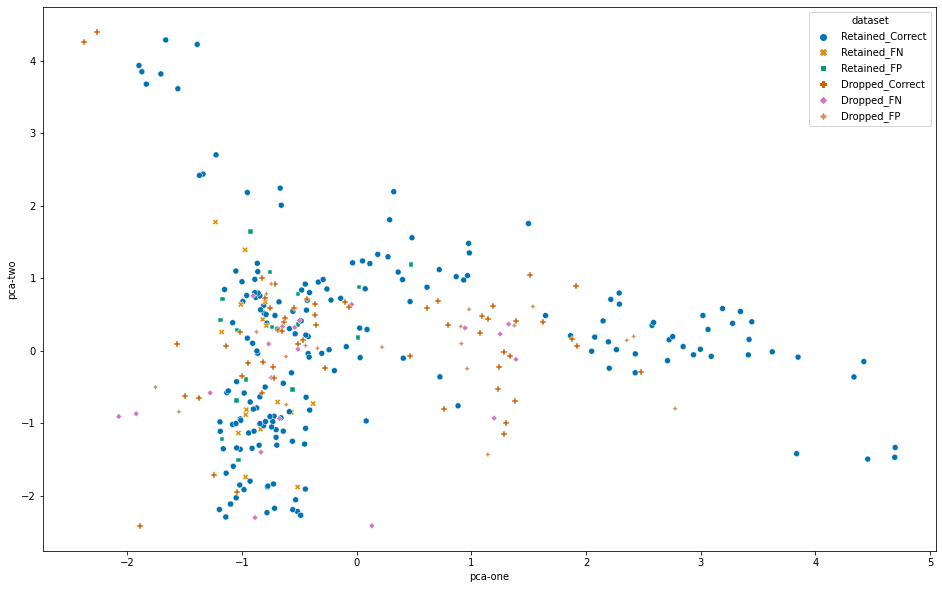

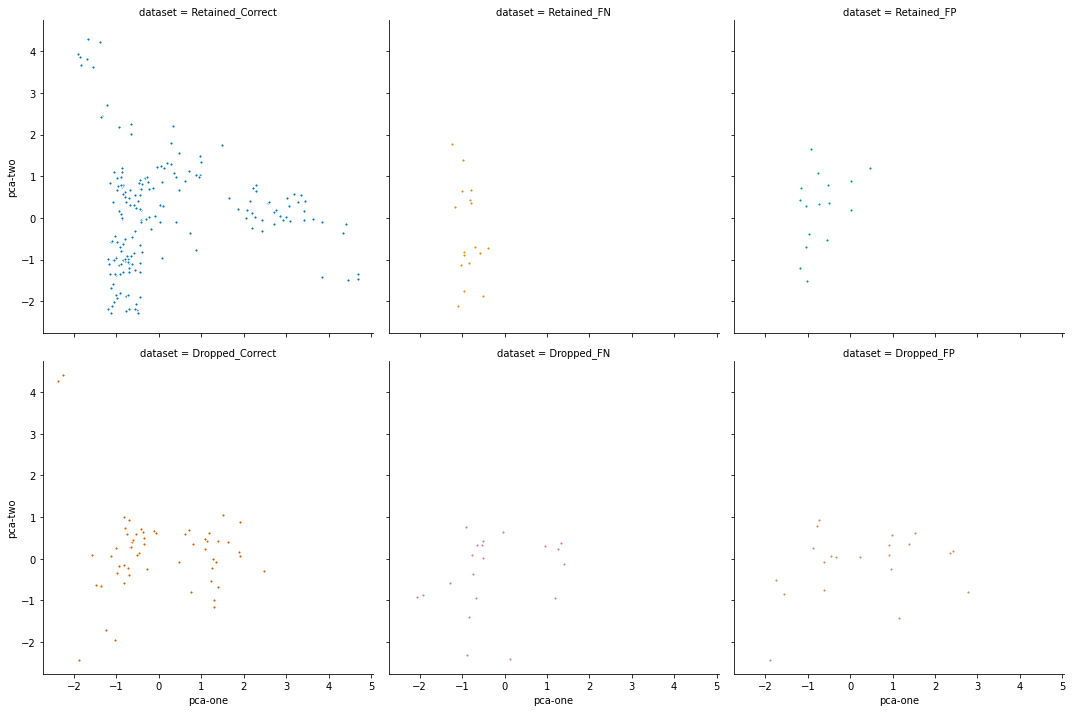


FINISHED


In [6]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

def input_to_pca_plot(input_df,ref_df,remove_misclassified=False):
    # Data should only contain the feature columns ie. no label column
#     print('\n#=========================================================================================#')
#     print('\n                                      RUNNING PCA for                                       \n')
#     print('                             ' + str(filename) + '                             ')
#     print('\n')
#     print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    
    if remove_misclassified == True:
        input_df_smi = input_df['SMILES'].tolist()
        ref_df_smi = ref_df['SMILES'].tolist()

        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))

        print('\nref_df no. of SMILES:')
        print(len(ref_df_smi))

        input_df_smi = [x for x in input_df_smi if x not in ref_df_smi]

    if remove_misclassified == False:       
        input_df_smi = input_df['SMILES'].tolist()
        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))
    
    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label for plotting later
        model_root_desc = 'V2.0.1 Reproductive toxicity'
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Reproductive toxicity'

        model_root_desc = 'V2.0.1 Developmental toxicity'    
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Developmental toxicity' 
                                
        else:
            new_col = 'Misclassified' 

        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    pca_dict={}
    ref_filename = root_desc[1]
    ref_df = pd.read_csv(ref_filename, sep=',')
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(filename, sep=',')
                     
        # Assign label for plotting later
        if index==0 and model_root_desc == 'V2.0.1 Reproductive toxicity':            
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Reproductive toxicity'
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
            
            continue

        if index==0 and model_root_desc == 'V2.0.1 Developmental toxicity':
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Developmental toxicity'             
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
          
            continue
        
        if index==0 and model_root_desc == 'V2.0.1 Unified data':
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=True)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'entire dataset'             
            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
          
            continue
        
        else:
            pca_results,to_concat = input_to_pca_plot(input_df,ref_df,filename,remove_misclassified=False)
            pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
            print(pca_df.head())
            
            new_col = 'Misclassified' 

            pca_df = pca_df.assign(dataset = new_col)    

            pca_dict[new_col] = pca_df
    
    return pca_dict,to_concat

def consensus_pca_main(input_df_filename,dropped_df_filename):
    pca_dict={}

    dropped_df = pd.read_csv(dropped_df_filename)
    dropped_df = dropped_df[['SMILES', 'Binary Activity_x','FN count','FP count','consensus_y_pred_0','consensus_y_pred_1']]
    # Get consensus binary classification for dropped_df
    consensus_ls = []
    for row in range(0,len(dropped_df)):
        # Use majority voting for consensus prediction 
        if dropped_df.loc[row]['consensus_y_pred_1'] >= dropped_df.loc[row]['consensus_y_pred_0']:
            consensus_ls.append(1)
        else:
            consensus_ls.append(0)
    dropped_df['Consensus'] = consensus_ls
    
    input_df = pd.read_csv(input_df_filename)
    
    try:
        dropped_df = dropped_df[dropped_df.columns.drop(list(dropped_df.filter(regex='Unnamed')))]
    except:
        pass
    
    try:
        input_df = input_df[input_df.columns.drop(list(input_df.filter(regex='Unnamed')))]
    except:
        pass
    
    print('\nINPUT_DF\n')
    print(input_df)
    print('\nDROPPED_DF\n')
    print(dropped_df)
    
    input_pca_results,input_to_concat = input_to_pca_plot(input_df,dropped_df,remove_misclassified=False)
    input_pca_df = pd.DataFrame(input_pca_results, columns = ['pca-one','pca-two'])
    print(input_pca_df.head())

    dropped_pca_results,dropped_to_concat = input_to_pca_plot(dropped_df,dropped_df,remove_misclassified=False)
    dropped_pca_df = pd.DataFrame(dropped_pca_results, columns = ['pca-one','pca-two'])
    print(dropped_pca_df.head())
    

    
    return input_pca_df,input_to_concat,dropped_pca_df,dropped_to_concat
#======================================================================================#

# Set filepaths for functions

total_runs = 1

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Reproductive toxicity'
save_desc = 'V2.0.1 Reproductive toxicity run 1 V2 consensus misclassification analysis'
# input_path = root + model_root_desc + '.csv'
model_desc = model_root_desc + ' ' + str(total_runs)

# This the processed test df without any dropped rows
input_df_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows misclassified predicted results.csv'

# This the df with dropped rows only
dropped_df_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows only misclassified predicted results.csv'


#======================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'


# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
# perplex_ls = [10,20,40,60,80]
# iterations = 5000
# iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
input_pca_df,input_to_concat,dropped_pca_df,dropped_to_concat = consensus_pca_main(input_df_filename,
                                                                                   dropped_df_filename)

# Process dfs from consensus code and assign labels for plotting pca plots
# Plots should have original data w/o dropped data (misclassified + classified correctly)
# Total for this part should have 4 grids in the facet plots
# Also get labels for FN and FP for later plots
input_label_ls = []
for x in range(0,len(input_to_concat)):
    if input_to_concat.loc[x]['FN count'] == 24:
        input_label_ls.append('Retained_FN')
    elif input_to_concat.loc[x]['FP count'] == 24:
        input_label_ls.append('Retained_FP')
    else:
        input_label_ls.append('Retained_Correct')
input_pca_df['dataset'] = input_label_ls   


dropped_label_ls = []
for x in range(0,len(dropped_to_concat)):
    if dropped_to_concat.loc[x]['Consensus'] == dropped_to_concat.loc[x]['Binary Activity_x']:
        dropped_label_ls.append('Dropped_Correct')
    else:
        if dropped_to_concat.loc[x]['Binary Activity_x'] == 0 and dropped_to_concat.loc[x]['Consensus'] == 1:
            dropped_label_ls.append('Dropped_FP')
        else:
            dropped_label_ls.append('Dropped_FN')
dropped_pca_df['dataset'] = dropped_label_ls   
     

pca_concatenated = pd.concat([input_pca_df,dropped_pca_df],ignore_index=False)
pca_concatenated = pca_concatenated.reset_index(drop=True)
print(pca_concatenated)

future_analysis_df = pd.concat([input_pca_df,input_to_concat],axis=1)
future_analysis_df = future_analysis_df[['pca-one','pca-two','dataset','SMILES','consensus_y_pred_0',
                                        'consensus_y_pred_1','Consensus']]
temp_df = pd.concat([dropped_pca_df,dropped_to_concat],axis=1)
temp_df = temp_df[['pca-one','pca-two','dataset','SMILES','consensus_y_pred_0',
                  'consensus_y_pred_1','Consensus']]
print(temp_df)
future_analysis_df = pd.concat([future_analysis_df,temp_df],ignore_index=False)
future_analysis_df = future_analysis_df.reset_index(drop=True)
print('\nFUTURE ANALYSIS\n')
print(future_analysis_df)
future_analysis_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'
future_analysis_df.to_csv(future_analysis_save)

# pca_concatenated = pd.concat(pca_dict.values(), sort=False, ignore_index=False)  
# pca_concatenated.columns= ['pca-one','pca-two','dataset']

plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_concatenated,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 3             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_concatenated, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')


INPUT DF

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1     

C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


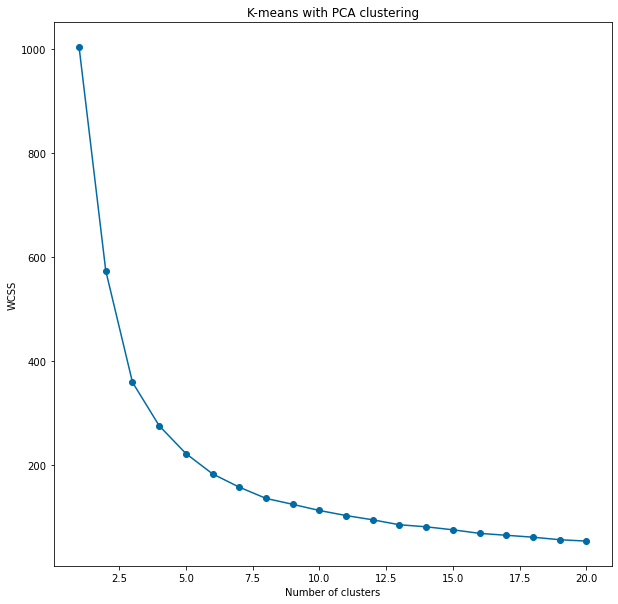

[[-1.33213155 -0.32138787]
 [ 0.22311058 -0.98880737]
 [ 1.31207079  1.38063757]
 [-1.20702938  1.19479297]
 [ 0.96547961  0.02740528]]
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3          

In [52]:
# Code to cluster with kmeans from PCA plot

import pandas as pd
import numpy as np

import math
from math import sqrt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numpy import unique
from numpy import where
#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)
input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'
# ' V2 future analysis misclassified predicted results.csv'

insert = ' Dropped only elbow_fig'
insert2 = ' Dropped only_fig'
kmeans_analysis_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'

consensus_groupby_cluster_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 K-means distance groupby cluster misclassifion analysis.csv'
consensus_groupby_consensus_save = root + 'Feature plots/kmeans/' +  model_desc + ' V2 K-means distance groupby consensus_no misclassifion analysis.csv'

elbow_fig_filename = root + 'Feature plots/' +  model_desc + insert + ' V2 K-means PCA misclassifion analysis.tiff'
output_fig_all_filename = root + 'Feature plots/' +  model_desc + insert2 + ' all V2 K-means PCA misclassifion analysis.tiff'

initial_df = pd.read_csv(input_filename)

try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass
# print('INITIAL DF\n')
# print(initial_df)

# adjust rows of input_df to get desired pca plots
# input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]
# input_df = initial_df[(initial_df.dataset == 'Retained_FP') | (initial_df.dataset == 'Retained_FN')| (initial_df.dataset == 'Retained_Correct')]
input_df = initial_df
print('INPUT DF\n')
print(input_df)


# Clustering
# WCSS - Within cluster sum of squares
n_clusters = 20
wcss = []
for i in range(1,n_clusters+1):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state = 42)
    kmeans_pca.fit(input_df[['pca-one','pca-two']])
    wcss.append(kmeans_pca.inertia_)

# Plot graph to look for optimal cluster number using elbow method
plt.figure(figsize = (10,10))                        
plt.plot(range(1,n_clusters+1),wcss,marker='o',linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA clustering')
# plt.savefig(elbow_fig_filename)
plt.show()

# Use optimal cluster number here
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state = 42)
kmeans_pca.fit(input_df[['pca-one','pca-two']])

# Print centroid coordinates/position
centroids = kmeans_pca.cluster_centers_
print(centroids)

kmeans_analysis_df = input_df.copy()
kmeans_analysis_df['Cluster'] = kmeans_pca.labels_
print(kmeans_analysis_df)
kmeans_analysis_df.to_csv(kmeans_analysis_save)

# Process kmeans_analysis_df for sum of squares of each data point (Euclidean distance)
# This is to see if a misclassified data point will be further away within a cluster
def calc_sum_of_squares(x,y,centroid_x,centroid_y):
    dist = sqrt(((x-centroid_x)**2)+((y-centroid_y)**2))
    return dist

SS = []
for x in range(0,len(kmeans_analysis_df)):
    cluster_no = kmeans_analysis_df.loc[x]['Cluster']
    centroid_coords = centroids[cluster_no]
    centroid_x = centroid_coords[0]
    centroid_y = centroid_coords[1]
    input_x = kmeans_analysis_df.loc[x]['pca-one']
    input_y = kmeans_analysis_df.loc[x]['pca-two']
#     print(input_x,input_y,centroid_x,centroid_y)
    SS.append(calc_sum_of_squares(input_x,input_y,centroid_x,centroid_y))

distance_analysis_df = kmeans_analysis_df.copy()
distance_analysis_df['sum of squares'] = SS
distance_analysis_df['Consensus_no'] = distance_analysis_df[['consensus_y_pred_0','consensus_y_pred_1']].max(axis=1)
distance_analysis_df = distance_analysis_df[['Consensus_no','Cluster','sum of squares']]
print('\nDISTANCE ANALYSIS')
print(distance_analysis_df)

# Groupby number of consensus models (Consensus_no)
# This calculates the mean sum of squares per consensus number
distance_groupby_cluster = distance_analysis_df.groupby(['Cluster','Consensus_no'])
print(distance_groupby_cluster.mean())
distance_groupby_cluster.mean().to_csv(consensus_groupby_cluster_save)
distance_analysis_df = distance_analysis_df[['Consensus_no','sum of squares']]
distance_groupby_consensus = distance_analysis_df.groupby(['Consensus_no'])
print(distance_groupby_consensus.mean())
distance_groupby_consensus.mean().to_csv(consensus_groupby_consensus_save)


# For 2D plots
# x_axis = kmeans_analysis_df['pca-one']
# y_axis = kmeans_analysis_df['pca-two']
# plt.figure(figsize = (10,8))    
# sns.scatterplot(x_axis, y_axis, hue = kmeans_analysis_df['Cluster no.'], palette = 'colorblind')
# plt.title('K-means clusters with PCA')
# plt.show()


# For 3D plots
# sns.set(style = "darkgrid")
def plot_cluster():
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlabel("pca-one")
    ax.set_ylabel("pca-two")
    ax.set_zlabel("Cluster")
    df = kmeans_analysis_df.copy()
    df.columns = ['pca_one','pca_two','dataset','SMILES','Cluster']
    # df = df[df.Cluster == 2]
    for s in df.dataset.unique():
        ax.scatter(df.pca_one[df.dataset==s],df.pca_two[df.dataset==s],df.Cluster[df.dataset==s],label=s)
    ax.legend()
    ax.view_init(20, -30)
    plt.style.use('tableau-colorblind10')
    # plt.savefig(output_fig_all_filename)
    plt.show()

# plot_cluster()    
    
# Another 3D plot to show certain cluster of data
def show_cluster(cluster_no):
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlabel("pca-one")
    ax.set_ylabel("pca-two")
    ax.set_zlabel("Cluster")
    ax.set_xticks(np.arange(-2, 3, 0.5))
    ax.set_yticks(np.arange(-2, 4, 0.5))
    ax.set_zticks(np.arange(0, 5, 0.5))
    df = kmeans_analysis_df.copy()
    df.columns = ['pca_one','pca_two','dataset','SMILES','Cluster']
    zoom_df = df[df.Cluster == cluster_no]
    for s in df.dataset.unique():
        ax.scatter(zoom_df.pca_one[zoom_df.dataset==s],zoom_df.pca_two[zoom_df.dataset==s],
                   zoom_df.Cluster[zoom_df.dataset==s],label=s)
    ax.legend()
    ax.view_init(20, -30)
    plt.style.use('tableau-colorblind10')
    output_fig_filename = root + 'Feature plots/' +  model_desc + insert2 + ' C' + str(cluster_no) + \
    ' V2 K-means PCA misclassifion analysis.tiff'
    plt.savefig(output_fig_filename)
    plt.show()

# for cluster_no in range(0,5):
#     show_cluster(cluster_no)


print('\nFINISHED')

In [100]:
# For calculating the average similarity per molecule for the 5 nearest neighbours in both the training and the test sets

import pandas as pd
import numpy as np


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit import DataStructs

from statistics import mean

#===================================================================================#
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,fingerprint_radius,nBits=nBits)
    
    return fp


#==============================================================================================#
def calc_Tanimoto_similarity(smiles1,smiles2):
    fp1 = get_Morgan_fingerprint(smiles1,2048,2)
    fp2 = get_Morgan_fingerprint(smiles2,2048,2)
    similarity = DataStructs.FingerprintSimilarity(fp1,fp2,metric=DataStructs.TanimotoSimilarity)
    
    return similarity

#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Developmental toxicity'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)

input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'

training_input_filename = root + 'AutoML models/' +  model_desc + \
'/Data/V2.0.1 Developmental toxicity 1 CSV train.csv'
# training_input_filename = root + 'AutoML models/' +  model_desc + \
# '/Data/V2.0.1 Reproductive toxicity 1 CSV train.csv'

kmeans_analysis_input = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'

final_analysis_save = root + 'Similarities/' +  model_desc + \
' V2 training and test similarity pair analysis.csv'

merged_df_save = root + 'Similarities/' +  model_desc + \
' V2 merged training and test similarity pair analysis.csv'

# Sometimes csv saves but columns load incorrectly when opening with excel
# This mitigates the issue entierly by directly saving as xlsx
merged_df_save_xlsx = root + 'Similarities/' +  model_desc + \
' V2 merged training and test similarity pair analysis.xlsx'
#===================================================================================#

initial_df = pd.read_csv(input_filename)

try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass

kmeans_analysis_input_df = pd.read_csv(kmeans_analysis_input)

try:
    kmeans_analysis_input_df = kmeans_analysis_input_df[kmeans_analysis_input_df.columns.drop(list(kmeans_analysis_input_df.filter(regex='Unnamed')))]
except:
    pass
print(kmeans_analysis_input_df)

training_df = pd.read_csv(training_input_filename)

try:
    training_df = training_df[training_df.columns.drop(list(training_df.filter(regex='Unnamed')))]
except:
    pass
print('TRAINING DF\n')
print(training_df)


# adjust rows of input_df if necessary
# input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]
# input_df = initial_df[(initial_df.dataset == 'Retained_FP') | (initial_df.dataset == 'Retained_FN')| (initial_df.dataset == 'Retained_Correct')]

input_df = initial_df
print('INPUT DF\n')
print(input_df)

#===================================================================================#
# Get list of Tanimoto similarities per moelcule in the dataset
# test_smiles_df = input_df[['SMILES']]
training_smiles_df = training_df[['SMILES']]
smiles_df_ls = []

    # If calculating within training set
# for x in range(0,len(training_smiles_df)):
#     copy_df = training_smiles_df.copy()
#     copy_df = copy_df.drop([x], axis=0)

for x in range(0,len(test_smiles_df)):
    
    # If calculating between training and test set
    copy_df = training_smiles_df.copy()    
    
    # If calculating within test set
#     copy_df = test_smiles_df.copy()
#     copy_df = copy_df.drop([x], axis=0)
    
    # Calculate list of Tanimoto similarities
    similarity_ls = []
    smiles1 = test_smiles_df.loc[x]['SMILES']
#     smiles1 = training_smiles_df.loc[x]['SMILES']
    for index, row in copy_df.iterrows():
        smiles2 = row['SMILES']
        similarity_ls.append(calc_Tanimoto_similarity(smiles1,smiles2))
        if len(similarity_ls) % 150 == 0 and x % 100 == 0:
            print('\nNOW PROCESSING INDEX {} IN COPY_DF FOR MOLECULE {}'.format(index,x))
            print(len(similarity_ls),'SIMILARITY PAIRS CALCULATED')
    smiles_df_ls.append(similarity_ls)
        
final_analysis_df = input_df.copy()
# final_analysis_df = training_smiles_df.copy()
final_analysis_df['similarity'] = smiles_df_ls
final_analysis_df = final_analysis_df[['SMILES','similarity']]
# print(final_analysis_df)
final_analysis_df.to_csv(final_analysis_save)

# Merge cluster information from kmeans with similarity
merged_df = kmeans_analysis_input_df.merge(final_analysis_df, on="SMILES", how="inner")
# merged_df = final_analysis_df.copy()

# Get average similarity and average of top 1,3,5 similarity per compound
average_sim = []
top_1 = []
top_3 = []
top_5 = []

for index, row in merged_df.iterrows():
    to_process = row['similarity']
    to_process = sorted(to_process, reverse=True)
    
    average_sim.append(mean(to_process))
    top_1.append(to_process[0])
    top_3.append(mean(to_process[0:3]))
    top_5.append(mean(to_process[0:5]))
    
    
merged_df['average_sim'] = average_sim
merged_df['top_1'] = top_1
merged_df['top_3'] = top_3
merged_df['top_5'] = top_5

print('\nMERGED')
print(merged_df)
merged_df.to_csv(merged_df_save,sep=';')

print('\nFINISHED')

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1               


NOW PROCESSING INDEX 1499 IN COPY_DF FOR MOLECULE 300
1500 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 1649 IN COPY_DF FOR MOLECULE 300
1650 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 149 IN COPY_DF FOR MOLECULE 400
150 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 299 IN COPY_DF FOR MOLECULE 400
300 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 449 IN COPY_DF FOR MOLECULE 400
450 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 599 IN COPY_DF FOR MOLECULE 400
600 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 749 IN COPY_DF FOR MOLECULE 400
750 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 899 IN COPY_DF FOR MOLECULE 400
900 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 1049 IN COPY_DF FOR MOLECULE 400
1050 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 1199 IN COPY_DF FOR MOLECULE 400
1200 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 1349 IN COPY_DF FOR MOLECULE 400
1350 SIMILARITY PAIRS CALCULATED

NOW PROCESSING INDEX 1499 IN COPY_DF FOR MO

In [101]:
print(merged_df)
# merged_df_save_xlsx = root + 'Similarities/' +  model_desc + \
# ' V2 merged within training similarity pair analysis.xlsx'
# merged_df.to_csv(merged_df_save,sep=';')
merged_df.to_excel(merged_df_save_xlsx, index=True)

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1               

In [102]:
# Process merged_df if doing train test pairs to get top similar structure in training set
merged_df_save2 = root + 'Similarities/' +  model_desc + \
' V2 sorted merged training and test similarity pair analysis.csv'

# merged_smiles_ls = input_df['SMILES']
merged_smiles_ls = training_df['SMILES']
print(len(merged_smiles_ls))
sorted_SMILES = []
sorted_similarity = []
for index,row in merged_df.iterrows():
    to_sort = row['similarity']
#     print(to_sort)
    # Get top 5 indices and values for similarity pairs
    sorted_tuple = sorted(enumerate(to_sort), reverse=True, key=lambda x: x[1])[:5]
#     print(sorted_tuple)
    indices,value = [list(ele) for ele in zip(*sorted_tuple)]
#     index = [index for index, value in sorted(enumerate(to_sort), reverse=True, key=lambda x: x[1])[:6]
             
    # Get corresponding SMILES as list
#     print(indices)
#     print(value)
    temp = [merged_smiles_ls[i] for i in indices]  
    sorted_SMILES.append(temp)
    sorted_similarity.append(value)
    
merged_df['sorted_SMILES'] = sorted_SMILES
merged_df['sorted_similarity'] = sorted_similarity
                   
print('\nMERGED')
print(merged_df)
merged_df.to_csv(merged_df_save2)

merged_df_save_xlsx2 = root + 'Similarities/' +  model_desc + \
' V2 sorted merged training and test similarity pair analysis.xlsx'
merged_df.to_excel(merged_df_save_xlsx2, index=True)
print('\nFINISHED')

1779

MERGED
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1  

INITIAL DF

      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
1    0.083917 -0.751879  Retained_Correct   
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
..        ...       ...               ...   
440  0.798673 -0.807198   Dropped_Correct   
441 -0.204978  2.051749   Dropped_Correct   
442 -1.538824 -0.840614        Dropped_FP   
443 -0.250589 -1.264948   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
0    CCC1=CC(=CC2=C1OCO2)C1=C(N(C2=CC=CC=C2C(F)(F)F...                  24   
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0   
4                            CCSCC1=C(OC(=O)NC)C=CC=C1   

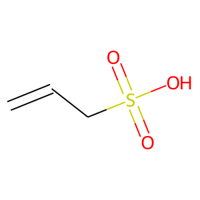

CCCCCCCCC


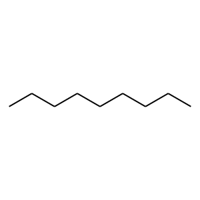

OC1CCCCC1


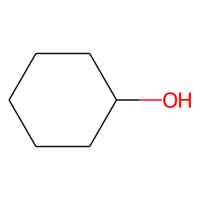


DF STATS FOR CLUSTER:  1
                  dataset
Retained_Correct       42
Dropped_Correct        35
Dropped_FN             15
Retained_FP            13
Retained_FN            10
Dropped_FP              7

DF FOR CLUSTER:  1
      pca-one   pca-two           dataset  \
1    0.083917 -0.751879  Retained_Correct   
9   -0.153003 -1.115271  Retained_Correct   
14   0.604709 -0.942444  Retained_Correct   
17   0.110476 -0.555948  Retained_Correct   
20  -0.183259 -0.426532       Retained_FN   
..        ...       ...               ...   
429  0.173685 -1.477351   Dropped_Correct   
434  0.360120 -0.786074   Dropped_Correct   
438  0.514719 -0.598634        Dropped_FP   
440  0.798673 -0.807198   Dropped_Correct   
443 -0.250589 -1.264948   Dropped_Correct   

                                                SMILES  consensus_y_pred_0  \
1               NC1=C2N=CN(C3OC(CO)C(O)C3O)C2=NC(F)=N1                   0   
9                CCCCC(CN1C=NC=N1)(C#N)C1=CC=C(Cl)C=C1                   0 

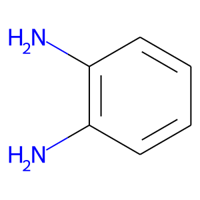

CN1COCN(CC2=CN=C(Cl)S2)C1=N[N+]([O-])=O


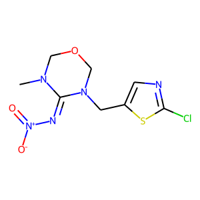

N1C2=C(C=CC=C2)N=C1C1=CSC=N1


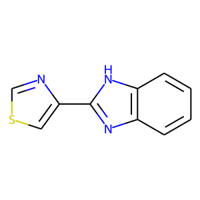

CN=C1C=NN(C2=CC=CC(=C2)C(F)(F)F)C(=O)C1Cl


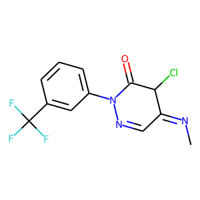


DF STATS FOR CLUSTER:  2
                  dataset
Retained_Correct       26
Dropped_Correct        10
Dropped_FN              8
Dropped_FP              6
Retained_FP             3

DF FOR CLUSTER:  2
      pca-one   pca-two           dataset  \
0    1.379727  0.893448  Retained_Correct   
18   1.957215  0.843974       Retained_FP   
31   1.491808  1.555686  Retained_Correct   
38   2.638923  1.127704  Retained_Correct   
54   1.183021  1.636007  Retained_Correct   
59   1.111905  2.401148  Retained_Correct   
60   1.153915  1.498573  Retained_Correct   
66   1.935119  1.489508  Retained_Correct   
67   1.176726  1.293635  Retained_Correct   
93   0.737724  1.030872  Retained_Correct   
103  0.552456  0.921006  Retained_Correct   
106  0.457656  2.173729       Retained_FP   
110  2.432820  1.445569  Retained_Correct   
112  0.904111  1.329701  Retained_Correct   
130  0.308920  1.485872  Retained_Correct   
133  0.734142  1.622138  Retained_Correct   
136  0.340319  1.068258  Retained

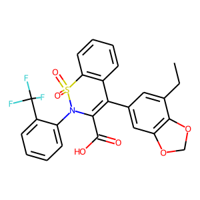


DF STATS FOR CLUSTER:  3
                  dataset
Retained_Correct       28
Dropped_Correct        19
Dropped_FP              8
Dropped_FN              5
Retained_FP             2
Retained_FN             1

DF FOR CLUSTER:  3
      pca-one   pca-two           dataset  \
7   -0.386477  1.355356  Retained_Correct   
8   -1.459516  0.920361  Retained_Correct   
10  -1.447254  0.771084  Retained_Correct   
16  -1.728202  0.922581  Retained_Correct   
21  -0.081931  1.095010  Retained_Correct   
..        ...       ...               ...   
411 -0.855279  2.667514        Dropped_FP   
413 -1.146651  1.118501        Dropped_FP   
420 -1.273254  1.511069   Dropped_Correct   
426 -1.007387  0.634130        Dropped_FP   
441 -0.204978  2.051749   Dropped_Correct   

                                             SMILES  consensus_y_pred_0  \
7                          CC(CS)C(=O)N1CCCC1C(O)=O                   0   
8                                    COCC(C)OC(C)=O                  24   
10    

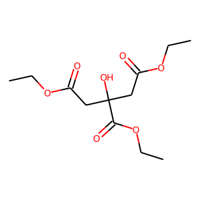


DF STATS FOR CLUSTER:  4
                  dataset
Retained_Correct       44
Dropped_Correct        31
Dropped_FN             14
Dropped_FP              9
Retained_FN             8
Retained_FP             5

DF FOR CLUSTER:  4
      pca-one   pca-two           dataset  \
2    0.819874  0.294594       Retained_FP   
3    0.223988  0.278026  Retained_Correct   
4    0.253904  0.625714  Retained_Correct   
5    1.062014  0.387518  Retained_Correct   
6    1.827932 -0.717198  Retained_Correct   
..        ...       ...               ...   
427  0.560824 -0.331304        Dropped_FN   
428  1.764330 -0.988543        Dropped_FP   
431  1.852283  0.071495        Dropped_FN   
437  0.596632 -0.238501   Dropped_Correct   
444  1.311813  0.541344        Dropped_FN   

                                                SMILES  consensus_y_pred_0  \
2                         NC(CC1=CNC2=CC=CC=C12)C(O)=O                   0   
3                       CC(C)NCC(O)COC1=C2C=CNC2=CC=C1                   0 

In [58]:
# For drawing structures in clusters based on criteria
import pandas as pd
import numpy as np

import os

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numpy import unique
from numpy import where
#===================================================================================#
# Data
total_runs = 1
n_clusters = 5
root = 'C:/Users/mwhw3/Desktop/DART project/'
# toxicity = 'Reproductive toxicity'
toxicity = 'Developmental toxicity'
model_root_desc = 'V2.0.1 '+ toxicity
model_desc = model_root_desc + ' ' + str(total_runs)
# input_filename = root + 'Feature plots/kmeans/' +  model_desc + ' V2 all K-means PCA misclassifion analysis.csv'
input_filename = root + 'Similarities/' +  model_desc + \
' V2 merged similarity analysis.csv'
#===================================================================================#
initial_df = pd.read_csv(input_filename)
try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass
print('INITIAL DF\n')
print(initial_df)
# query_ls = list(initial_df['dataset'].unique())

# Create folders for dropped and retained for each toxicity
dir_path = root + 'Mols images/'+ toxicity +'Retained_classification/'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

dir_path = root + 'Mols images/'+ toxicity +'Dropped_classification/'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

def make_cluster_dirs(classification,cluster):
    # Create new folders if it doesn't exist to store mols images
    # Main folder per cluster  
    
    cluster_dir_path = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/'
    if not os.path.exists(cluster_dir_path):
        os.makedirs(cluster_dir_path)
        
    # Create two more folders to store FN and FN mols images
    FNpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'FN/'
    if not os.path.exists(FNpath):
        os.makedirs(FNpath)
        
    FPpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'FP/'
    if not os.path.exists(FPpath):
        os.makedirs(FPpath)
    
    Correctpath = root + 'Mols images/'+ toxicity + classification + '/Cluster_' + str(cluster) + '/' + 'Correct/'
    if not os.path.exists(Correctpath):
        os.makedirs(Correctpath)
    
    return

def set_cluster_dirs(cluster):       
    Dropped_FNpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'FN/'        
    Dropped_FPpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'FP/'    
    Dropped_Correctpath = root + 'Mols images/'+ toxicity + 'Dropped_classification/Cluster_' + str(cluster) + '/' + 'Correct/'    
     
    Retained_FNpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'FN/'        
    Retained_FPpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'FP/'    
    Retained_Correctpath = root + 'Mols images/'+ toxicity + 'Retained_classification/Cluster_' + str(cluster) + '/' + 'Correct/'        
    
    return Dropped_FNpath,Dropped_FPpath,Dropped_Correctpath,Retained_FNpath,Retained_FPpath,Retained_Correctpath
    
for cluster in range(0,n_clusters):
    df = initial_df[initial_df.Cluster == cluster]
    new_df = pd.DataFrame(df['dataset'].value_counts())
    print('\nDF STATS FOR CLUSTER: ',cluster)
    print(new_df)

    make_cluster_dirs('Retained_classification',cluster)
    make_cluster_dirs('Dropped_classification',cluster)
    
    Dropped_FNpath,Dropped_FPpath,Dropped_Correctpath,Retained_FNpath,Retained_FPpath,Retained_Correctpath = set_cluster_dirs(cluster)
        
    # Drawing mols
    print('\nDF FOR CLUSTER: ',cluster)
#     query_df = df.reset_index(drop=True)
    query_df = df.copy()
    print(query_df)
    
    for index, row in query_df.iterrows():
        query_smiles = row['SMILES']

        m = Chem.MolFromSmiles(query_smiles,sanitize=True)
#         m.UpdatePropertyCache(strict=False)
        img = Draw.MolToImage(m,kekulize=True)
        img = img.resize((200,200))
        
        if row['dataset'] == 'Dropped_FN':
            img_savepath = Dropped_FNpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Dropped_FP':
            img_savepath = Dropped_FPpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Dropped_Correct':
            img_savepath = Dropped_Correctpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
            
        if row['dataset'] == 'Retained_FN':
            img_savepath = Retained_FNpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Retained_FP':
            img_savepath = Retained_FPpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)
        if row['dataset'] == 'Retained_Correct':
            img_savepath = Retained_Correctpath + 'img ' + str(index) + '.tiff'
            img.save(img_savepath)        
        
        if index % 50 == 0:
            print(query_smiles)
            display(img)

print('\nFINISHED')

In [122]:
# Code for plotting histogram

import pandas as pd
import numpy as np

import seaborn as sns

from IPython.display import SVG

from PIL import Image

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


#===================================================================================#
# Data
total_runs = 1
root = 'C:/Users/mwhw3/Desktop/DART project/'
# model_root_desc = 'V2.0.1 Reproductive toxicity'
model_root_desc = 'V2.0.1 Developmental toxicity'
model_desc = model_root_desc + ' ' + str(total_runs)
input_filename = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 future analysis for histogram misclassified predicted results.csv'

count_df_save = root + 'AutoML models combined interpreting predicted results/' +  model_desc + \
' V2 dropped rows count.xlsx'


initial_df = pd.read_csv(input_filename)
try:
    initial_df = initial_df[initial_df.columns.drop(list(initial_df.filter(regex='Unnamed')))]
except:
    pass



#===================================================================================#
initial_df = initial_df[['dataset','consensus_y_pred_0','consensus_y_pred_1']]
input_df = initial_df[(initial_df.dataset == 'Dropped_FP') | (initial_df.dataset == 'Dropped_FN')| (initial_df.dataset == 'Dropped_Correct')]

# get model_count column for histogram
model_count_ls = []

def model_count(row):
    if row['consensus_y_pred_1'] >= row['consensus_y_pred_0']:
        return row['consensus_y_pred_1']
    else:
        return -row['consensus_y_pred_0']

def plot_hist():
    sns.set()

    fig = sns.histplot(data = initial_df
                ,x = 'model_count'
                ,palette ='colorblind' 
                ,alpha = .7
                ,hue = 'dataset'
                ,binwidth = 1
                ,multiple="stack"
                ,discrete = True
                )

    output_fig_filename = root + 'Feature plots/' +  model_desc +  \
    ' V2 histogram misclassified predicted results.tiff'
    plt.savefig(output_fig_filename)
    plt.show()

def absolute_count(row):
    return int(abs(row['model_count']))

input_df['model_count'] = input_df.apply(model_count, axis=1)
input_df['absolute_model_count'] = input_df.apply(absolute_count, axis=1)
print(input_df)
print(len(input_df)/len(initial_df)*100)

no_of_models_ls = []
count_ls = []
for no_of_models in range(12,25):
    count = 0
    
    for index,row in input_df.iterrows():
        if int(row['absolute_model_count']) < no_of_models:
            count += 1
            
    count_ls.append(count)
    no_of_models_ls.append(no_of_models)
    
count_df = pd.DataFrame(no_of_models_ls,columns=['no_of_models'])
count_df['dropped_row_count'] = count_ls
print(count_df)
count_df.to_excel(count_df_save)
    
print('\nFINISHED')

             dataset  consensus_y_pred_0  consensus_y_pred_1  model_count  \
231  Dropped_Correct                   3                  21           21   
232  Dropped_Correct                   7                  17           17   
233  Dropped_Correct                  16                   8          -16   
234       Dropped_FN                  22                   2          -22   
235  Dropped_Correct                   1                  23           23   
..               ...                 ...                 ...          ...   
440  Dropped_Correct                   1                  23           23   
441  Dropped_Correct                  10                  14           14   
442       Dropped_FP                   1                  23           23   
443  Dropped_Correct                   1                  23           23   
444       Dropped_FN                  16                   8          -16   

     absolute_model_count  
231                    21  
232                

C:\Users\mwhw3\Anaconda3\envs\my-rdkit-env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Code to construct feature plots for misclassified data only. This will show the distinction between the false positive and false negative compounds. The code will also count the number of false positives and false negatives across all runs and group them.


#=========================================================================================#

                                      RUNNING PCA for                                       

                             C:/Users/mwhw3/Desktop/DART project/AutoML models combined interpreting predicted results/V2.0.1 Unified data 5 misclassified predicted results.csv                             


#=========================================================================================#


input_df no. of SMILES:
658
658
   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     1     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  

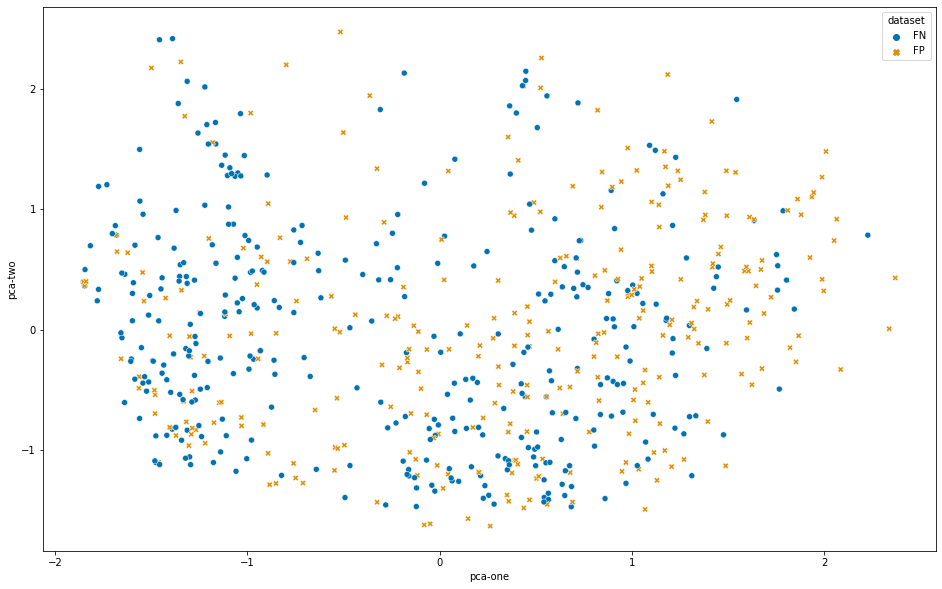

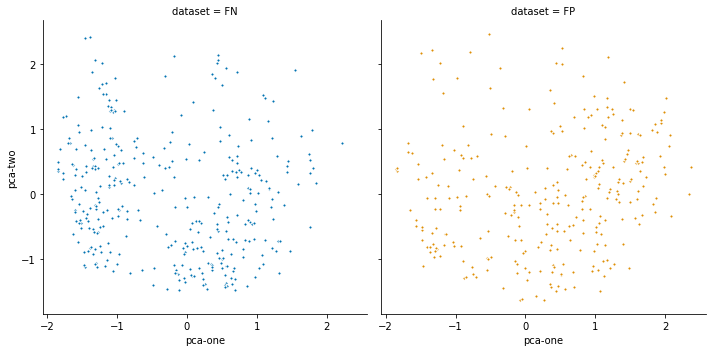


FINISHED


In [123]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# This function gets the Morgan fingeprint given a SMILES dataframe and specified fingerprint parameters
def get_Morgan_fingerprint(smiles,nBits,fingerprint_radius):
    
    '''smiles dataframe'''
    error_idx_ls =[]
    error_idx_ls.clear()
    
    rdkit_molecules=[Chem.MolFromSmiles(x) for x in smiles]
    print(len(rdkit_molecules))
    rdkit_fingerprint=[]
    count = 0
    fingerprint_length = int(nBits)
    #print(rdkit_molecules[:1])
    for mol in rdkit_molecules:
        # if count % 1000 == 0:
        #     print('Now fingerprinting {} of {}'.format(count,len(rdkit_molecules)))
        bit_info={}
        try:
            fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius, nBits=fingerprint_length,
                                                          bitInfo=bit_info)
        except:
            # get indexes of errors with errors
            error_idx_ls.append(rdkit_molecules.index(mol))

        rdkit_fingerprint.append(fp)
        count += 1
        
    fingerprint_df=pd.DataFrame([np.array(list(x)).astype(int) for x in rdkit_fingerprint])
    #fingerprint_df = pd.DataFrame(rdkit_fingerprint,columns=['BV'])
    
    return fingerprint_df, error_idx_ls


#==============================================================================================#
#==============================================================================================#
# Functions
def input_to_tsne_plot(input_df,filename,perplex,iterations):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING t-SNE for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    input_df_smi = input_df['SMILES'].tolist()
    print('\ninput_df no. of SMILES:')
    print(len(input_df_smi))

    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    tsne = TSNE(n_components=2, perplexity=perplex,n_iter=iterations,verbose=1)
    tsne_results = tsne.fit_transform(plot_data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results,to_concat

def input_to_pca_plot(input_df,filename,remove_misclassified=False):
    # Data should only contain the feature columns ie. no label column
    print('\n#=========================================================================================#')
    print('\n                                      RUNNING PCA for                                       \n')
    print('                             ' + str(filename) + '                             ')
    print('\n')
    print('#=========================================================================================#\n')
#     input_df['SMILES'].replace('', np.nan, inplace=True)
#     input_df.dropna(subset=['SMILES'], inplace=True)
#     input_df = input_df.drop_duplicates(subset=['SMILES'], keep='first', inplace=False)

    to_concat = input_df
    
    if remove_misclassified == True:
        input_df_smi = input_df['SMILES'].tolist()
        ref_df_smi = ref_df['SMILES'].tolist()

        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))

        print('\nref_df no. of SMILES:')
        print(len(ref_df_smi))

        input_df_smi = [x for x in input_df_smi if x not in ref_df_smi]

    if remove_misclassified == False:       
        input_df_smi = input_df['SMILES'].tolist()
        print('\ninput_df no. of SMILES:')
        print(len(input_df_smi))
    
    plot_data,error_idx_ls = get_Morgan_fingerprint(input_df_smi,2048,2)
#     plot_data = plot_data.drop(error_idx_ls)
#     to_concat = to_concat.drop(error_idx_ls)
#     to_concat = to_concat.reset_index(drop=True)
    print(plot_data.head())

    # t-SNE
    time_start = time.time()
    # This gives an ndarray of n samples and 2 columns
    pca = PCA(n_components = 2)
    pca_results = pca.fit_transform(plot_data)
    print('\nPercentage variance explained: {}'.format(pca.explained_variance_))
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return pca_results,to_concat

def tsne_main(root_desc,perplex,iterations):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    tsne_dict={}
    for filename in root_desc:
        index = root_desc.index(filename)

        input_df = pd.read_csv(input_path, sep=',')

        tsne_results,to_concat = input_to_tsne_plot(input_df,filename,perplex,iterations)

        tsne_df = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])
        print(tsne_df.head())

        # Assign label for plotting later
        model_root_desc = 'V2.0.1 Reproductive toxicity'
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Reproductive toxicity'

        model_root_desc = 'V2.0.1 Developmental toxicity'    
        filepath = root + model_root_desc + '.csv'
        if filename == filepath:
            new_col = 'Developmental toxicity' 
                                
        else:
            new_col = 'Misclassified' 

        tsne_df = tsne_df.assign(dataset = new_col)    

        tsne_dict[new_col] = tsne_df
    
    return tsne_dict,to_concat

def pca_main(root_desc):
    root = 'C:/Users/mwhw3/Desktop/DART project/'
    for filename in root_desc:
        input_df = pd.read_csv(filename, sep=',')

        # Assign label for plotting later

        pca_results,to_concat = input_to_pca_plot(input_df,filename,remove_misclassified=False)
        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        print(pca_df.head())

        # Process to_concat for labels and to get counts of FP and FN

        overall_label = []
        overall_label.clear()

        to_concat = to_concat.drop(columns=['Unnamed: 0'])      
        
        # Add new column counting number of misclassifications
        # Subtract 1 becasue of SMILES column
        to_concat['Misclass count'] = to_concat.count(axis=1).subtract(1) 
            
        # Add new column for overall label of compound 
        for x in range(0,len(to_concat)):
            query_row = to_concat.loc[x]
            FN_count = (query_row == "FN").sum()
            FP_count = (query_row == "FP").sum()
            
            if FP_count > FN_count:
                overall_label.append('FP')
            
            if FN_count > FP_count:
                overall_label.append('FN')
            
            if FP_count == FN_count:
                overall_label.append('inconclusive')                
             
            
        to_concat['Overall label'] = overall_label
    

        
        pca_df = pd.DataFrame(pca_results, columns = ['pca-one','pca-two'])
        pca_df['dataset'] = overall_label

    return pca_df,to_concat

#======================================================================================#

# Set filepaths for functions

total_runs = 5

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
model_root_desc = 'V2.0.1 Unified data'
save_desc = 'V2.0.1 Unified data FP and FN analysis'
input_path = root + model_root_desc + '.csv'
model_desc = model_root_desc + ' ' + str(total_runs)
ref_df = root + 'AutoML models combined interpreting predicted results/' +  model_desc + ' misclassified predicted results.csv'

# overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
# str(total_runs) +' runs interpreting predicted results.csv'
analysis_save_desc = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
' ' + str(total_runs) +' runs processed FN and FP results.csv'
for_PCA_extraction_save_desc = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
' ' + str(total_runs) +' runs for PCA extraction processed FN and FP results.csv'


#======================================================================================#
# Main code
# Filepaths of csv containing two columsn 'SMILES' and 'Binary Activity' to be input in
# root_desc as a list. This is for plotting t-SNE results of different datasets on the same plot

root_desc = [ref_df]

# Save location for resulting sns plot
plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne.tiff'
plot_save_pca = root + 'Feature plots/'+ save_desc + '_pca.tiff'
plot_save_pca_facet = root + 'Feature plots/'+ save_desc + '_pca_facet.tiff'


# Change tsne parameters
# Note perplexity is the guess of the number of nearest neighbours per data point

# perplex_ls = [10]
perplex_ls = [10,20,40,60,80]
# iterations = 5000
iterations = 1000
#==================================================================================#  
# # Plot data from specified feature visualisation method on the same axis

# For plotting tsne
# for perplex in perplex_ls:
#     print('\nRUNNING tsne with perplexity:',perplex)
#     tsne_dict,to_concat = tsne_main(root_desc,perplex,iterations)
#     tsne_concatenated = pd.concat(tsne_dict.values(), sort=False, ignore_index=False)
#     tsne_concatenated.columns= ['tsne-2d-one','tsne-2d-two','dataset']
#     plt.figure(figsize=(16,10))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=tsne_concatenated,
#                     hue='dataset', palette="colorblind", legend="full", style='dataset')

#     plot_save_tsne = root + 'Feature plots/'+ save_desc + '_tsne_perplex' + str(perplex) + '.tiff'
#     plt.savefig(plot_save_tsne)
#     plt.show()

# For plotting PCA
pca_df,to_concat = pca_main(root_desc)
print(to_concat)
to_concat.to_csv(analysis_save_desc)

for_extraction_df = pd.concat([pca_df,to_concat],axis=1)
for_extraction_df.to_csv(for_PCA_extraction_save_desc)

plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two", data=pca_df,
                hue='dataset', palette="colorblind", legend="full", style='dataset')

# Get tick labels for facet plot
# Remove first and last tick label which are the plot boundaries 
xticks = list(plt.xticks()[0])
xticks = [int(x) for x in xticks]
xticks = xticks[1:-1]

yticks = list(plt.yticks()[0])
yticks = [int(y) for y in yticks]
yticks = yticks[1:-1]
print(xticks)
print(yticks)

plt.savefig(plot_save_pca)
plt.show()

# Plot Facet grid for PCA plot to better visualise the global structure of the feature space
# This also enables the overlapping compounds to be visaulised better
plots_per_row = 2             # This controls how many plots appear in the Facet Grid plot per row
facet = sns.FacetGrid(pca_df, col="dataset", col_wrap=plots_per_row, palette="colorblind", 
                      hue="dataset", height = 5)
facet = (facet.map(plt.scatter, "pca-one", "pca-two", s=10, edgecolor="w"))

facet.set(xticks=xticks, yticks=yticks)
plt.savefig(plot_save_pca_facet)
plt.show()

    
print('\nFINISHED')


continue to extract selected compounds for drawing/presentation

7
pca-one                                   1.403379
pca-two                                  -0.627391
SMILES           ClC1=NC=CC(NC(=O)NC2=CC=CC=C2)=C1
Overall label                                   FP
Name: 7, dtype: object


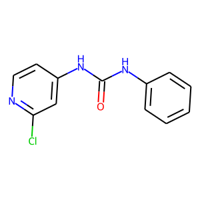

In [122]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

from PIL import Image

for_extraction_df = for_extraction_df[['pca-one', 'pca-two', 'SMILES', 'Overall label']]
#print(for_extraction_df)

# Extract selected compounds
# Input PCA as boundaries
# Code will pick one of the middle compounds within the specified boundaries
def extract_PCA(PCA_one_left, PCA_one_right, PCA_two_top, PCA_two_bottom,query_label,img_savepath):
    query_df = for_extraction_df.loc[(for_extraction_df["pca-one"] >= PCA_one_left) & (for_extraction_df["pca-one"] <= PCA_one_right) \
                                     & (for_extraction_df["pca-two"] <= PCA_two_top) & (for_extraction_df["pca-two"] >= PCA_two_bottom) \
                                     & (for_extraction_df['Overall label'] == query_label)]

    sorted_query_df = query_df.sort_values(['pca-one', 'pca-two'])
    sorted_query_df = sorted_query_df.reset_index(drop=True)
    
    # -1 because index starts from 0
    mid_row = int(len(sorted_query_df)/2)   
    print(mid_row)
    print(sorted_query_df.iloc[mid_row])
    
    query_smiles = sorted_query_df.iloc[mid_row]['SMILES']
    
    m = Chem.MolFromSmiles(query_smiles,sanitize=False)
    m.UpdatePropertyCache(strict=False)
    img = Draw.MolToImage(m,kekulize=True)
    img = img.resize((200,200))
    img.save(img_savepath)
    display(img)
    
    return
    
# Note not to specify too precise/exact values because of python float rounding issues
PCA_one_left = 0.9   
PCA_one_right = 2 
PCA_two_top = 0
PCA_two_bottom = -0.85
root = 'C:/Users/mwhw3/Desktop/DART project/AutoML models combined interpreting predicted results/'
img_savepath = root + 'reprotox selected FP compounds/' + 'example' + str(3) + '.png'
extract_PCA(PCA_one_left, PCA_one_right, PCA_two_top, PCA_two_bottom, 'FP', img_savepath)
    

code to count number of fp or fn, dev or repro tox in unified data 

In [140]:
# Code for processing data files from above code

# Author: Marcus Wei How Wang
# 5 May 2022

#======================================================================================#
import pandas as pd
import numpy as np

import time

import os
import os.path
from os.path import isfile

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import pickle
from random import randrange

from autogluon.tabular import TabularDataset, TabularPredictor

import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#==============================================================================================#


# Set filepaths for functions

total_runs = 5

# Filename of model to load'
root = 'C:/Users/mwhw3/Desktop/DART project/'
ref_root_desc = 'V2.0.1 Unified data'
ref_desc = ref_root_desc + ' ' + str(total_runs)
ref_df_filename = root + 'AutoML models combined interpreting predicted results/' +  ref_desc + ' runs processed FN and FP results.csv'
ref_df = pd.read_csv(ref_df_filename)
if 'Unnamed: 0' in (ref_df.columns):
    ref_df = ref_df.drop(columns=['Unnamed: 0'])
print(ref_df)

dev_tox_filename = root + 'V2.0.1 Developmental toxicity' + '.csv'
dev_tox_df = pd.read_csv(dev_tox_filename)
print(dev_tox_df)

repro_tox_filename = root + 'V2.0.1 Reproductive toxicity' + '.csv'
repro_tox_df = pd.read_csv(repro_tox_filename)
print(repro_tox_df)

# overall_save = root + 'AutoML models combined interpreting predicted results/' + model_root_desc + \
# str(total_runs) +' runs interpreting predicted results.csv'
misclassified_stats_save_desc = root + 'AutoML models combined interpreting predicted results/' + ref_root_desc + \
' ' + str(total_runs) +' runs processed misclassified stats.csv'

#======================================================================================#

# Main code
tox_ls = []
tox_ls.clear()

dev_tox_FN_count = 0
dev_tox_FP_count = 0

repro_tox_FN_count = 0
repro_tox_FP_count = 0

unclear_FN_count = 0
unclear_FP_count = 0

stats_ls = []
stats_ls.clear()

for x in range(0,len(ref_df)):
    query_smiles = ref_df.iloc[x]['SMILES']
    
#     if (query_smiles in dev_tox_df['SMILES']):
    if (query_smiles in dev_tox_df['SMILES'].values) and (query_smiles not in repro_tox_df['SMILES'].values):
        tox_ls.append('Devtox')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            dev_tox_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            dev_tox_FP_count += 1
        
#     if (query_smiles in repro_tox_df['SMILES']):
    if (query_smiles in repro_tox_df['SMILES'].values) and (query_smiles not in dev_tox_df['SMILES'].values):
        tox_ls.append('Reprotox')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            repro_tox_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            repro_tox_FP_count += 1      
        
    else:    
        tox_ls.append('Unclear')
        if ref_df.iloc[x]['Overall label'] == 'FN':
            unclear_FN_count += 1
        if ref_df.iloc[x]['Overall label'] == 'FP':
            unclear_FP_count += 1

# Create dataframe to save
stats_ls.append(dev_tox_FN_count)
stats_ls.append(dev_tox_FP_count)
stats_ls.append(repro_tox_FN_count)
stats_ls.append(repro_tox_FP_count)
stats_ls.append(unclear_FN_count)
stats_ls.append(unclear_FP_count)

stats_df = pd.DataFrame(stats_ls).T
stats_df.columns=['dev_tox_FN','dev_tox_FP','repro_tox_FN','repro_tox_FP','unclear_FN','unclear_FP']           
print(stats_df)
stats_df.to_csv(misclassified_stats_save_desc)


print('\nFINISHED')            
            

                                                SMILES run_1 run_2 run_3  \
0    CCOC1=CC=C(C=C1)C(C)(C)COCC1=CC(OC2=CC=CC=C2)=...    FN    FN    FN   
1                                    OC(=O)C1=CC=CC=C1    FN    FN    FN   
2                CC1=C(C)C(NC2=C(C=CC=C2)C(O)=O)=CC=C1    FN   NaN   NaN   
3    NC1=CC(N)=C(C=C1)N=NC1=CC=C(C=C1)C1=CC=C(C=C1)...    FN    FN   NaN   
4                                       COC(C)COC(C)=O    FN   NaN    FN   
..                                                 ...   ...   ...   ...   
653                        ClC1=NC(Cl)=C(Cl)C(Cl)=C1Cl   NaN   NaN   NaN   
654                                             BrCCBr   NaN   NaN   NaN   
655               COCC(C)N(C(=O)CS(O)(=O)=O)C1=CSC=C1C   NaN   NaN   NaN   
656                                        NCCN1CCNCC1   NaN   NaN   NaN   
657                                           C1COCCO1   NaN   NaN   NaN   

    run_4 run_5  Misclass count Overall label  
0     NaN   NaN               3        